# `Практикум по программированию на языке Python`

## `Задание 01. Полносвязная нейронная сеть на numpy`.

#### Фамилия, имя:

Дата выдачи: <span style="color:red">**20 февраля**</span>.

Мягкий дедлайн: <span style="color:red">**6 марта 23:59**</span>.

Стоимость: **10 баллов** (основная часть заданий) + **3 балла** (дополнительные задания).

<span style="color:red">**В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.**</span>

#### `Москва, 2024`


In [2]:
import numpy as np
from numpy import vectorize
from scipy.special import logsumexp
from icecream import ic
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from tabulate import tabulate
from tqdm import tqdm
from sklearn.model_selection import KFold
from math import ceil
%matplotlib inline


## `Теоретическая часть (3 балла)`


В этом блоке вам нужно решить 3 задания.


### `Задание 1. Градиенты для слоя Batch normalization (1.5 балла)`


Рассмотрим слой Batch normalization. Пусть на вход этого слоя был подан батч из $n$ объектов, при этом у всех объектов по 1 признаку. Представим вход BN слоя в виде $X \in \mathbb{R}^{n \times 1}$.

Тогда в этом слое производятся следующие вычисления:

$$ \mu = \frac1n \sum\_{i=1}^{n} X_i $$

$$ \sigma^2 = \frac1n \sum\_{i=1}^{n} \left( X_i - \mu \right) ^2 $$

$$ \tilde{y_i} = \frac{X_i - \mu}{\sqrt{\sigma^2 + \varepsilon}} $$

$$ y_i = \gamma \tilde{y_i} + \delta $$

Выходом BN слоя является $y_i$, а $\gamma,\delta\in\mathbb{R}$ — параметры, которые подбираются во время обучения вместе с другими параметрами нейронной сети (наряду, например, с весами линейного слоя).

Рассмотрим нейронную сеть, в которой есть BN слой. Предположим, что вычисления в нейронной сети завершаются подсчетом функции потерь $\mathcal{L}$. Пусть мы выполнили прямой проход по нейронной сети и сейчас делаем обратный проход с помощью метода обратного распространения ошибки. Пусть BN слою пришел градиент функции потерь по выходу BN слоя ($\nabla_{y} \mathcal{L}$).

В этом задании вам нужно записать вычисление градиента функции потерь по параметрам слоя BN $\gamma$ и $\delta$ ($\nabla_{\gamma} \mathcal{L}$, $\nabla_{\delta} \mathcal{L}$) через $\nabla_{y} \mathcal{L}$, а также вам нужно записать вычисление градиента функции потерь по входу слоя BN $X$ ($\nabla_{X} \mathcal{L}$) через $\nabla_{y} \mathcal{L}$.

Хочу заметить, в данном задании мы рассматриваем объекты всего с 1 признаком, чтобы упростить выкладки.


**Ваше решение:**

---

Сперва посмотрим, как производится дифференцирование сложных функций. Посмотрим на простейший пример композиции скалярных функций.

$$
  \begin{equation*}
    \left\{
      \begin{aligned}
        & Y: \mathbb{R} \longmapsto \mathbb{R} \\
        & x \: : \mathbb{R} \times \mathbb{R} \longmapsto \mathbb{R}
      \end{aligned}
    \right.
  \end{equation*}

  \Longrightarrow Y(x(a, b)), \:\: a, b \in \mathbb{R} \Longrightarrow

  \begin{equation*}
    \left\{
      \begin{aligned}
        & \nabla_{x}Y = \frac{\partial Y}{\partial x} \\
        & \Rightarrow \nabla_{a}Y = \frac{\partial x}{\partial a} \nabla_{x}Y = \frac{\partial Y}{\partial x} \frac{\partial x}{\partial a}\\
        & \Rightarrow \nabla_{b}Y = \frac{\partial x}{\partial b} \nabla_{x}Y = \frac{\partial Y}{\partial x} \frac{\partial x}{\partial b}
      \end{aligned}
    \right.
  \end{equation*}
$$

Данный пример наглядно показывает модель распространения градиента при вычислении частных производных сложных функций. Однако для нашей задачи исходный градиент раскрывается как $\nabla_y \mathcal{L} = \left \{ \frac{\partial \mathcal{L}}{\partial y_1} \: \dotsi \frac{\partial \mathcal{L}}{\partial y_k} \right \}$, а это уже является более сложным случаем матричного дифференцирования. В таком случае введем оператор дифференцирования, действующий на объекты из пространств $\mathbb{R}, \, \mathbb{R}^m \, \text{и} \, \mathbb{R}^{m \times n}$, обозначим его в виде $D$ и для него выпишем интересующее нас свойство $\left[D_{x_0}(u \circ v)\right](h)=\left[D_{v\left(x_0\right)} u\right]\left(\left[D_{x_0} v\right](h)\right)$. С помощью свойства найдем градиенты для слоя BN $( \nabla_{\gamma} \mathcal{L}$, $\nabla_{\delta} \mathcal{L} )$

$$
  \begin{equation*}
    \left\{
      \begin{aligned}
        & \left \langle \nabla_{\gamma} \mathcal{L}, \: h \right \rangle= \left \langle \nabla_{\gamma} \mathcal{L}(y(\gamma, \delta, X)), \: h \right \rangle= \left[ \nabla_{y} \mathcal{L} \right] \left( \nabla_{\gamma} y \, d\gamma \right) = \left \langle \nabla_{y} \mathcal{L}, \: \nabla_{\gamma} y \, d\gamma \right \rangle = \left \langle \nabla_{\gamma}^\intercal y \, \nabla_{y} \mathcal{L}, \: d \, \gamma \right \rangle \\

        & \left \langle \nabla_{\delta} \mathcal{L}, \: h \right \rangle= \, \left \langle \nabla_{\delta} \mathcal{L}(y(\gamma, \delta, X)), \: h \right \rangle= \left[ \nabla_{y} \mathcal{L} \right] \left( \nabla_{\delta} y \, d\delta \right) \, = \left \langle \nabla_{y} \mathcal{L}, \: \nabla_{\delta} y \, d\delta \right \rangle \, = \left \langle \nabla_{\delta}^\intercal y \, \nabla_{y} \mathcal{L}, \: d \, \delta \right \rangle
      \end{aligned}
    \right.
  \end{equation*}

  \Longrightarrow

  \begin{equation*}
    \left\{
      \begin{aligned}
        & \nabla_{\gamma} \mathcal{L} = \nabla_{\gamma}^\intercal y \, \nabla_{y} \mathcal{L} = \tilde{y}^\intercal \, \nabla_{y} \mathcal{L} \\
        & \nabla_{\delta} \mathcal{L} \, = \nabla_{\delta}^\intercal y \, \nabla_{y} \mathcal{L} = \sum^n_{i=1} \nabla_{y}^i \mathcal{L}
      \end{aligned}
    \right.
  \end{equation*}
$$

Легко заметить, что, например, формула для $\nabla_{\gamma} \mathcal{L}$ совпадает с аналитической формулой поэлементного дифференцирования фектора: $\left \{ \frac{\partial \mathcal{L}}{\partial y_1} \frac{\partial y_1}{\partial \gamma} \: \dotsi \frac{\partial \mathcal{L}}{\partial y_k} \frac{\partial y_k}{\partial \gamma} \right \}$

Однако таким образом дифференцирование может быть слишком кропотливой и долгой задачей для сильно вложенных композиций функций. Потому решим задачу общим способом через дифференциалы, воспользовавшись инвариантностью формы перого дифференциала функции:

$$
  \begin{equation*}
    \left\{
      \begin{aligned}
      & d \mathcal{L} = \left \langle \nabla_y \mathcal{L}, dy \right \rangle \\

      & d \mathcal{L} = \left \langle \nabla_\gamma \mathcal{L}, d \gamma \right \rangle + \left \langle \nabla_{\tilde{y}} \mathcal{L}, d \tilde{y} \right \rangle + \left \langle \nabla_\delta \mathcal{L}, d \delta \right \rangle \\

      & d y = \tilde{y} d \gamma + \gamma d \tilde{y} + \mathbb{I} d \delta
      \end{aligned}
    \right.
  \end{equation*}

  \Longrightarrow

  \left \langle \nabla_y \mathcal{L}, \tilde{y} d \gamma + \gamma d \tilde{y} + \mathbb{I} d \delta \right \rangle = \left \langle \tilde{y}^\intercal \nabla_\gamma \mathcal{L}, \mathbb{I} d \gamma \right \rangle + \left \langle \nabla_{\tilde{y}} \mathcal{L}, d \tilde{y} \right \rangle + \left \langle \nabla_\delta \mathcal{L}, \mathbb{I} d \delta \right \rangle

  \Longrightarrow

  \begin{equation*}
    \left\{
      \begin{aligned}
      & \nabla_{\gamma} \mathcal{L} = \tilde{y}^\intercal \, \nabla_{y} \mathcal{L} \\

      & \nabla_{\delta} \mathcal{L} = \mathbb{I}^\intercal \nabla_{y} \mathcal{L} \\

      & \nabla_{\tilde{y}} \mathcal{L} = \gamma \nabla_{y} \mathcal{L}
      \end{aligned}
    \right.
  \end{equation*}
$$

Видно, что мы вывели те же самые формулы для дифференциалов слоя BN, полученные нами ранее через явное свойство дифференцирования сложных функций. Осталось же найти дифференциал по входу функции. Для этого распространим дифференциал с $\nabla_{\tilde{y}} \mathcal{L}$ далее на входы $X$

$$
d \mathcal{L} = \left \langle \nabla_X \mathcal{L}, \, d X \right \rangle = \left \langle \nabla_{\tilde{y}} \mathcal{L}, \, d \tilde{y} \right \rangle ; \; \; \;
    y = \frac{X - \mathbb{I} \mu}{\sqrt{\sigma^2 + \varepsilon}} ; \; \; \;
    \mu = \frac{1}{n} \mathbb{I} ^ \intercal X; \; \; \;
    \sigma^2 = \frac{1}{n} \left \langle X, X \right \rangle - \mu ^ 2
$$

$$
  \begin{equation*}
    \left\{
      \begin{aligned}
      & d \mu = d \left ( \frac{1}{n} \mathbb{I} ^ \intercal X \right) = \frac{1}{n} \mathbb{I} ^ \intercal d X \\

      & d \sigma ^ 2 = d \left (\frac{1}{n} \left \langle X, X \right \rangle - \mu ^ 2 \right) =
        \frac{1}{n} \left \langle \left ( E + E^\intercal \right) X, d X \right \rangle - \frac{2}{n} \mu \mathbb{I} ^ \intercal d X =
        \frac{2}{n} X ^ \intercal d X  - \frac{2}{n} \mu \mathbb{I} ^ \intercal d X\\

      & d \tilde{y} = \frac{\left ( E \, d X - \mathbb{I} d \mu \right)}{\sqrt{\sigma^2 + \varepsilon}} -
        \left ( X - \mathbb{I} \mu \right) \frac{d \sigma^2}{2 (\sqrt{\sigma^2 + \varepsilon}) ^ 3} =

        \left (\frac{E - \frac{1}{n} \mathbb{I} \, \mathbb{I}^\intercal}{\sqrt{\sigma ^ 2 + \varepsilon}} -
        \left ( X - \mathbb{I} \mu \right) \frac{\frac{1}{n} X^\intercal - \frac{1}{n} \mu \mathbb{I} ^ \intercal}{(\sqrt{\sigma^2 + \varepsilon}) ^ 3} \right ) d X = W \, d X
      \end{aligned}
    \right.
  \end{equation*}
$$

$\Rightarrow \nabla_X \mathcal{L} = W^\intercal \nabla_{\tilde{y}} \mathcal{L} = \gamma \left (\frac{E - \frac{1}{n} \mathbb{I} \, \mathbb{I}^\intercal}{\sqrt{\sigma ^ 2 + \varepsilon}} - \left ( X - \mathbb{I} \mu \right) \frac{\frac{1}{n} X^\intercal - \frac{1}{n} \mu \mathbb{I} ^ \intercal}{(\sqrt{\sigma^2 + \varepsilon}) ^ 3} \right ) ^ \intercal \nabla_{y} \mathcal{L} = \frac{\gamma}{\sqrt{\sigma^2 + \varepsilon}} \left ( E - \frac{\mathbb{I} \, \mathbb{I}^\intercal}{n} -  \frac{y \, y^{\intercal}}{n} \right ) ^\intercal \nabla_{y} \mathcal{L}$

**Ответ:**

1. $\nabla_{\gamma} \mathcal{L} = \tilde{y}^\intercal \, \nabla_{y} \mathcal{L}$

2. $\nabla_{\delta} \mathcal{L} = \mathbb{I}^\intercal \nabla_{y} \mathcal{L}$

3. $\nabla_X \mathcal{L} = \frac{\gamma}{\sqrt{\sigma^2 + \varepsilon}} \left ( E - \frac{\mathbb{I} \, \mathbb{I}^\intercal}{n} -  \frac{y \, y^{\intercal}}{n} \right ) ^\intercal \nabla_{y} \mathcal{L}$

---


### `Задание 2. Вывод инициализации весов линейного слоя при использовании ReLU в качестве функции активации (1 балл)`


Рассмотрим полносвязную нейронную сеть с функцией активации $g(y)$. Пусть сеть состоит из $L$ слоев и размер входа слоя $l$ равен $n_l\ \ (l = \overline{1, L})$.

Обозначим за $x^l \in \mathbb{R}^{n_{l}}$ вход слоя $l$, за $y^l \in \mathbb{R}^{n_{l+1}}$ — выход слоя $l$, за $W^l \in \mathbb{R}^{n_{l+1} \times n_{l}}$ — веса слоя $l$, за $b^l \in \mathbb{R}^{n_{l+1}}$ — вектор сдвига слоя $l$.

Тогда
$$y^l = W^l x^l + b^l,$$
$$x^{l+1} = g(y^l).$$

На паре вы выводили хорошую инициализацию для линейного слоя в случае, когда в качестве функции активации $g(y)$ в нейронной сети используется гиперболический тангенс $g(y) = \tanh(y)$. Сейчас вам нужно сделать подобный вывод для случая, когда в сети в качестве функций активации используется $g(y) = ReLU(y) = \max(0, y)$.

Сделаем следующие предположения насчет того, как распределены веса $W^l$, вектор сдвига $b^l$, входной вектор $x^l$, выходной вектор $y^l$ линейного слоя и градиенты функции потерь $\frac{\partial L}{\partial y^{l}}$ $(l = \overline{1, L}$):

1. Все компоненты в $W^l$ распределены одинаково и независимо друг от друга;
2. Все компоненты в $y^l$ распределены одинаково и независимо друг от друга;
3. Все компоненты в $x^l$ распределены одинаково и независимо друг от друга;
4. Все компоненты в $\frac{\partial L}{\partial y^{l}}$ распределены одинаково и независимо друг от друга;
5. Все компоненты в $W^l$ и все компоненты в $x^l$ независимы друг от друга;
6. Все компоненты в $W^l$ имеют четную плотность распределения (то есть симметричную относительно нуля: $p_{W^l}(-x) = p_{W^l}(x)$);
7. Все компоненты в $W^l$ имеют конечное матожидание;
8. Вектор $b^l$ инициализирован нулями.

Подсказки:

1. Из пунктов 6 и 7 следует, что все компоненты в $W^l$ имеют нулевое среднее ($\mathbb{E} W^l_{ij} = 0\ \ \forall i = \overline{1, n_{l+1}}, j = \overline{1, n_{l}}$) (докажите);
2. Из пунктов 6 и 7 следует, что все компоненты в $y^l$ имеют нулевое среднее и четную плотность распределения (докажите).


**Ваше решение:**

---

Докажем пункты подсказок:

- $\exists \mathbb{E} W*{ij}^l; \, W*{ij}^l \, \text{есть случайная величина с абсолютно непрерывным распределением и плотностью} \, p \Rightarrow \exists \mathbb{E} W*{ij}^l = \int*{-\infty}^{\infty} x p(x) dx = \int*{0}^{\infty} x p(x) dx + \int*{-\infty}^{0} x p(x) dx = \\ \int*{0}^{\infty} xp(x) dx - \int^{\infty}*{0} xp(-x) dx = \text{\{условие четноси плотности\}} = \int*{0}^{\infty} x p(x) dx - \int^{\infty}*{0} x p(x) dx \equiv 0 $

- Для произвольного $y_{i}^l$ справедливо представление: $\sum_{j = 1}^{n_l} w_{ij}^l x^l_j + b_i^l$ - считая, что все значения $w_{ij}^l$ пришли из распределений с нулевым мат. ожиданием и четной плотностью распределения, то используя линейность оператора взятия мат. ожидания и равенства нулю все $b_i^l$ получим:
  $\mathbb{E} y_i^l = \mathbb{E} \sum\limits_{j=1}^{n_l} W_{ij}^l x_j^l + b_i = \sum\limits_{j=1}^{n_l} \mathbb{E} W_{ij}^l \mathbb{E} x_j^l = \text{\{первый пункт\}} \equiv 0$ \\
  Рассмотрим вероятность $\mathbb{P}(\sum\limits_{j=1}^{n_l}W_{ij}^l x_j^l \lt t) = \mathbb{P}(\sum\limits_{j=1}^{n_l} \xi_j^l \lt t)$, где $\xi_j^l$ есть случайная величина с распределением $\int\limits_{-\infty}^{t} p_{W_j^l}(\frac{t}{\tau}) p_{x_j^l}(\tau) d\tau$. Заметим, что плотность распределения данной случаной величины существует почти всюду (всюду кроме точки 0 $\Rightarrow$ доопределим ее здесь нулем), а всюду в области существования плотность четная функция (как произведение двух четных функций). Тогда плотность распределения случайной величины $\sum\limits_{j=1}^{n_l} \xi_j^l$ есть $n_l$ свертка: $\frac{\partial}{\partial t}\mathbb{P}(\sum\limits_{j=1}^{n_l} \xi_j^l)= \frac{\partial}{\partial t} \! \left (\int\limits_{-\infty}^{t} \int\limits_{-\infty}^{\infty} \! \dotsb \! \int\limits_{-\infty}^{\infty} p_{\xi_1}^l(\tau_1) \dotsb p_{\xi_{n_l - 1}}^l(\tau_{n_l - 1}) p_{\xi_{n_l}}^l(t - \sum_{j=1}^{n_l - 1}\tau_j) \right ) \Longrightarrow  \int\limits_{-\infty}^{\infty} \! \dotsb \! \int\limits_{-\infty}^{\infty} p_{\xi_1}^l(\tau_1) \dotsb p_{\xi_{n_l - 1}}^l(\tau_{n_l - 1}) p_{\xi_{n_l}}^l(t - \sum_{j=1}^{n_l - 1}\tau_j)$, что является четной функцией относительно переменной $t$, как интеграл от четных функций $p_{\xi_j^l}$

---

Перейдем к анализу способа инициализации:
Обозначим цель поиска специальных средств инициализации весов: мы хотим обеспечить отсутсвие затухания или сильных всколыханий градиента в процессе обучения модели. Потому требуется, чтобы активационная способность всех слоев была одинаковой и в среднем реакция всех слоев к объектам оставалсь одинаковой. Потому выражаются требования:

1.  $\mathbb{E} y^l = \mathbb{E} y^{l+1};  \; \; \mathbb{D} y^l = \mathbb{D} y^{l+1}$
2.  $\mathbb{E} \delta^l = \mathbb{E} \! \; \delta^{l+1}; \; \; \mathbb{D} \delta^l = \mathbb{D} \delta^{l+1}$

Посмотрим на прямой проход по сети, приняв во внимание независимость $W_{ij}^l$ и $x^l$ в совокупности:

$$\mathbb{D} y^l_i = \mathbb{D} \sum\limits_{j = 1}^{n_l}W_{ij}^l x^l_j = \sum\limits_{j = 1}^{n_l} \mathbb{E} \left \{ (W_{ij}^l x^l_j)^2 - \left(\mathbb{E} W_{ij}^l \mathbb{E} x^l_j\right)^2 \right \}= \{\text{$\mathbb{E} W_{ij}^l = 0$}\}  = \sum\limits_{j = 1}^{n_l} \mathbb{D}  W_{ij}^l \mathbb{E} (x^l_j)^2 = \{\text{равнораспределенность весов}\} =
n_l \mathbb{D} W^l \mathbb{E} (x^l)^2$$

Теперь обратимся к общему виду $x^l$ зная, что для его получения используется функция активации ReLU: $x^{l+1} = ReLU(y^l) = ReLU(W^l x^l + b^l) = (W^l x^l + b^l)^+$. Подставляя данную формулу в полученное ранее уравнение для дисперсии $\mathbb{D} y^l_i = n_l \mathbb{D} W^l \mathbb{E} \, \left ( ReLU(y^{l-1}) \right ) ^ 2 = n_l \mathbb{D} W^l \mathbb{E} \left((y^{l-1})^+ \right)^2$, видим, что нам необходимо рассматривать не изначальные СВ $y^{l-1}$, а величины их положительных срезок. Сделать это мы можем, так как функция $max(0, x)$ есть измеримая относительно измеримого пространства $(\mathbb{R}, \mathcal{B})$ отображение, а значит и $max(0, \xi), \; \text{где} \; \xi \; \text{так же является СВ - является случайной величиной над изначальным вероятностным пространством}$. Найдем мат. ожидание $\mathbb{E} \left((y^{l-1})^+ \right)^2$ и подставим в выражение дисперсии:

$$
\mathbb{E} ((y^l)^+)^2 = \int\limits_{-\infty}^{\infty} (y^l)^2 p_{(y^l)^+}(x) dx = \int\limits_{0}^{\infty} (y^l)^2 p_{y^l}(x) dx = \frac{1}{2} \mathbb{E} (y^l)^2
\Longrightarrow \mathbb{D} y^l = \frac{n_l}{2} \mathbb{D} W^l \mathbb{E} (y^{l-1})^2
$$

Мы знаем итерационную формулу для дисперсии $y^l$, но для ее нахождения нам требуется знание мат. ожидания от квадрата $y^{l-1}$. Такое нас не устраивает, нам нужно выразить дисперсию из $\mathbb{E} (y^{l-1})^2$. Вспомним условие $b^l \equiv 0$ и то, что $W^l x^l$ распределены с симетричной плотностью $\Rightarrow \mathbb{E} y^{l-1} = 0$. А значит и $\mathbb{E} (y^{l-1})^2 \equiv \mathbb{D} y^{l-1}$. Слежовательно перепишем формулу дисперсии:

$$\mathbb{D} y^l = \frac{n_l}{2} \mathbb{D} W^l \mathbb{E} (y^{l-1})^2 = \mathbb{D} y^1 \prod\limits_{i = 2}^{l}\frac{n_i}{2} \mathbb{D} W^i$$

Следовательно для выполнения наших условий на веса $\Longrightarrow \mathbb{E} W^l = 0; \; \frac{n_l}{2} \mathbb{D} W^l = 1 \Longrightarrow \mathbb{E} W^l = 0; \; \mathbb{D} W^l = \frac{2}{n_l} $

Теперь рассмотрим обратный ход. Здесь нам понадобится рассмотреть дисперсию и математическое ожидание градиента на каждом из слоев сети:

$$
    \begin{equation*}
        \left\{
        \begin{aligned}
            & \nabla_{x^l} \mathcal{L} = {W^l} ^ \intercal \nabla_{y^l} \mathcal{L} \\
            & x^l = ReLU(y^{l-1}) = \left (y^{l-1} \right ) ^ +
        \end{aligned}
        \right.
    \end{equation*}

    \Longrightarrow

    \nabla_{y^{l-1}} \mathcal{L} = \mathbb{1}_{\left \{ y^{l-1} \gt 0 \right \}} * {W^l} ^ \intercal \nabla_{y^l} \mathcal{L}

    \Longrightarrow

    \frac{\partial \mathcal{L}}{\partial y_i^{l-1}} = \mathbb{1}_{\left \{ y_i^{l-1} \gt 0 \right \}} \sum\limits_{j=1}^{n_{l+1}} W^l_{ji} \frac{\partial \mathcal{L}}{\partial y_j^{l}}
$$

Тогда в предположении независимости в совокупности $y_i^{l-1}$, $W^l_{ji}$ и $\frac{\partial \mathcal{L}}{\partial y_j^{l}}$, а так же ползуясь линейностью математического ожидания:
$$ \mathbb{E} \frac{\partial \mathcal{L}}{\partial y*j^{l-1}} = \mathbb{E} \left( \mathbb{1}*{\left \{ y*i^{l-1} \gt 0 \right \}} \sum\limits*{j=1}^{n*{l+1}} W^l*{ji} \frac{\partial \mathcal{L}}{\partial y*j^{l}} \right ) = \mathbb{E} \mathbb{1}*{\left \{ y*i^{l-1} \gt 0 \right \}} \cdot \sum\limits*{j=1}^{n*{l+1}} \mathbb{E} W^l*{ji} \mathbb{E} \frac{\partial \mathcal{L}}{\partial y*j^{l}} \equiv \text{\{четность плотности распределения $W^l*{ji}$ \}} \equiv 0$$

Поступим так же с дисперсией:

$$
\mathbb{D} \frac{\partial \mathcal{L}}{\partial y_j^{l-1}} = \mathbb{D} \left( \mathbb{1}_{\left \{ y_i^{l-1} \gt 0 \right \}} \sum\limits_{j=1}^{n_{l+1}} W^l_{ji} \frac{\partial \mathcal{L}}{\partial y_j^{l}} \right) = \mathbb{E} \left ( \mathbb{1}_{\left \{ y_i^{l-1} \gt 0 \right \}} \right)^2 \cdot \mathbb{E} \left( \sum\limits_{j=1}^{n_{l+1}} W^l_{ji} \frac{\partial \mathcal{L}}{\partial y_j^{l}} \right) ^ 2 - \left(\mathbb{E} \left( \mathbb{1}_{\left \{ y_i^{l-1} \gt 0 \right \}} \sum\limits_{j=1}^{n_{l+1}} W^l_{ji} \frac{\partial \mathcal{L}}{\partial y_j^{l}} \right ) \right)^2 = \mathbb{E} \left ( \mathbb{1}_{\left \{ y_i^{l-1} \gt 0 \right \}} \right)^2 \cdot \mathbb{E} \left( \sum\limits_{j=1}^{n_{l+1}} W^l_{ji} \frac{\partial \mathcal{L}}{\partial y_j^{l}} \right) ^ 2 = \\ \\

\mathbb{E} \mathbb{1}_{\left \{ y_i^{l-1} \gt 0 \right \}} \cdot \mathbb{E} \left( \sum\limits_{j=1}^{n_{l+1}} W^l_{ji} \frac{\partial \mathcal{L}}{\partial y_j^{l}} \right) ^ 2 = \text{\{ четность распределения $y_i^{l-1}$ \}} = \frac{1}{2} \mathbb{E} \left( \sum\limits_{j=1}^{n_{l+1}} W^l_{ji} \frac{\partial \mathcal{L}}{\partial y_j^{l}} \right) ^ 2 = \frac{1}{2} \sum\limits_{j=1}^{n_{l+1}} \mathbb{E} (W^l_{ji}) ^ 2 \mathbb{E} \left ( \frac{\partial \mathcal{L}}{\partial y_j^{l}} \right ) ^ 2 -
\sum\limits_{j \neq k}^{n_{l+1}} \mathbb{E} W^l_{mi} \mathbb{E} \frac{\partial \mathcal{L}}{\partial y_k^{l}} = \frac{1}{2} \sum\limits_{j=1}^{n_{l+1}} \mathbb{D} W^l_{ji} \cdot \mathbb{D} \frac{\partial \mathcal{L}}{\partial y_j^{l}} = \frac{n_{l+1}}{2} \mathbb{D} W^l \mathbb{D} \frac{\partial \mathcal{L}}{\partial y^{l}}
$$

Таким образом мы получаем второе условие на дисперсию весов: $\frac{n_{l+1}}{2} \mathbb{D} W^l = 1$, - только при такой инициализации не будет происходить взрывов или затуханий на градиенте $\\ \Longrightarrow \mathbb{E} W^l = 0; \; \frac{n*{l+1}}{2} \mathbb{D} W^l = 1 \Longrightarrow \mathbb{E} W^l = 0; \; \mathbb{D} W^l = \frac{2}{n*{l+1}} $

---


### `Задание 3. Почему функция активации` $ReLU(y) = \max(0, y)$ `предпочтительней сигмоиды` $\sigma(y) = \frac{1}{1 + \exp(-y)}$ `в нейронных сетях? (0.5 балла)`


Дайте развернутый ответ на вопрос "Почему функция активации $ReLU(y) = \max(0, y)$ предпочтительней сигмоиды $\sigma(y) = \frac{1}{1 + \exp(-y)}$ в нейронных сетях?"


**Ваш ответ:**

Функция активации $ReLU$ обладает рядом положительных качеств, по сравнению с сигмоидальной функцией. Перове, что хочется упомянуть, это расходы на вычисление функции активации на каждом входе: если вычислительная сложность ReLU складывается лишь из операциии ветвления, то для вычисления сигмоидальной функции требуется провести вычисление экспоненты и плюс деления 1 на результат. То же самое можно сказать и о вычислении производной. Разница в закладываемых ресурсах с ростом сети колосальна. При этом сигмоидальная функция ограничивает значения параметров на сегменте $[0; 1]$ для $\\x \in \mathbb{R}$. Такое поведение может показаться крайне полезным, например, в стремлении к избавлению от взрывов активации, однако из самой формы сигмоиды исходит и главнейшая проблема: затухание градиента. Производная функйции сигмоиды ограничена на $\mathbb{R}$ и при этом быстро стремится к нулю при $x \rightarrow \pm \infty$, из-за чего градиент быстро стремится к нулю с ростом слоев от выхода нейросети.


## `Практическая часть (7 баллов)`


### `Реализация нейронной сети (3 балла)`


В этом задании вы обучите полносвязную нейронную сеть распознавать рукописные цифры (а что же еще, если не их :), [почти] самостоятельно реализовав все составляющие алгоритма обучения и предсказания.

Для начала нам понадобится реализовать прямой и обратный проход через слои. Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):


In [3]:
class IdentityLayer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           
    output = layer.forward(input)

    - Propagate gradients through itself:    
    grad_input = layer.backward(input, grad_output)

    Some layers also have learnable parameters.

    Modified code from cs.hse DL course *
    """

    def __init__(self):
        """
        Here you can initialize layer parameters (if any) 
        and auxiliary stuff. You should enumerate all parameters
        in self.params
        """
        # An identity layer does nothing
        self.params = []
        pass

    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], 
        returns output data [batch, output_units]
        """
        # An identity layer just returns whatever it gets as input.
        self.input = input
        return input

    def backward(self, grad_output):
        """
        Performs a backpropagation step through the layer, 
        with respect to the given input.

        To compute loss gradients w.r.t input, 
        you need to apply chain rule (backprop):

        d `loss` / d `input` = (d `loss` / d `layer`) * (d `layer` / d `input`)

        Luckily, you already receive d `loss` / d `layer` in argument, 
        so you only need to multiply it by d `layer` / d `input`.

        NB: Sometimes d `layer` / d `input` can be a 3D or even 4D tensor.
        So it's better to write down the `loss` differential and extract
        d `layer` / d `input` from it so that only 2D tensors were present.

        The method returns:
        * gradient w.r.t input (will be passed to 
          previous layer's backward method)
        * flattened gradient w.r.t. parameters (with .ravel() 
          applied to each gradient). 
          If there are no params, return []
        """
        # The gradient of an identity layer is precisely grad_output
        input_dim = self.input.shape[1]

        d_layer_d_input = np.eye(input_dim)

        return np.dot(grad_output, d_layer_d_input), []  # chain rule

#### `Слой нелинейности ReLU`


Для начала реализуем слой нелинейности $ReLU(y) = \max(0, y)$. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения $ReLU$ к входному массиву, метод `backward` — градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить как атрибут класса.


In [4]:
class ReLU:
    """
    Modified code from cs.hse DL course *
    """

    def __ReLU(self, c):
        return lambda x: x if x > 0 else c

    def __RelU_grad(self, c):
        return lambda x: 1 if x > 0 else c

    def __init__(self, leaky=None):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        self.params = []  # ReLU has no parameters

        self.relu = vectorize(self.__ReLU(
            leaky if leaky is not None else 0), otypes=[np.float32])
        self.relu_grad = vectorize(self.__RelU_grad(
            leaky if leaky is not None else 0), otypes=[np.float32])

    def forward(self, input):
        """Apply elementwise ReLU to [batch, num_units] matrix"""
        # your code here
        self.input = input
        return self.relu(input)

    def backward(self, grad_output):
        """Compute gradient of loss w.r.t. ReLU input
        grad_output shape: [batch, num_units]
        output 1 shape: [batch, num_units]
        output 2: []
        """
        # your code here
        layer_grad = self.relu_grad(self.input)
        return layer_grad * grad_output, []

    def __repr__(self):
        return 'Relu()'

#### `Полносвязный слой`


Далее реализуем полносвязный слой без нелинейности. У слоя два параметра: матрица весов и вектор сдвига.

Обратите внимание на второй аргумент: в нем надо возвращать градиент по всем параметрам в одномерном виде. Для этого надо сначала применить `.ravel()` ко всем градиентам, а затем воспользоваться `np.r_`:


In [121]:
# example
np.r_[np.eye(3).ravel(), np.arange(4)]

array([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2., 3.])

In [120]:
np.random.randn(3, 4)

array([[ 0.03562097, -1.8288803 ,  1.00096229,  0.77431848],
       [-0.03081312,  0.01410933,  1.36553788, -0.96858833],
       [ 0.65188578,  0.08472743,  0.55946508,  0.21624476]])

In [5]:
class Dense:
    """
    Modified code from cs.hse DL course *
    """

    def __init__(self, input_units, output_units):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = x W + b
        """
        # initialize weights with small random numbers from normal distribution
        self.weights = np.random.randn(input_units, output_units) * 0.01
        self.biases = np.zeros(output_units)
        self.params = [self.weights, self.biases]

    def forward(self, input):
        """
        Perform an affine transformation:
        f(x) = x W + b

        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        # your code here
        self.input = input
        return input @ self.weights + self.biases

    def backward(self, grad_output):
        """
        compute gradients
        grad_output shape: [batch, output_units]
        output shapes: [batch, input_units], [num_params]

        hint: use function np.r_
        np.r_[np.arange(3), np.arange(3)] = [0, 1, 2, 0, 1, 2]
        """
        # your code here

        layer_grad_weights = self.input.T @ grad_output
        layer_grad_bias = np.sum(grad_output, axis=0)
        back_grad_output = grad_output @ self.weights.T

        return back_grad_output, np.r_[layer_grad_weights.ravel(), layer_grad_bias.ravel()]

    def __repr__(self):
        return f'Dense({self.weights.shape[0]}, {self.weights.shape[1]})'

#### `Проверка градиента`


Проверим правильность реализации с помощью функции численной проверки градиента. Функция `eval_numerical_gradient` принимает на вход callable объект `f` (функцию от одного аргумента-матрицы) и аргумент `x` и вычисляет приближенный градиент функции `f` в точке `x`.


In [6]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """
    Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/
    """
    fx = f(x)  # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h)  # the slope
        # if verbose:
        #     print(ix, grad[ix])
        it.iternext()  # step to next dimension

    return grad

Вычислите аналитический и численный градиенты по входу слоя ReLU от функции
$$ f(y) = \sum_i y_i, \quad y = ReLU(x) $$

Выпишите аналитический градиент в этой ячейке:

$$
\frac{\partial}{\partial x_{ij}} f(y) = \begin{equation*}
    \left\{
      \begin{aligned}
      & 0, x_{ij} \leq 0 \\
      & 1, x_{ij} \gt 0
      \end{aligned}
    \right.
  \end{equation*}
$$


Следующая ячейка после заполнения должна не выдавать ошибку :)


In [7]:
relu = ReLU()
points = np.linspace(-1, 1, 10*12).reshape([10, 12])

# your code here


def SumReLU(x):
    # ic(relu.forward(x))
    return np.sum(relu.forward(x))


# analitical grad
relu.forward(points)
grads = relu.backward(np.ones_like(points))[0]

# numerical grad
numeric_grads = np.ndarray(points.shape)
for i in range(points.shape[0]):
    numeric_grads[i, :] = eval_numerical_gradient(
        SumReLU, points[i, :], verbose=False)

# assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

Вычислите аналитический и численный градиенты по входу полносвязного слоя от функции
$$ f(y) = \sum_i y_i, \quad y = W x + b $$

Выпишите аналитический градиент в этой ячейке (советуем выписать градиент через дифференциал функции $f$):

$$\left \langle \nabla_y \mathcal{L}, d y \right \rangle = \left \langle \nabla_W \mathcal{L}, d W \right \rangle + \left \langle \nabla_b \mathcal{L}, d b \right \rangle$$

$$
  dy = d \left ( Wx + b \right ) = d W x + W d x + d b \Longrightarrow

  \begin{equation*}
    \left\{
      \begin{aligned}
      & \left \langle \nabla_y \mathcal{L}, d W x \right \rangle = \left \langle \nabla_y \mathcal{L} x^\intercal, d W \right \rangle \\
      & \left \langle \nabla_y \mathcal{L}, W dx \right \rangle = \left \langle W^\intercal \nabla_y \mathcal{L}, d x \right \rangle \\
      & \left \langle \nabla_y \mathcal{L}, d b \right \rangle
      \end{aligned}
    \right.
  \end{equation*}

  \Longrightarrow

  \begin{equation*}
    \left\{
      \begin{aligned}
      & \nabla_W \mathcal{L} = \nabla_y \mathcal{L} x^\intercal \\
      & \nabla_x \mathcal{L} = W^\intercal \nabla_y \mathcal{L} \\
      & \nabla_b \mathcal{L} = \nabla_y \mathcal{L}
      \end{aligned}
    \right.
  \end{equation*}
$$


Следующая ячейка после заполнения должна не выдавать ошибку :)


In [8]:
linear = Dense(12, 32)
points = np.linspace(-1, 1, 10*12).reshape([10, 12])

# your code here


def SumGradWeights(x):
    return np.sum(linear.forward(x))


# analitical grad
linear.forward(points)
grads = linear.backward(np.ones((10, 32)))[0]

# numerical grad
numeric_grads = np.ndarray((points.shape))
for i in range(numeric_grads.shape[0]):
    numeric_grads[i, :] = eval_numerical_gradient(
        SumGradWeights, points[i, :], verbose=False)

# ic(numeric_grads)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

#### `Реализация softmax-слоя и функции потерь`


Для решения задачи многоклассовой классификации обычно используют $softmax$ в качестве нелинейности на последнем слое, чтобы получить вероятности классов для каждого объекта:
$$\hat y = softmax(x)  = \left \{\frac {\exp(x^i)}{\sum_{j=1}^K \exp(x^j)} \right \}_{i=1}^K, \quad K - \text{число классов.}$$

Здесь за $x^i$ мы обозначаем $i$-ый признак объекта $x$.

В качестве функции потерь выберем отрицательный логарифм правдоподобия (по английски: negative log likelihood или NLL)
$$L(y, \hat y) = -\sum_{i=1}^K y^i \log \hat y^i,$$
где $y^i = 1$, если объект принадлежит $i$-му классу, и $y^i = 0$ иначе.

NLL совпадает с выражением для [кросс-энтропии](https://ru.wikipedia.org/wiki/Перекрёстная_энтропия) (в качестве первого распределения берем вырожденное распределение $y$, в качестве второго — предсказанное распределение $\hat y$). Очевидно, что эту функцию потерь также можно переписать через индексацию, если через $y$ обозначить класс данного объекта:
$$L(y, \hat y) = - \log \hat y_{y}$$

В таком виде ее удобно реализовывать.


Для обучения нейронной сети будем оптимизировать эту функцию потерь по параметрам нейронной сети:

$$ \frac1N \sum*{i=1}^N L(y_i, \hat y_i) = \frac1N \sum*{i=1}^N L(y*i, \text{NN}(x_i)) \rightarrow \min*{w}\,,$$
где за $x_i$ и $y_i$ мы обозначили признаки и таргет $i$-ого объекта обучающей выборки, за $\text{NN}$ мы обозначили нейронную сеть, которая по признакам объекта $x_i$ выдает распределение вероятностей $\hat y_i$, за $w$ мы обозначили все веса нейронной сети, а $N$ — это число объектов в обучающей выборке.


Реализуйте слой `LogSoftmax` (у этого слоя нет параметров). Метод `forward` должен вычислять логарифм от $softmax$, а метод `backward` — пропускать градиенты. В общем случае в промежуточных вычислениях `backward` получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде. Поэтому мы будем предполагать, что аргумент `grad_output` — это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

**Пожелание.** Постарайтесь максимально упростить формулу градиентов, чтобы получился лаконичный и стабильный код. Большие и страшные реализации часто оказываются нестабильными.


In [28]:
# from scipy.special import logsumexp
# use this function instead of np.log(np.sum(np.exp(...))) because it is more stable

In [7]:
class LogSoftmax:
    def __init__(self):
        self.params = []

    def forward(self, input):
        """
        Applies softmax to each row and then applies component-wise log
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        """
        # your code here
        self.input = input

        return input - logsumexp(input, axis=-1, keepdims=True)

    def backward(self, grad_output):
        """
        Propagartes gradients.
        Assumes that each row of grad_output contains only 1 
        non-zero element
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        Do not forget to return [] as second value (grad w.r.t. params)
        """
        # your code here
        X = np.exp(self.input).astype(np.float64)
        sum_exp = np.sum(X, axis=-1, keepdims=True)
        sum_init = np.sum(grad_output, axis=-1, keepdims=True)

        grad = grad_output - sum_init * X / sum_exp

        return grad, []

    def __repr__(self):
        return 'LogSoftmax()'

In [7]:
sf = LogSoftmax()
points = np.linspace(-1, 1, 10*12).reshape([10, 12])

# your code here


def SumSoftMax(x):
    return np.sum(sf.forward(x))


# analitical grad
sf.forward(points)
grads = sf.backward(np.ones((10, 12)))[0]

# numerical grad
numeric_grads = np.ndarray((points.shape))
for i in range(numeric_grads.shape[0]):
    numeric_grads[i, :] = eval_numerical_gradient(SumSoftMax, points[i, :])

assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

Реализуйте функцию потерь и градиенты функции потерь. Во время вычисления NLL усредняйте (а не суммируйте) значения функции потерь по батчу. Обычно так делают для того, чтобы при двух запусках обучения нейронной сети с разными размерами батча получаемые значения функции потерь у этих сетей были сравнимы.


In [8]:
def NLL(activations, target):
    """
    Returns negative log-likelihood of target under model represented by
    activations (log probabilities of classes, it's just output of LogSoftmax layer).
    `activations` has shape [batch, num_classes], `target` has shape [batch]
    Output shape: 1 (scalar).
    """
    # your code here
    answ = np.mean(-activations[np.arange(len(target)), target])
    return answ


def grad_NLL(activations, target):
    """
    Returns gradient of negative log-likelihood w.r.t. activations.
    each arg has shape [batch, num_classes]
    output shape: [batch, num-classes]
    """
    # your code here
    answ = np.zeros(activations.shape)
    answ[np.arange(len(target)), target] = 1

    return (np.exp(activations) - answ) / len(target)

Наконец, выполните проверку `LogSoftmax`-слоя, используя функцию потерь и ее градиент:


In [9]:
n = 50
d = 10
lsm = LogSoftmax()
target = np.random.choice(d, size=n)
points = np.random.uniform(-1, 1, n*d).reshape([n, d])

# your code here


def get_loss(x):
    sf = lsm.forward(x)
    return NLL(sf, target)


# analitical grad
lsm_out = lsm.forward(points)
loss_grad = grad_NLL(lsm_out, target)
grads = lsm.backward(loss_grad)[0]

# numeric grad
numeric_grads = eval_numerical_gradient(get_loss, points)

assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

### `Загрузка данных`


Мы реализаовали все архитектурные составляющие нашей нейронной сети. Осталось загрузить данные и обучить модель. Мы будем работать с датасетом `digits`, каждый объект в котором — это 8x8 изображение рукописной цифры.


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
from sklearn.datasets import load_digits

In [11]:
X, y = load_digits(return_X_y=True)

In [12]:
X.shape, y.shape

((1797, 64), (1797,))

Проведем разведывательный анализ


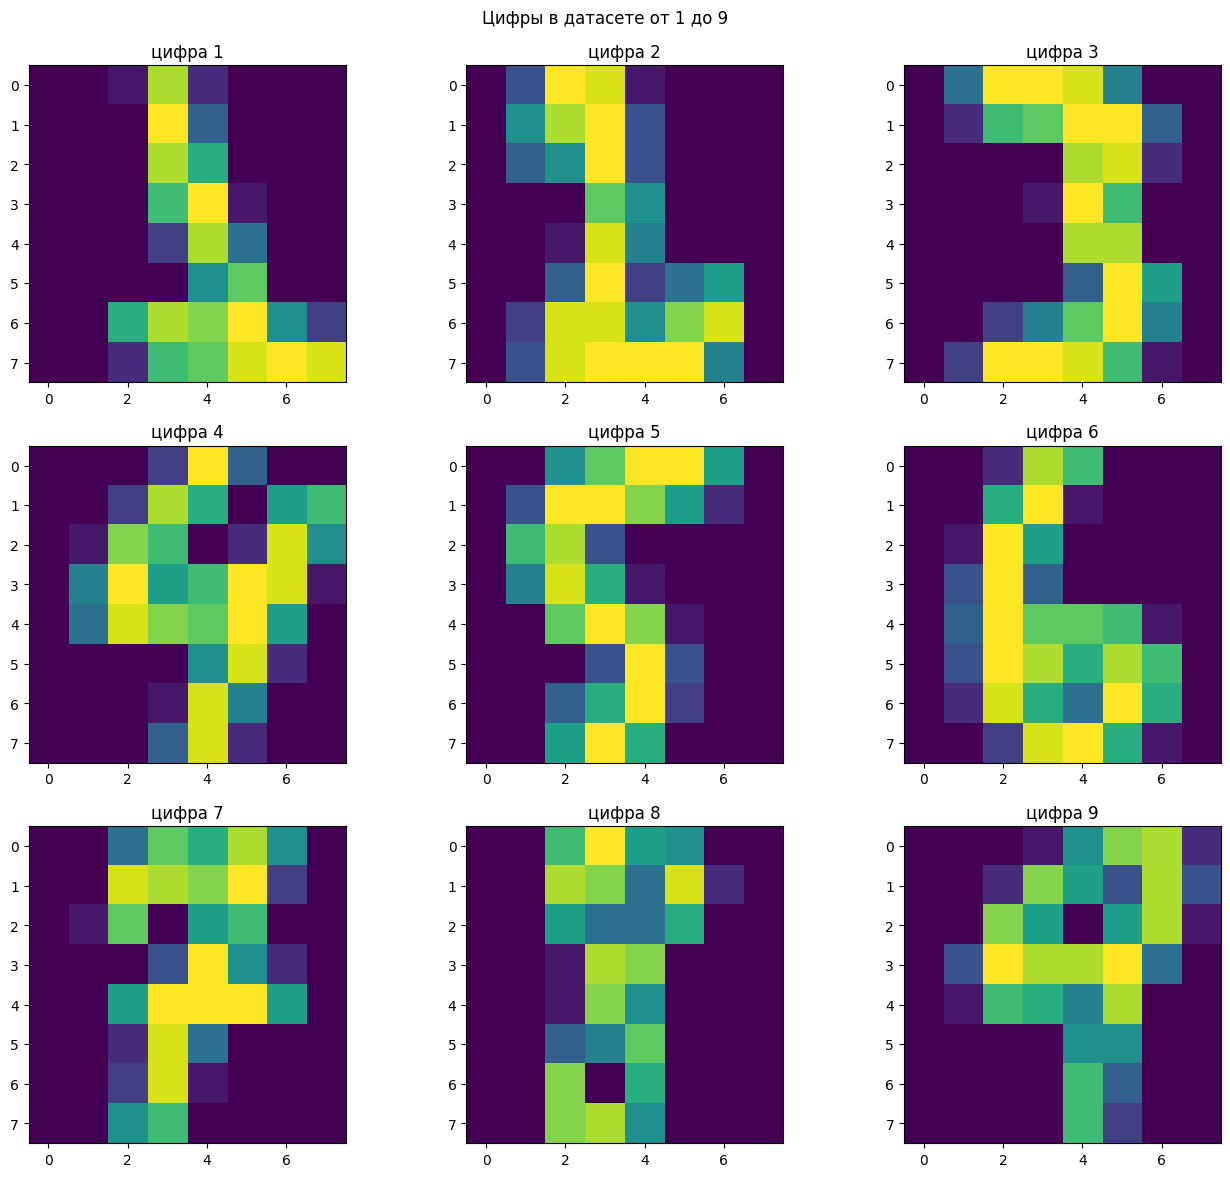

In [20]:
np.random.seed(42)

fig, axis = plt.subplots(3, 3)
fig.set_figwidth(16)
fig.set_figheight(14)

title = fig.suptitle('Цифры в датасете от 1 до 9')
title.set_position((0.5, 0.92))
for i, dig in enumerate(np.unique(y)[1:]):
    dig_indx = np.where(y == dig)
    rand_img = np.random.choice(dig_indx[0])

    axis[i // 3][i % 3].imshow(X[rand_img].reshape((8, 8)))
    axis[i // 3][i % 3].set_title(f'цифра {i + 1}')

На изображении выще показаны лишь 9 из 10 цифр для сохранения красоты картинки :)

Видно, что размерность исходных данных (8 на 8 пикселей) сильно отобразилась на ифнормации, хранимой в данных. Так изображения крайне размыты, контуры часто по толщине сравнимы с толщиной линии самих цифр, а локьальный контекст в саовсем уж малой рамерности практически идентичен и глоабльному контексту изоражений. Изображения не содержат какой-либо серьезной глобальной или локальной информации по раздельности, а значит нам не требуется применять сверточные слои и подойдет полносвязная


Рассмотрим положение картинок в пространстве проецирования при помощи t-SNE


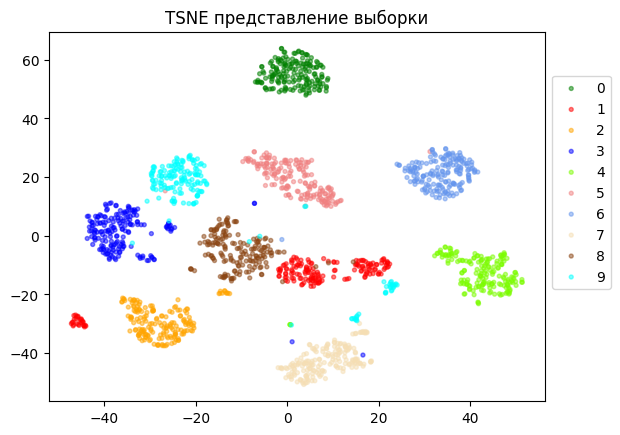

In [24]:
tsne = TSNE(n_components=2)
embeddings = tsne.fit_transform(X)
mapper = {
    0: 'green',
    1: 'red',
    2: 'orange',
    3: 'blue',
    4: 'lawngreen',
    5: 'lightcoral',
    6: 'cornflowerblue',
    7: 'wheat',
    8: 'saddlebrown',
    9: 'aqua'
}
colors = np.array(list(map(lambda x: mapper[x], y.tolist())))

for i in range(10):
    indexes = np.where(y == i)[0]
    plt.scatter(embeddings[indexes, 0], embeddings[indexes, 1],
                c=colors[indexes], label=f'{i}', alpha=0.5, s=8)

plt.title('TSNE представление выборки')
plt.legend(bbox_to_anchor=(1, 0.9))

В целом, класетры цифр даже по Евклидовой метрике хорошо идентифицируемы и даже интрепретируемы человеческим глазом


Разделим данные на обучение и контроль:


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [15]:
X_train.shape, X_test.shape

((1347, 64), (450, 64))

### `Сборка и обучение нейронной сети (0.8 балла)`


В нашей реализации мы представляем нейронную сеть в виде списка ее слоев. Например, следующая функция конструирует нейронную сеть заданной ширины (то есть с заданным размером скрытых слоев) и глубины (то есть с заданным количеством слоев) с заданным размером входа и выхода, а также с заданной функцией активации между линейными слоями.


In [16]:
def make_network(input_size, hidden_layers_size, output_size, n_layers=3, activation_class=ReLU):
    network = []

    for layer_idx in range(n_layers):
        # Compute sizes of current linear layer
        layer_in = input_size if layer_idx == 0 else hidden_layers_size
        layer_out = output_size if layer_idx == n_layers - 1 else hidden_layers_size

        # Add linear layer to the network
        network.append(Dense(layer_in, layer_out))

        # Add activation after each layer except the last one
        if layer_idx != n_layers - 1:
            network.append(activation_class())

    # Add LogSoftmax layer to the network
    network.append(LogSoftmax())

    return network

In [22]:
input_size = X_train.shape[1]
hidden_layers_size = 32
output_size = 10

network = make_network(input_size, hidden_layers_size, output_size, 3, ReLU)
network

[Dense(64, 32), Relu(), Dense(32, 32), Relu(), Dense(32, 10), LogSoftmax()]

Реализуйте функцию, которая выполнет прямой проход по нейронной сети:


In [17]:
def forward(network, X):
    """
    Perform forward pass through the network.

    network: list of layers
    X: raw data
    X shape: [batch, features_num]

    output: 
    output shape: [batch, out_features_num]
    """
    # your code here
    curr = X
    for layer in network:
        curr = layer.forward(curr)

    return curr

Для проверки, хорошо ли сеть обучилась, нам понадобится вычислять долю правильных ответов (accuracy) на данной выборке. Для этого реализуйте функцию, которая делает предсказания на каждом объекте (логично в качестве предсказания на очередном объекте выдавать тот класс, для которого предсказанный логарифм вероятности максимален):


In [18]:
def predict(network, X):
    """
    Returns predictions for each object in X.

    network: list of layers
    X: raw data
    X shape: [batch, features_num]

    output: array of classes, each from 0 to 9
    output shape: [batch]
    """
    # your code here
    probas = forward(network, X)

    return np.argmax(probas, axis=1)

In [35]:
predict(network, X_train[:100, :])

array([7, 6, 8, 8, 6, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 6, 9, 7, 9, 7, 9, 6, 6, 7, 7, 7, 7, 7, 8, 7, 7,
       9, 7, 7, 8, 7, 7, 6, 7, 7, 7, 7, 6, 7, 7, 7, 6, 7, 7, 9, 7, 7, 7,
       7, 7, 7, 7, 7, 6, 7, 4, 7, 7, 7, 7])

Мы будем обучать параметры нейросети с помощью готовой функции оптимизации из модуля `scipy`:


In [19]:
from scipy.optimize import minimize

In [27]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where ``x`` is a 1-D array with shape (n,) and ``args``
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where ``n`` is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see he

Эта функция имеет стандартный интерфейс: нужно передать callable объект, который вычисляет значение и градиент целевой функции, а также точку старта оптимизации — начальное приближение (одномерный `numpy`-массив). Поэтому нам понадобятся функции для сбора и задания всех весов нашей нейросети (именно для них мы всегда записывали параметры слоя в список `layer.params`)


In [20]:
def get_weights(network):
    weights = []
    for layer in network:
        for param in layer.params:
            weights += param.ravel().tolist()
    return np.array(weights)


def set_weights(weights, network):
    i = 0
    for layer in network:
        for param in layer.params:
            l = param.size
            param[:] = weights[i:i+l].reshape(param.shape)
            i += l

Вам нужно реализовать ту самую функцию, которую мы будем передавать в `minimize`. Эта функция должна брать на вход текущую точку (вектор всех параметров), а также список дополнительных параметров (мы будем передавать через них нашу сеть и обучающие данные) и возвращать значение критерия качества (NLL) и его градиент по параметрам модели.


In [21]:
def compute_loss_grad(weights, args):
    """
    takes current weights and computes cross-entropy and gradients
    weights shape: [num_parameters]
    output 1: loss (scalar)
    output 2: gradient w.r.t. weights, shape: [num_parameters]

    hint: firstly perform forward pass through the whole network
    then compute loss and its gradients
    then perform backward pass, transmitting first baskward output
    to the previos layer and saving second baskward output in a list
    finally flatten all the gradients in this list
    (in the order from the first to the last layer)

    Do not forget to set weights of the network!
    """
    network, X, y = args

    set_weights(weights, network)

    out = forward(network, X)
    loss = NLL(out, y)
    curr_grad = grad_NLL(out, y)

    param_list_reversed = []

    for layer in network[::-1]:
        curr_grad, params_grad = layer.backward(curr_grad)
        param_list_reversed.append(params_grad)

    # fatten list
    ravel_grad = np.hstack([
        x for xs in param_list_reversed[::-1] for x in xs
    ])

    return loss, ravel_grad

In [41]:
compute_loss_grad(get_weights(network), (network, X_train, y_train))

(2.3026418886221522,
 array([0.        , 0.        , 0.        , ..., 0.00288164, 0.00652951,
        0.00129416]))

Теперь мы готовы обучать нашу нейросеть.


In [42]:
weights = get_weights(network)

In [43]:
res = minimize(
    compute_loss_grad, weights,       # fun and start point
    args=[network, X_train, y_train],  # args passed to fun
    method="L-BFGS-B",                # optimization method
    jac=True                          # says that gradient is computed in fun
)

In [424]:
res.keys()

dict_keys(['fun', 'jac', 'nfev', 'njev', 'nit', 'status', 'message', 'x', 'success', 'hess_inv'])

In [425]:
res["nit"]  # number of iterations (should be >> 10)

116

In [426]:
res["success"]  # should be True

True

In [427]:
res["x"]  # leraned weights

array([ 0.00303703,  0.00210177, -0.00391365, ..., -0.59617367,
       -1.59697341, -0.24425791])

Выведите качество на обучении (`X_train`, `y_train`) и на контроле (`X_test`, `y_test`). Не забудьте установить веса!


In [47]:
# your code here
set_weights(res['x'], network)

train_activations = forward(network, X_train)
test_activations = forward(network, X_test)
train_score = NLL(train_activations, y_train)
test_score = NLL(test_activations, y_test)

preds_train = predict(network, X_train)
preds_test = predict(network, X_test)
train_accuracy = accuracy_score(y_train, preds_train)
test_accuracy = accuracy_score(y_test, preds_test)

print(
    tabulate([['train', f'{train_score:.9f}', f'{train_accuracy:.9f}'],
              ['test', f'{test_score:.9f}', f'{test_accuracy:.9f}']],
             headers=['', 'NLL', 'accuracy'], tablefmt='rounded_grid',
             colalign=("right", "right", "right"))
)

╭───────┬─────────┬────────────╮
│       │     NLL │   accuracy │
├───────┼─────────┼────────────┤
│ train │ 3.2e-07 │          1 │
├───────┼─────────┼────────────┤
│  test │ 1.10652 │   0.951111 │
╰───────┴─────────┴────────────╯


Видно, что даже малая (неглубокая) нейросеть смогла добиться хорошего результата на тестовой выборке без сложных манипуляций с инициализацией сети или предобработок данных


У `minimize` есть также аргумент `callback` — в нее можно передать функцию, которая будет вызываться после каждой итерации оптимизации. Такую функцию удобно оформить в виде метода класса, который будет сохранять качество на обучении контроле после каждой итерации. Реализуйте этот метод в классе `Callback`:


In [22]:
class Callback:
    def __init__(self, network, X_train, y_train, X_test, y_test, print=False):
        self.network = network
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.print = print
        self.train_acc = []
        self.test_acc = []

        self.iteration = 0

    def call(self, weights):
        """
        Computes quality on train and test set with given weights
        and saves to self.train_acc and self.test_acc.
        If self.print is True, also prints these 2 values
        """
        # your code here
        preds_train = predict(self.network, self.X_train)
        preds_test = predict(self.network, self.X_test)
        train_accuracy = accuracy_score(self.y_train, preds_train)
        test_accuracy = accuracy_score(self.y_test, preds_test)
        self.train_acc.append(train_accuracy)
        self.test_acc.append(test_accuracy)

        self.iteration += 1

        train_activations = forward(self.network, self.X_train)
        loss = NLL(train_activations, self.y_train)
        if self.print:
            print('-' * 10, f'iteration {self.iteration}', '-' * 10)
            print(f'loss: {loss}')
            print(f'grad norm: {np.linalg.norm(weights)}')
            print(f'train_acc: {train_accuracy}')
            print(f'test_acc: {test_accuracy}')

In [46]:
cb = Callback(network, X_train, y_train, X_test, y_test, print=True)

res = minimize(
    compute_loss_grad, weights,
    args=[network, X_train, y_train],
    method="L-BFGS-B",
    jac=True,
    callback=cb.call
)

---------- iteration 1 ----------
loss: 2.3004026413117646
grad norm: 0.6690109088106754
train_acc: 0.10616184112843356
test_acc: 0.08444444444444445
---------- iteration 2 ----------
loss: 2.27579082431202
grad norm: 1.2081233241833298
train_acc: 0.18634001484780996
test_acc: 0.14
---------- iteration 3 ----------
loss: 2.275504467136947
grad norm: 1.2195801838218006
train_acc: 0.1855976243504083
test_acc: 0.14
---------- iteration 4 ----------
loss: 2.263843483741535
grad norm: 1.2603270192846845
train_acc: 0.19376391982182628
test_acc: 0.1511111111111111
---------- iteration 5 ----------
loss: 2.228725357865702
grad norm: 1.4879060045970274
train_acc: 0.20044543429844097
test_acc: 0.16666666666666666
---------- iteration 6 ----------
loss: 2.144909177878145
grad norm: 1.946781597669071
train_acc: 0.24647364513734224
test_acc: 0.2222222222222222
---------- iteration 7 ----------
loss: 1.94450420028337
grad norm: 2.4820749171321452
train_acc: 0.39346696362286565
test_acc: 0.4066666666

Изобразите на графике кривую качества на обучени и контроле по итерациям:


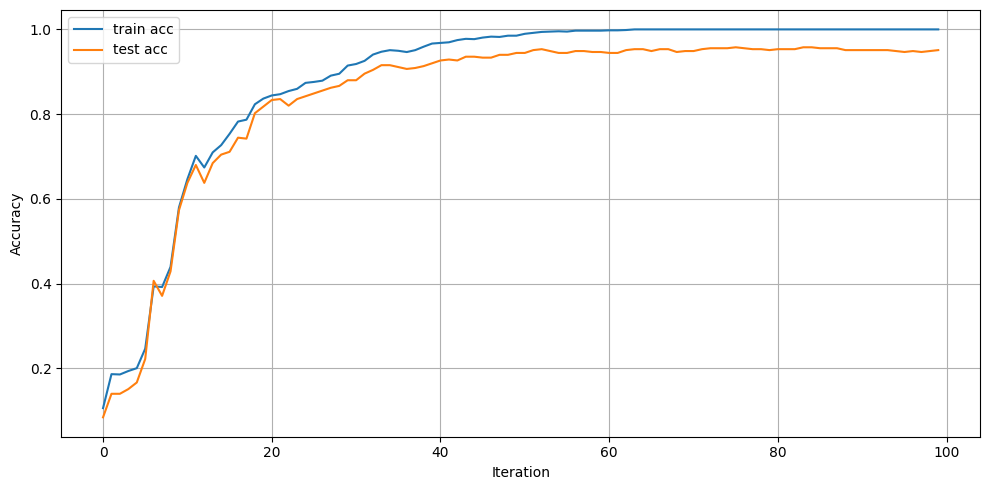

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(cb.train_acc, label="train acc")
ax.plot(cb.test_acc, label="test acc")
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

### `Эксперименты с числом слоев (0.6 балла)`


Ясно, что из-за случайного начального приближения с каждым запуском обучения мы будем получать различное качество. Попробуем обучить нашу нейросеть с разным числом слоев несколько раз.

Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети с $i+1$ полносвязными слоями при $j$-м запуске (все запуски идентичны).


In [50]:
N = 15
accs_train = np.zeros((5, N))
accs_test = np.zeros((5, N))

In [52]:
def add_stats(train, test, i, j):
    accs_train[i][j] = train
    accs_test[i][j] = test


def train_model(network, i, j):
    weights = get_weights(network)

    res = minimize(
        compute_loss_grad, weights,
        args=[network, X_train, y_train],
        method="L-BFGS-B",
        jac=True)

    preds_train = predict(network, X_train)
    preds_test = predict(network, X_test)
    train_accuracy = accuracy_score(y_train, preds_train)
    test_accuracy = accuracy_score(y_test, preds_test)

    add_stats(train_accuracy, test_accuracy, i, j)


# 1 layer network
for i in range(N):
    network = [
        Dense(64, 10),
        LogSoftmax()
    ]

    train_model(network, 0, i)


# 2 layer network
for i in range(N):
    network = [
        Dense(64, 32),
        ReLU(),
        Dense(32, 10),
        LogSoftmax()
    ]

    train_model(network, 1, i)

# 3 layer network
for i in range(N):
    network = [
        Dense(64, 32),
        ReLU(),
        Dense(32, 16),
        ReLU(),
        Dense(16, 10),
        LogSoftmax()
    ]

    train_model(network, 2, i)


# 4 layer network
for i in range(N):
    network = [
        Dense(64, 32),
        ReLU(),
        Dense(32, 32),
        ReLU(),
        Dense(32, 32),
        ReLU(),
        Dense(32, 10),
        LogSoftmax()
    ]

    train_model(network, 3, i)

# 5 layer network
for i in range(N):
    network = [
        Dense(64, 50),
        ReLU(),
        Dense(50, 40),
        ReLU(),
        Dense(40, 30),
        ReLU(),
        Dense(30, 20),
        ReLU(),
        Dense(20, 10),
        LogSoftmax()
    ]

    train_model(network, 4, i)

/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21880/1838013661.py:26: RuntimeWarning: overflow encountered in exp
  X = np.exp(self.input).astype(np.float64)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21880/1838013661.py:30: RuntimeWarning: invalid value encountered in multiply
  grad = grad_output - sum_init * X / sum_exp
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21880/1838013661.py:30: RuntimeWarning: invalid value encountered in divide
  grad = grad_output - sum_init * X / sum_exp
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21880/1838013661.py:26: RuntimeWarning: overflow encountered in exp
  X = np.exp(self.input).astype(np.float64)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21880/1838013661.py:30: RuntimeWarning: invalid value encountered in divide
  grad = grad_output - sum_init * X / sum_exp
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21880/1838013661.py:26: RuntimeWarning: overflow encou

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).


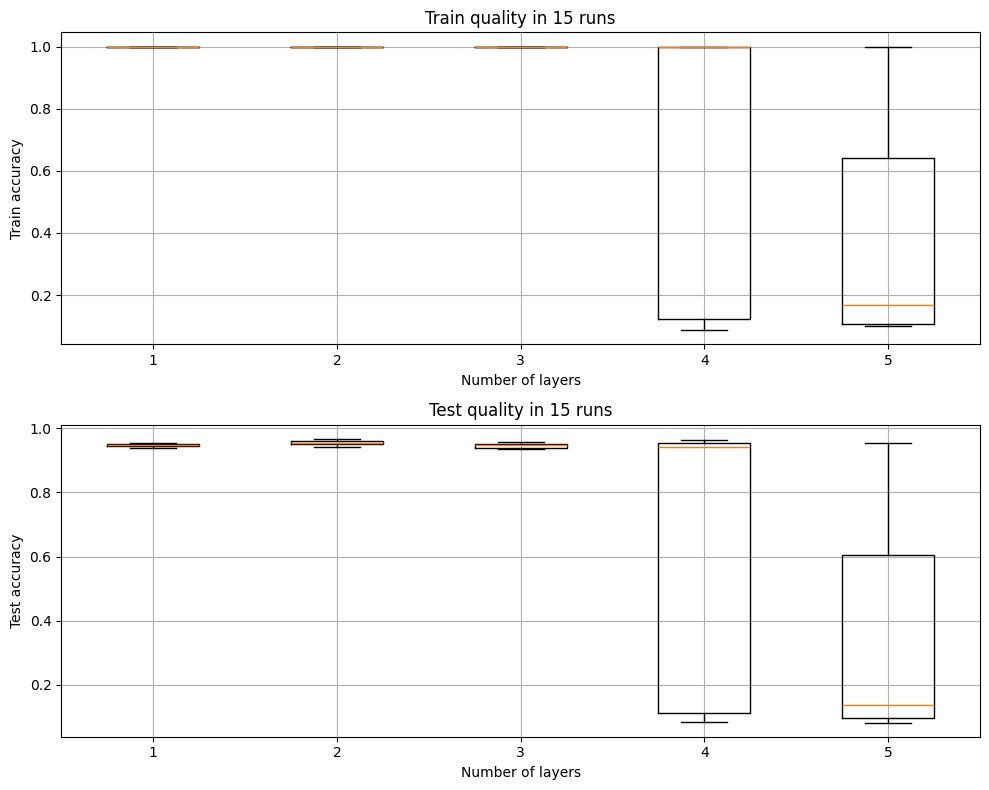

In [54]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].boxplot(accs_train.T, showfliers=False)
axes[1].boxplot(accs_test.T, showfliers=False)

axes[0].set_xlabel("Number of layers")
axes[1].set_xlabel("Number of layers")

axes[0].set_ylabel("Train accuracy")
axes[1].set_ylabel("Test accuracy")

axes[0].set_title(f"Train quality in {N} runs")
axes[1].set_title(f"Test quality in {N} runs")

axes[0].grid(True)
axes[1].grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):

- Как изменяются качество на обучении и контроле и устойчивость процесса обучения при увеличении числа слоев?
- Можно ли сказать, что логистическая регрессия (линейная модель) дает качество хуже, чем нелинейная модель?

**Ответы:**

Рассмотрим диаграмму обучения. Явно видно, что модели, начиная с однослойной логистической регрессии смогли достич максимального accuracy га обучающей выборке (то есть 1.0). Однако такой тренд не имеет место быть на всех моделя: так уже для четырехслойной архитектуры появляются такие модели, что имеют очень посредственное качество. На примере четырех и в особенности пятислойной архитектуры явно видно уже переобучение сложных нейросетевых моделей: обучающей выборки при такой размерности данных просто недостаточно, чтобы тонко настроить все слои, а потому сеть начинает подстраиваться под обучение и сваливаться в тесте.

На тестовой же выборке лучшим образом показала себя двухслойная архитектура, имея максимальное в среднем и почти минимальное (после модели лин. легрессии) по разбросуразбросу качество на контроле. Для четырех и пятислойных моделей выводы с тестовой выборки распространяются и на тестовую $\Rightarrow$ им свойственно переобучение

При этом нельзя назвать линейную однослойную модель логистической регрессии сильно слабее двуслойной: на обучении они смогли достичь максимальных результатов, а на тесте их показатели отличаются минимально. Все же линейная регрессия ведет себя более устойчиво на обучении, имея меньший разброс по качеству. В то же время двухслойная архитектура все же мощнее, показывая большую обобщающую способность в среднем.


### `Эксперименты c различными инициализациями весов (0.6 балла)`


Как уже было сказано, начальная инициализация весов нейронной сети может сильно влиять на процесс ее обучения и, как следствие, на ее качество.

В этом пункте вам предлагается попробовать обучить несколько нейронных сетей с различными инициализациями слоев.

Для этого необходимо реализовать функцию, инициализирующую веса линейных слоёв нашей нейронной сети. Добавьте в функционал данного метода возможность инициализировать его веса с помощью инициализации Kaiming (используется, если в нейронной сети в качестве функций активации используется ReLU) и инициализации Xavier (используется, если в нейронной сети в качестве функций активации используется Tanh или Sigmoid):


In [23]:
def initialize_network(network, initialization):
    for layer in network:
        if isinstance(layer, Dense):
            input_units, output_units = layer.weights.shape
            if initialization == 'Kaiming':
                layer.weights = np.random.normal(
                    loc=0, scale=2 / output_units, size=(input_units, output_units))

            elif initialization == 'Xavier':
                layer.weights = np.random.normal(
                    loc=0, scale=1 / output_units, size=(input_units, output_units))
            else:
                # Initialize weights with small random numbers from normal distribution.
                # In this case `initialization` represents a standard deviation
                # for normal distribution.
                layer.weights = np.random.randn(
                    input_units, output_units) * initialization
            layer.biases = np.zeros_like(layer.biases)

            layer.params = [layer.weights, layer.biases]

Теперь попробуйте для каждой из 3 инициализаций обучить нейронную сеть несколько раз. Попробуйте проделать данную операцию при зафиксированном числе слоев равным 3, 4 и 5.


#### `3 слоя`

Зафиксируйте в сети число слоев равное трем.


Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети при $j$-м запуске (все запуски идентичны) с инициализацией Kaiming при $i = 3$, с инициализацией Xavier при $i = 4$ и с инициализацией из нормального распределения с фиксированными параметрами при $0 \leqslant i \leqslant 2$ (попробуйте здесь 3 разных параметра для стандартного отклонения для нормального распределения, например: `1e-3`, `1e-2`, `1e-1`). Заметьте, что при большом числе слоев слишком низкое стандартное отклонение может не давать нейронной сети нормально обучиться.


In [126]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [127]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [ ]:
def add_stats(train, test, i, j):
    accs_train[i][j] = train
    accs_test[i][j] = test


def train_model(network, i, j):
    weights = get_weights(network)

    res = minimize(
        compute_loss_grad, weights,
        args=[network, X_train, y_train],
        method="L-BFGS-B",
        jac=True)

    set_weights(res['x'], network)

    preds_train = predict(network, X_train)
    preds_test = predict(network, X_test)
    train_accuracy = accuracy_score(y_train, preds_train)
    test_accuracy = accuracy_score(y_test, preds_test)

    add_stats(train_accuracy, test_accuracy, i, j)


for i, init in enumerate(init_vars):
    for j in range(5):
        network = [
            Dense(64, 32),
            ReLU(),
            Dense(32, 16),
            ReLU(),
            Dense(16, 10),
            LogSoftmax()
        ]

        initialize_network(network, init)

        train_model(network, i, j)

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).


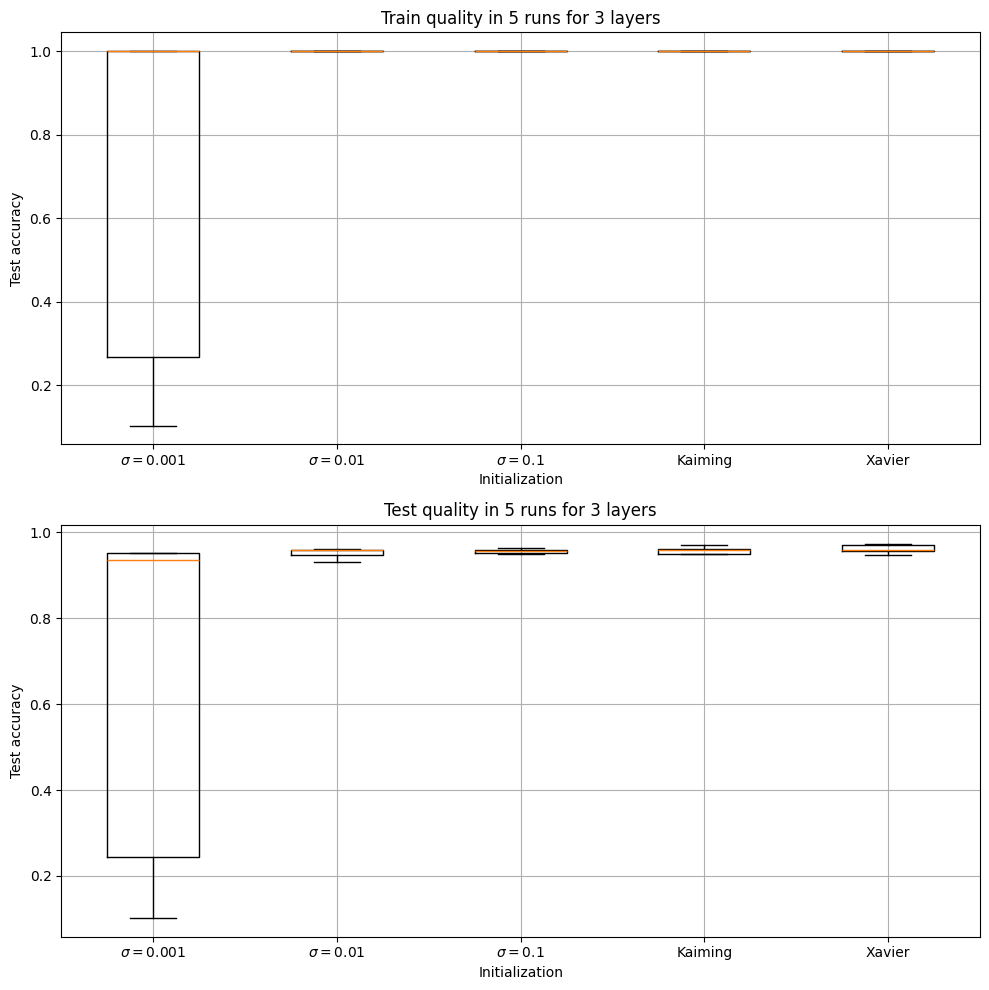

In [81]:
init_vars_for_plot = [
    (x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].boxplot(accs_train.T, labels=init_vars_for_plot, showfliers=False)

ax[0].set_title("Train quality in 5 runs for 3 layers")
ax[0].set_xlabel("Initialization")
ax[0].set_ylabel("Test accuracy")
ax[0].grid(True)


ax[1].boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax[1].set_title("Test quality in 5 runs for 3 layers")
ax[1].set_xlabel("Initialization")
ax[1].set_ylabel("Test accuracy")
ax[1].grid(True)

fig.tight_layout()
plt.show()

#### `4 слоя`

Выполните тут тот же код, что и в предыдущем пункте, но только уже с 4 слоями в сети.


In [129]:
init_vars = [5e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [130]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [131]:
def add_stats(train, test, i, j):
    accs_train[i][j] = train
    accs_test[i][j] = test


def train_model(network, i, j):
    weights = get_weights(network)

    res = minimize(
        compute_loss_grad, weights,
        args=[network, X_train, y_train],
        method="L-BFGS-B",
        jac=True)

    set_weights(res['x'], network)

    preds_train = predict(network, X_train)
    preds_test = predict(network, X_test)
    train_accuracy = accuracy_score(y_train, preds_train)
    test_accuracy = accuracy_score(y_test, preds_test)

    add_stats(train_accuracy, test_accuracy, i, j)


for i, init in enumerate(init_vars):
    for j in range(5):
        network = [
            Dense(64, 32),
            ReLU(),
            Dense(32, 32),
            ReLU(),
            Dense(32, 32),
            ReLU(),
            Dense(32, 10),
            LogSoftmax()
        ]

        initialize_network(network, init)

        train_model(network, i, j)

/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:26: RuntimeWarning: overflow encountered in exp
  X = np.exp(self.input).astype(np.float64)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:30: RuntimeWarning: invalid value encountered in multiply
  grad = grad_output - sum_init * X / sum_exp
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:30: RuntimeWarning: invalid value encountered in divide
  grad = grad_output - sum_init * X / sum_exp
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:26: RuntimeWarning: overflow encountered in exp
  X = np.exp(self.input).astype(np.float64)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:30: RuntimeWarning: invalid value encountered in multiply
  grad = grad_output - sum_init * X / sum_exp
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:30: RuntimeWarning: invalid valu

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).


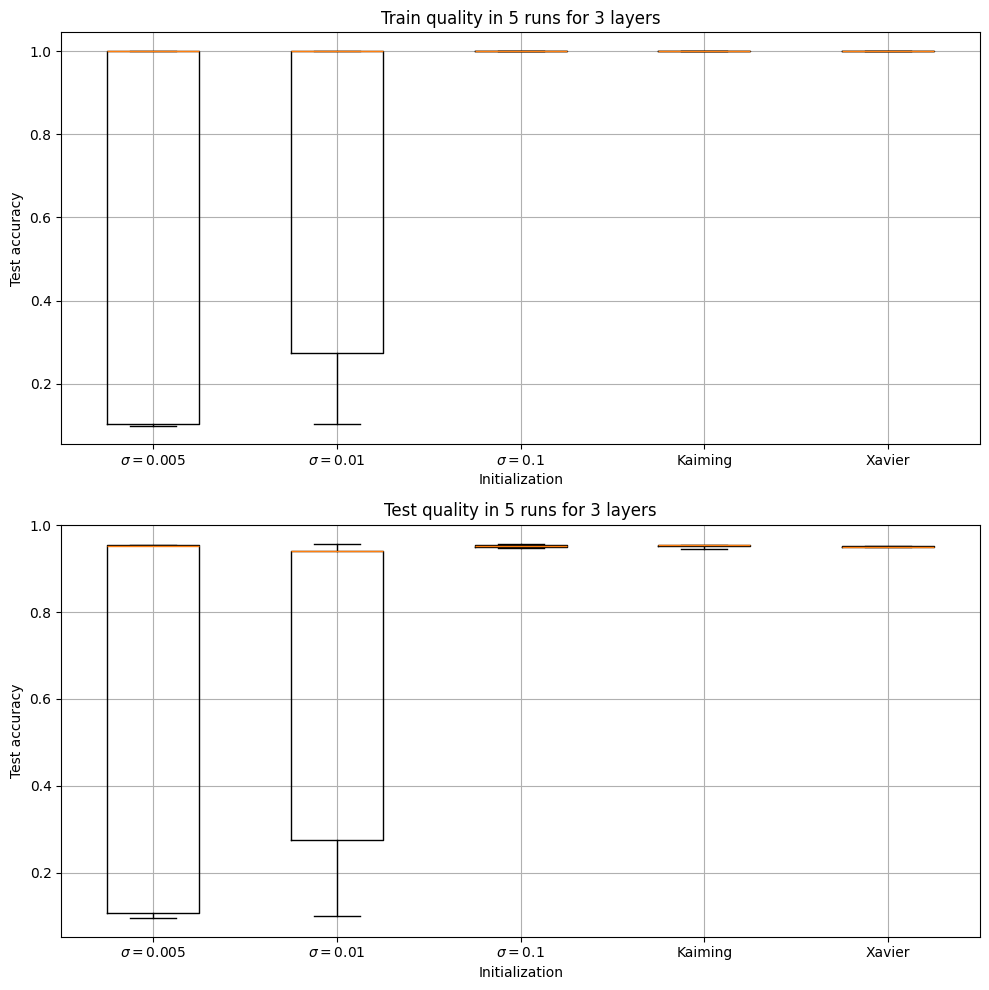

In [132]:
init_vars_for_plot = [
    (x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].boxplot(accs_train.T, labels=init_vars_for_plot, showfliers=False)

ax[0].set_title("Train quality in 5 runs for 3 layers")
ax[0].set_xlabel("Initialization")
ax[0].set_ylabel("Test accuracy")
ax[0].grid(True)


ax[1].boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax[1].set_title("Test quality in 5 runs for 3 layers")
ax[1].set_xlabel("Initialization")
ax[1].set_ylabel("Test accuracy")
ax[1].grid(True)

fig.tight_layout()
plt.show()

#### `5 слоев`

Выполните тут тот же код, что и в предыдущем пункте, но только уже с 5 слоями в сети.


In [133]:
init_vars = [1e-2, 1e-1, 1e0, 'Kaiming', 'Xavier']

In [134]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [135]:
def add_stats(train, test, i, j):
    accs_train[i][j] = train
    accs_test[i][j] = test


def train_model(network, i, j):
    weights = get_weights(network)

    res = minimize(
        compute_loss_grad, weights,
        args=[network, X_train, y_train],
        method="L-BFGS-B",
        jac=True)

    set_weights(res['x'], network)

    preds_train = predict(network, X_train)
    preds_test = predict(network, X_test)
    train_accuracy = accuracy_score(y_train, preds_train)
    test_accuracy = accuracy_score(y_test, preds_test)

    add_stats(train_accuracy, test_accuracy, i, j)


for i, init in enumerate(init_vars):
    for j in range(5):
        network = [
            Dense(64, 50),
            ReLU(),
            Dense(50, 40),
            ReLU(),
            Dense(40, 30),
            ReLU(),
            Dense(30, 20),
            ReLU(),
            Dense(20, 10),
            LogSoftmax()
        ]

        initialize_network(network, init)

        train_model(network, i, j)

/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:26: RuntimeWarning: overflow encountered in exp
  X = np.exp(self.input).astype(np.float64)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:30: RuntimeWarning: invalid value encountered in multiply
  grad = grad_output - sum_init * X / sum_exp
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:26: RuntimeWarning: overflow encountered in exp
  X = np.exp(self.input).astype(np.float64)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:30: RuntimeWarning: invalid value encountered in multiply
  grad = grad_output - sum_init * X / sum_exp
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:30: RuntimeWarning: invalid value encountered in divide
  grad = grad_output - sum_init * X / sum_exp
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:26: RuntimeWarning: overflow enc

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).


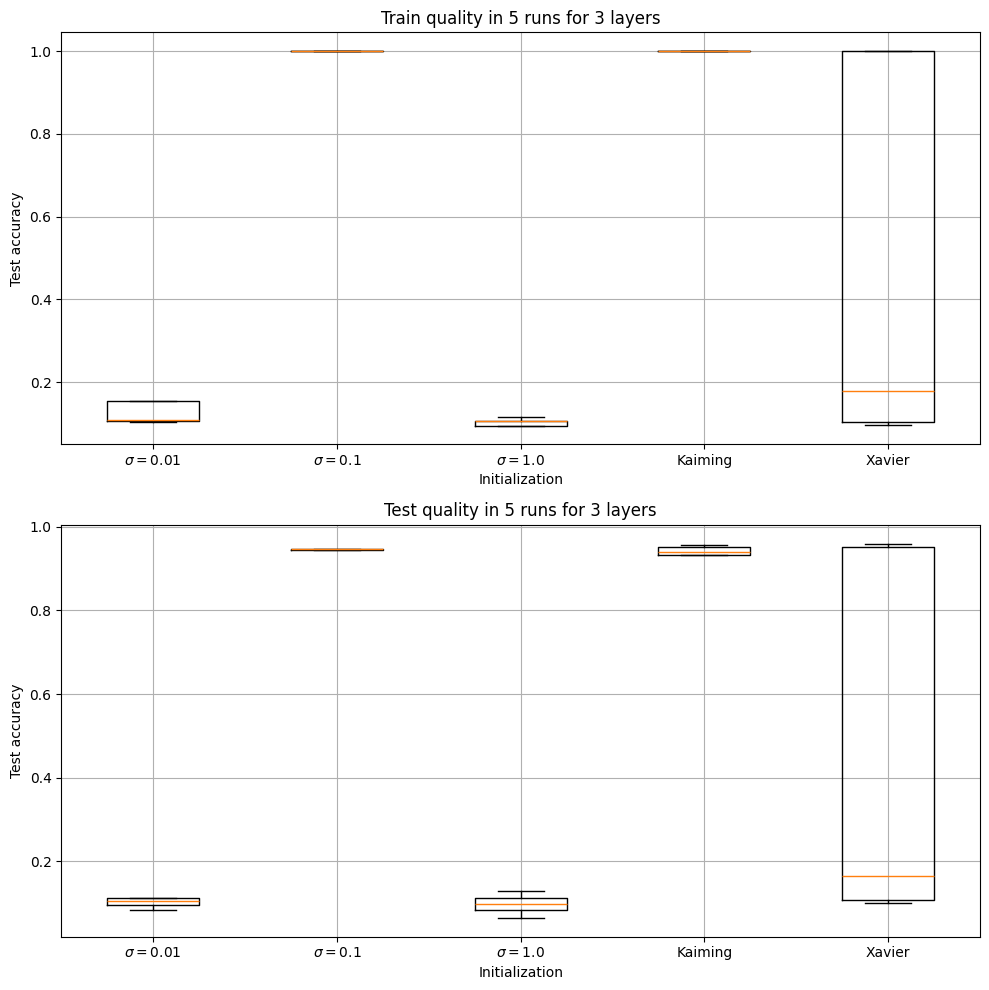

In [136]:
init_vars_for_plot = [
    (x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].boxplot(accs_train.T, labels=init_vars_for_plot, showfliers=False)

ax[0].set_title("Train quality in 5 runs for 3 layers")
ax[0].set_xlabel("Initialization")
ax[0].set_ylabel("Test accuracy")
ax[0].grid(True)


ax[1].boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax[1].set_title("Test quality in 5 runs for 3 layers")
ax[1].set_xlabel("Initialization")
ax[1].set_ylabel("Test accuracy")
ax[1].grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):

- Как отличаются качество на обучении и контроле и устойчивость процесса обучения при различных инициализациях?
- Какие инициализации помогают обучать более глубокие сети?

**Ответы:**

1. Самыми непредсказуемыми в плане конечного качества после обучения представляется именно инициализация весов при помощи случайного нормального распределения без учета расмерности слоев. Так, самой плохой себя показала инициализация весов распределением $N(0, 10^{-3})$, что стабильно выдавало наихудшие результаты на каждой из архитектур. Причиной такого служит недообученность сетки, из-за крайне малых весов и, как следствие, малых градиентов и значений параметра на прямом прогоне. Тем самым видно, что нейросети обладают всеми видами проблем даже на адекватных по размерам выборках $Rightarrow$ переобучением и недообучением. Для больших дисперсий ситуация иногда может казаться лучше, однако они выглядят крайне нестабильными в глобальном слысле (от сетки к сетке). С другой же стороны, два осмысленных способа инициализации: Кайминга и Ксавьера - показывают себя много лучше: они более устойчивы, но итут с оговорками. Можно увидеть, что инициализация Ксавьером все так же зависит от архитектуры (а точнее от числа слоев сети). Так качество на 5 слойной в среднем крайне плохо, хотя на предыдущих архитектурах оно показывало себя много лучше. Инициализация Кайминга в этом плане оказалось лучше всех остальных: для любой архитектуры в среднем Кайминг стоит в лидерах или же даже возглавляет модели.
2. Видно, что модели, показывающие сравнимое качество на обучении с единицей, выдают и соизмеримые с единицей показатели на тесте, что говорит о большой обощающей способности алгоритмов полносвязных сетей в целом.
3. Видно, что для больших моделей успешнее всего использовать именно Кайминговую инициализацию, ведь только в таком случае для любой архитектуры результаты в среднем наблюдается вблизи единицы и с минимальным разбросом.


Теперь сравним скорость обучения при различных инициализациях. Создайте два списка списков `accs_test_on_iterations`, `accs_train_on_iterations` в каждом из которых в позиции `[i]` (см. описание `i` в предыдущем пункте) будет лежать список из значений `accuracy` на тестовой и обучающей выборках соотвественно, полученных во время обучения модели. Количество слоев в сети зафиксируйте равным 4.


In [37]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [34]:
accs_test_on_iterations = []
accs_train_on_iterations = []


def train_model(network, i, j):
    weights = get_weights(network)
    cb = Callback(network, X_train, y_train, X_test, y_test, print=False)

    res = minimize(
        compute_loss_grad, weights,
        args=[network, X_train, y_train],
        method="L-BFGS-B",
        callback=cb.call,
        jac=True)

    accs_test_on_iterations.append(cb.test_acc)
    accs_train_on_iterations.append(cb.train_acc)


for i, init in enumerate(init_vars):
    for j in range(1):
        network = [
            Dense(64, 40),
            ReLU(),
            Dense(40, 20),
            ReLU(),
            Dense(20, 20),
            ReLU(),
            Dense(20, 16),
            LogSoftmax()
        ]

        initialize_network(network, init)

        train_model(network, i, j)

/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:26: RuntimeWarning: overflow encountered in exp
  X = np.exp(self.input).astype(np.float64)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:30: RuntimeWarning: invalid value encountered in divide
  grad = grad_output - sum_init * X / sum_exp
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:26: RuntimeWarning: overflow encountered in exp
  X = np.exp(self.input).astype(np.float64)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:30: RuntimeWarning: invalid value encountered in multiply
  grad = grad_output - sum_init * X / sum_exp
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/1838013661.py:30: RuntimeWarning: invalid value encountered in divide
  grad = grad_output - sum_init * X / sum_exp


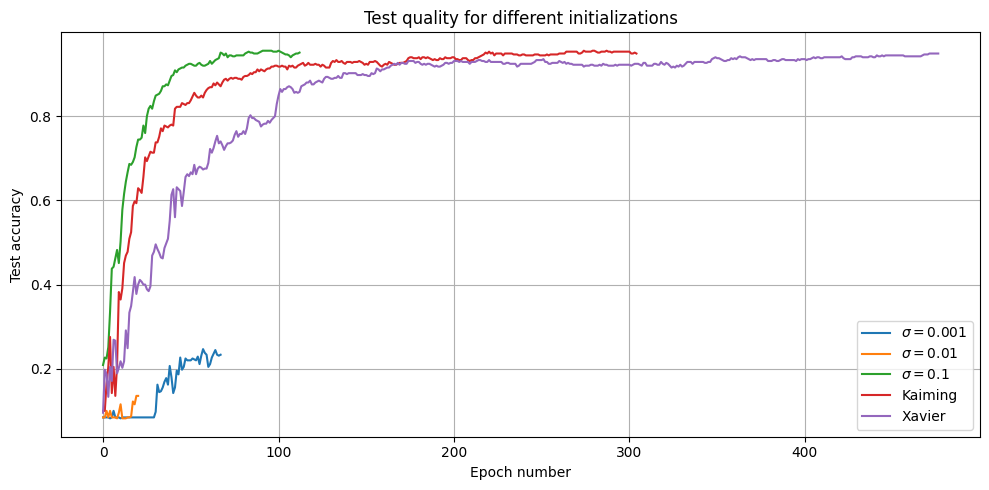

In [39]:
init_vars_for_plot = [
    (x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for idx, label in enumerate(init_vars_for_plot):
    ax.plot(accs_test_on_iterations[idx], label=label)

ax.set_title("Test quality for different initializations")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Test accuracy")
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):

- Как меняется скорость обучения в зависимости от выбранной инициализации?

**Ответы:**

В экспериментах использовалось условие выхода из процесса обучения при малом изменении loss'а. Потому мы можем видеть как сети с различной инициализацией обучались различное время. Потому оценка каждой инициализации дожнка проводиться на основе времени, затрачиваемом на обучение, а так же и итогового качества. Видно, что хуже всего себя показали сети с самыми малыми дисперсиями весов вслоях, что по озвученной ранее причине сигнализирует о недообученности сети. Им сложно покинуть стартовую точку и добиться хорошего качества, так как их активация и прокидываение градиента слишком малы на каждой из итераций. Сравнимые показатели получили инициализации с дисперисей по Каймингу и с показателем 0.1. При этом Инициализация с дисперисией в 0.1 быстрее смогла достигнуть плато по качестве, когда методу Кайминга пришлось потратить в 2 раза больше итераций. Но при том устойчивость обучения дл инициализации по Каймингу много выше, чем для метода с большой дисперсией (нет явных скачков качества вверх или вниз). Объясняется это тем, что инициализация специально по Каймингу была подогнана так, чтобы не вызывать взрывов или затуханий градиента.

Метод Ксавьера же работал дольше всех, вышел на предел итераций и все так же не смог достигнуть эталонного качества, как два предыдущих метода. Это говорит о меньшей приспособленности метода Ксавьера для задач с ReLU активацией


### `Эксперименты c различными функциями активации (0.6 балла)`


Проверим теперь, с какой функцией активации нейронная сеть будет обучаться лучше.

В этом пункте вам предлагается попробовать обучить несколько нейронных сетей с различными функциями активации.

Для этого нам нужно реализовать еще 2 слоя: для функций активации `Tanh` и `Sigmoid`.


In [28]:
class Tanh:
    """
    tanh(y) = (e^y - e^(-y)) / (e^y + e^(-y))
    Используйте функцию np.tanh для подсчета гиперболического тангенса.
    Вы можете сами реализовать подсчет tanh, но тогда вам нужно устойчиво его вычислять.
    """

    def __init__(self):
        self.params = []  # Tanh has no parameters

    def forward(self, input):
        """
        Apply elementwise Tanh to [batch, num_units] matrix
        """
        self.input = input
        return np.tanh(input)

    def backward(self, grad_output):
        """
        Compute gradient of loss w.r.t. Tanh input
        grad_output shape: [batch, num_units]
        output 1 shape: [batch, num_units]
        output 2: []
        """
        # your code here
        exp = np.exp(self.input * 2)
        grad = (4 * exp) / ((exp + 1) ** 2)

        return grad_output * grad, []

    def __repr__(self):
        return 'Tanh()'

проверим tanh(X)


In [105]:
n = 50
d = 10
thn = Tanh()
target = np.random.choice(d, size=n)
points = np.random.uniform(-1, 1, n*d).reshape([n, d])

# your code here


def get_loss(x):
    return np.sum(thn.forward(x))


# analitical grad
_ = thn.forward(points)
grads = thn.backward(np.ones_like(points))[0]

# numeric grad
numeric_grads = eval_numerical_gradient(get_loss, points)

# ic(thn.forward(points))
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

In [29]:
from scipy.special import expit


class Sigmoid:
    """
    sigmoid(y) = 1 / (1 + e^(-y))
    Используйте функцию expit для подсчета сигмоиды.
    Вы можете сами реализовать подсчет сигмоиды, но тогда вам нужно устойчиво ее вычислять.
    """

    def __init__(self):
        self.params = []  # Sigmoid has no parameters

    def forward(self, input):
        """
        Apply elementwise Sigmoid to [batch, num_units] matrix
        """
        self.input = input
        return expit(input)

    def backward(self, grad_output):
        """
        Compute gradient of loss w.r.t. Sigmoid input
        grad_output shape: [batch, num_units]
        output 1 shape: [batch, num_units]
        output 2: []
        """
        return grad_output * np.exp(-self.input) * (expit(self.input) ** 2), []

    def __repr__(self):
        return 'Sigmoid()'

проверим sigmoid(X)


In [112]:
n = 50
d = 10
sigm = Sigmoid()
target = np.random.choice(d, size=n)
points = np.random.uniform(-1, 1, n*d).reshape([n, d])

# your code here


def get_loss(x):
    return np.sum(sigm.forward(x))


# analitical grad
_ = sigm.forward(points)
grads = sigm.backward(np.ones_like(points))[0]

# numeric grad
numeric_grads = eval_numerical_gradient(get_loss, points)

# ic(thn.forward(points))
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

Теперь попробуйте для каждой из 3 функций активации обучить нейронную сеть несколько раз. Число слоев зафиксируйте равным 3. В случае `Tanh` и `Sigmoid` используйте инициализацию `Xavier`, а в случае `ReLU` используйте инициализацию `Kaiming`.


Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети при $j$-м запуске (все запуски идентичны) с функцией активации $ReLU$ при $i = 0$, с функцией активации $Tanh$ при $i = 1$ и с функцией активации $Sigmoid$ при $i = 2$.


In [113]:
act_func_vars = ['Tanh', 'Sigmoid', 'ReLU']
init_for_act_funcs = ['Xavier', 'Xavier', 'Kaiming']

In [119]:
accs_train = np.zeros((3, 5))
accs_test = np.zeros((3, 5))

In [123]:
def add_stats(train, test, i, j):
    accs_train[i][j] = train
    accs_test[i][j] = test


def train_model(network, i, j):
    weights = get_weights(network)

    res = minimize(
        compute_loss_grad, weights,
        args=[network, X_train, y_train],
        method="L-BFGS-B",
        jac=True)

    set_weights(res['x'], network)

    preds_train = predict(network, X_train)
    preds_test = predict(network, X_test)
    train_accuracy = accuracy_score(y_train, preds_train)
    test_accuracy = accuracy_score(y_test, preds_test)

    add_stats(train_accuracy, test_accuracy, i, j)


for i, (init, activation) in tqdm(enumerate(zip(['Xavier', 'Xavier', 'Kaiming'], [Sigmoid, Tanh, ReLU])), total=3x):
    for j in range(5):
        network = [
            Dense(64, 32),
            activation(),
            Dense(32, 16),
            activation(),
            Dense(16, 10),
            LogSoftmax()
        ]

        initialize_network(network, init)

        train_model(network, i, j)

  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/3232814281.py:27: RuntimeWarning: overflow encountered in square
  grad = (4 * exp) / ((exp + 1) ** 2)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/3232814281.py:27: RuntimeWarning: overflow encountered in multiply
  grad = (4 * exp) / ((exp + 1) ** 2)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/3232814281.py:27: RuntimeWarning: invalid value encountered in divide
  grad = (4 * exp) / ((exp + 1) ** 2)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/3232814281.py:26: RuntimeWarning: overflow encountered in exp
  exp = np.exp(self.input * 2)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/3232814281.py:27: RuntimeWarning: overflow encountered in square
  grad = (4 * exp) / ((exp + 1) ** 2)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_21126/3232814281.py:26: RuntimeWarning: overflow encountered in exp

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).


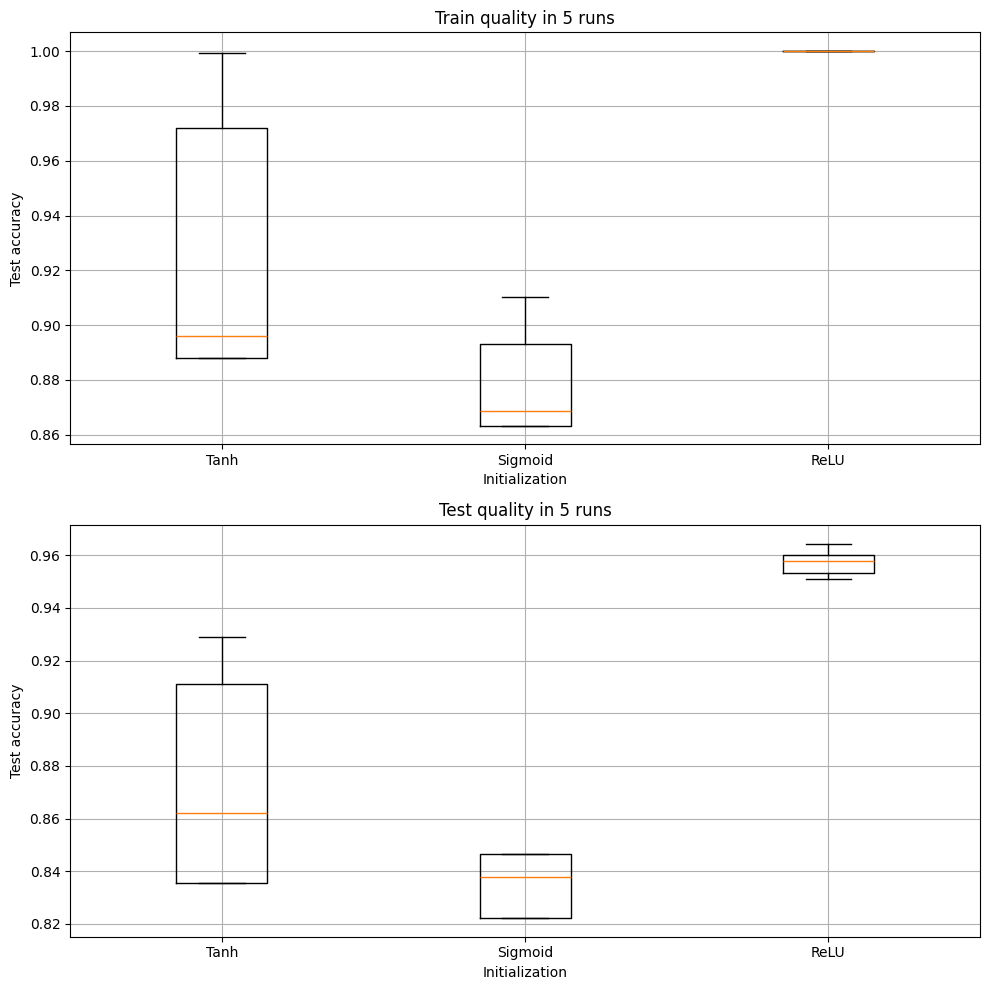

In [125]:
init_vars_for_plot = [
    (x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].boxplot(accs_train.T, labels=act_func_vars, showfliers=False)

ax[0].set_title("Train quality in 5 runs")
ax[0].set_xlabel("Initialization")
ax[0].set_ylabel("Test accuracy")
ax[0].grid(True)


ax[1].boxplot(accs_test.T, labels=act_func_vars, showfliers=False)

ax[1].set_title("Test quality in 5 runs")
ax[1].set_xlabel("Initialization")
ax[1].set_ylabel("Test accuracy")
ax[1].grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):

- Как отличаются качество на обучении и контроле и устойчивость процесса обучения при различных функциях активации?

**Ответы:**

Рассмотрим две группы функций активации: Tanh/sigmoid и ReLU - как состоящие из принципиально разных базовых функций. Первая группа Tanh/sigmoid под состоит из экспонент, при чем Tanh является только лишь отмасштабированной и сдивнутой версией сигмоиды. Обе этих функции имеют существенный недостаток: их градиент ограничен константой меньше единицы, а на бесконечности градиент по функции активации равен нулю. У тангенса ситуация четь лучше, что и отражается на графиках, где он показывает в среднем лучшее качество, однако он не идет ни в какое сравнение с ReLU. Благодаря отличию в том, что ReLU не приводит к затуханию градиента, мы видим резкий отрыв по качеству. Это говорит о том, что плохое качество моделей с Tanh/sigmoid вызвано недообученностью из-за затухания градиента

Так же стоит отметить, что для всех трех функций активации свойтсвенно то, что тестовое качество и качество на трейне относительно схожи. При чем для всех функций активации разброс на трейне и на тесте среди обучаемых моделей практически одинаков. Что говорит о хорошей обощающей способностью моделей в среднем


\* Несколько фрагментов кода в задании написаны на основе материалов [курса по глубинному обучению на ФКН НИУ ВШЭ](https://www.hse.ru/ba/ami/courses/205504078.html)


### `Реализация метода оптимизации (1.4 балла)`


В этой части задания реализуйте метод оптимизации SGD + momentum. Упрощённая версия более общего алгоритма [отсюда](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html):

$$
\begin{aligned}
    &\rule{70mm}{0.4pt}                                                             \\
    &\textbf{input}      : \gamma \text{ (lr)}, \: \theta_0 \text{ (params)}, \: X \text{ (data)},       \\
    &\hspace{13mm} \: f(\theta) \text{ (objective)}, \:\mu \text{ (momentum)}       \\[-1.ex]
    &\rule{70mm}{0.4pt}                                                             \\
    &\textbf{for} \: t=1 \: \textbf{to} \: \ldots \: \textbf{do}                    \\
    &\hspace{5mm}\mathcal{X} \leftarrow \texttt{list\_of\_random\_batches}(X)\\
    &\hspace{5mm}\textbf{for} \: i=1 \: \textbf{to} \: \ldots \: \textbf{do}                    \\
    &\hspace{10mm}g_t\leftarrow   \nabla_{\theta} f_t (\theta_{t-1},\mathcal{X}_i)      \\
    &\hspace{10mm}\textbf{if} \: \mu \neq 0                                          \\
    &\hspace{15mm}\textbf{if} \: t > 1                                              \\
    &\hspace{20mm} \textbf{b}_t \leftarrow \mu \textbf{b}_{t-1} + g_t               \\
    &\hspace{15mm}\textbf{else}                                                     \\
    &\hspace{20mm} \textbf{b}_t \leftarrow g_t                                      \\
    &\hspace{15mm} g_t  \leftarrow  \textbf{b}_t                                     \\
    &\hspace{10mm}\theta_t \leftarrow \theta_{t-1} - \gamma g_t                      \\[-1.ex]
    &\rule{70mm}{0.4pt}                                                             \\[-1.ex]
    &\bf{return} \:  \theta_t                                                       \\[-1.ex]
    &\rule{70mm}{0.4pt}                                                             \\[-1.ex]
\end{aligned}
$$

Проще всего будет написать `custom minimizer` (смотри [документацию scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)).


In [24]:
from scipy.optimize import OptimizeResult


def SGD(fun, x0, args, **kwargs) -> OptimizeResult:
    # feed weights from each iteration to update network and log metrics
    callback = kwargs['callback']
    mu = kwargs['momentum']
    n_iter = kwargs['n_iter']
    gamma = kwargs['lr']
    jac = kwargs['jac']
    batch_size = kwargs['batch_size']
    min_margin = kwargs['min_margin']if \
        'min_margin' in kwargs.keys() else 1e-5
    random_state = kwargs['random_state'] if \
        'random_state' in kwargs.keys() else 42

    net, X, y = args[0]
    weights = x0
    batch_num = len(X) * batch_size

    np.random.seed(random_state)

    if mu:
        b = np.zeros_like(x0)

    prev_loss = 0

    # your code is here
    for _ in range(n_iter):
        ranger = range(ceil(1 / batch_size)) if isinstance(batch_num,
                                                           float) else range(ceil(X.shape[0] / batch_size))

        for i in ranger:
            if isinstance(batch_num, float):
                X_batch = X[int(batch_num * i): int(batch_num * (i + 1)), :]
                y_batch = y[int(batch_num * i): int(batch_num * (i + 1))]
            else:
                X_batch = X[int(batch_size * i): int(batch_size * (i + 1)), :]
                y_batch = y[int(batch_size * i): int(batch_size * (i + 1))]

            loss, grad = compute_loss_grad(weights, (net, X_batch, y_batch))

            if mu:
                b = mu * b + (1 - mu) * grad
                grad = b

            weights = weights - gamma * grad

        callback(weights)

        if min_margin and abs(prev_loss - loss) < min_margin:
            break
        else:
            prev_loss = loss

    return OptimizeResult(x=weights,
                          success=loss < 0.9,
                          status=0,
                          nit=n_iter)

**Задание 1. (0.5 балла)** Продемонстрируйте правильную работу метода оптимизации, получив `test_accuracy>=0.9`.


In [ ]:
from scipy.optimize import minimize

network = [
    Dense(64, 32),
    ReLU(),
    Dense(32, 10),
    LogSoftmax()
]

cb = Callback(network, X_train, y_train, X_test, y_test, print=False)

initialize_network(network, 'Kaiming')
weights = get_weights(network)

res = minimize(
    compute_loss_grad, weights,
    args=[network, X_train, y_train],
    method=SGD,
    callback=cb.call,
    options={
        'momentum': 0.3,
        'n_iter': 50,
        'lr': 0.01,
        'batch_size': 0.1,
        'random_state': 42
    },
    jac=True)

print(f'final train score -> {cb.train_acc[-1]
                              } \nand final test dcore -> {cb.test_acc[-1]}')
assert cb.test_acc[-1] > 0.9
print('challenge is done')

**Задание 2. (0.8 балла)** Сравните три алгоритма:

1. LBFGS-B
2. SGD
3. SGD + momentum

Для этого одновременно переберите следующие гиперпараметры:

- значения `lr` на отрезке `[1e-3, 1e-1]` по логарифмической сетке
- два значения `momentum`: `0` и `0.9`
- значения `batch_size`: `8` и `32`

В каждом запуске сохраняйте три метрики: итоговое accuracy на тесте и на трейне и время обучения.

Для каждого из трёх алгоритмов выберите лучшие `lr` и `batch_size` по `test_accuracy`. Постройте для них кривые обучения (пример ниже). Сделайте выводы.


<?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg xmlns:xlink="http://www.w3.org/1999/xlink" width="394.423125pt" height="325.986375pt" viewBox="0 0 394.423125 325.986375" xmlns="http://www.w3.org/2000/svg" version="1.1">
 <metadata>
  <rdf:RDF xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:cc="http://creativecommons.org/ns#" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">
   <cc:Work>
    <dc:type rdf:resource="http://purl.org/dc/dcmitype/StillImage"/>
    <dc:date>2024-02-19T01:35:50.340267</dc:date>
    <dc:format>image/svg+xml</dc:format>
    <dc:creator>
     <cc:Agent>
      <dc:title>Matplotlib v3.8.2, https://matplotlib.org/</dc:title>
     </cc:Agent>
    </dc:creator>
   </cc:Work>
  </rdf:RDF>
 </metadata>
 <defs>
  <style type="text/css">*{stroke-linejoin: round; stroke-linecap: butt}</style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 325.986375 
L 394.423125 325.986375 
L 394.423125 0 
L 0 0 
z
" style="fill: #ffffff"/>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 30.103125 288.430125 
L 387.223125 288.430125 
L 387.223125 22.318125 
L 30.103125 22.318125 
z
" style="fill: #ffffff"/>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <path d="M 46.335852 288.430125 
L 46.335852 22.318125 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #cccccc; stroke-width: 0.8; stroke-linecap: round"/>
     </g>
     <g id="text_1">
      <!-- 0 -->
      <g style="fill: #262626" transform="translate(43.154602 303.028562) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-30" d="M 2034 4250 
Q 1547 4250 1301 3770 
Q 1056 3291 1056 2328 
Q 1056 1369 1301 889 
Q 1547 409 2034 409 
Q 2525 409 2770 889 
Q 3016 1369 3016 2328 
Q 3016 3291 2770 3770 
Q 2525 4250 2034 4250 
z
M 2034 4750 
Q 2819 4750 3233 4129 
Q 3647 3509 3647 2328 
Q 3647 1150 3233 529 
Q 2819 -91 2034 -91 
Q 1250 -91 836 529 
Q 422 1150 422 2328 
Q 422 3509 836 4129 
Q 1250 4750 2034 4750 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-30"/>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_2">
      <path d="M 116.912927 288.430125 
L 116.912927 22.318125 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #cccccc; stroke-width: 0.8; stroke-linecap: round"/>
     </g>
     <g id="text_2">
      <!-- 20 -->
      <g style="fill: #262626" transform="translate(110.550427 303.028562) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-32" d="M 1228 531 
L 3431 531 
L 3431 0 
L 469 0 
L 469 531 
Q 828 903 1448 1529 
Q 2069 2156 2228 2338 
Q 2531 2678 2651 2914 
Q 2772 3150 2772 3378 
Q 2772 3750 2511 3984 
Q 2250 4219 1831 4219 
Q 1534 4219 1204 4116 
Q 875 4013 500 3803 
L 500 4441 
Q 881 4594 1212 4672 
Q 1544 4750 1819 4750 
Q 2544 4750 2975 4387 
Q 3406 4025 3406 3419 
Q 3406 3131 3298 2873 
Q 3191 2616 2906 2266 
Q 2828 2175 2409 1742 
Q 1991 1309 1228 531 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-32"/>
       <use xlink:href="#DejaVuSans-30" x="63.623047"/>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_3">
      <path d="M 187.490002 288.430125 
L 187.490002 22.318125 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #cccccc; stroke-width: 0.8; stroke-linecap: round"/>
     </g>
     <g id="text_3">
      <!-- 40 -->
      <g style="fill: #262626" transform="translate(181.127502 303.028562) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-34" d="M 2419 4116 
L 825 1625 
L 2419 1625 
L 2419 4116 
z
M 2253 4666 
L 3047 4666 
L 3047 1625 
L 3713 1625 
L 3713 1100 
L 3047 1100 
L 3047 0 
L 2419 0 
L 2419 1100 
L 313 1100 
L 313 1709 
L 2253 4666 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-34"/>
       <use xlink:href="#DejaVuSans-30" x="63.623047"/>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_4">
      <path d="M 258.067078 288.430125 
L 258.067078 22.318125 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #cccccc; stroke-width: 0.8; stroke-linecap: round"/>
     </g>
     <g id="text_4">
      <!-- 60 -->
      <g style="fill: #262626" transform="translate(251.704578 303.028562) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-36" d="M 2113 2584 
Q 1688 2584 1439 2293 
Q 1191 2003 1191 1497 
Q 1191 994 1439 701 
Q 1688 409 2113 409 
Q 2538 409 2786 701 
Q 3034 994 3034 1497 
Q 3034 2003 2786 2293 
Q 2538 2584 2113 2584 
z
M 3366 4563 
L 3366 3988 
Q 3128 4100 2886 4159 
Q 2644 4219 2406 4219 
Q 1781 4219 1451 3797 
Q 1122 3375 1075 2522 
Q 1259 2794 1537 2939 
Q 1816 3084 2150 3084 
Q 2853 3084 3261 2657 
Q 3669 2231 3669 1497 
Q 3669 778 3244 343 
Q 2819 -91 2113 -91 
Q 1303 -91 875 529 
Q 447 1150 447 2328 
Q 447 3434 972 4092 
Q 1497 4750 2381 4750 
Q 2619 4750 2861 4703 
Q 3103 4656 3366 4563 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-36"/>
       <use xlink:href="#DejaVuSans-30" x="63.623047"/>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_5">
      <path d="M 328.644153 288.430125 
L 328.644153 22.318125 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #cccccc; stroke-width: 0.8; stroke-linecap: round"/>
     </g>
     <g id="text_5">
      <!-- 80 -->
      <g style="fill: #262626" transform="translate(322.281653 303.028562) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-38" d="M 2034 2216 
Q 1584 2216 1326 1975 
Q 1069 1734 1069 1313 
Q 1069 891 1326 650 
Q 1584 409 2034 409 
Q 2484 409 2743 651 
Q 3003 894 3003 1313 
Q 3003 1734 2745 1975 
Q 2488 2216 2034 2216 
z
M 1403 2484 
Q 997 2584 770 2862 
Q 544 3141 544 3541 
Q 544 4100 942 4425 
Q 1341 4750 2034 4750 
Q 2731 4750 3128 4425 
Q 3525 4100 3525 3541 
Q 3525 3141 3298 2862 
Q 3072 2584 2669 2484 
Q 3125 2378 3379 2068 
Q 3634 1759 3634 1313 
Q 3634 634 3220 271 
Q 2806 -91 2034 -91 
Q 1263 -91 848 271 
Q 434 634 434 1313 
Q 434 1759 690 2068 
Q 947 2378 1403 2484 
z
M 1172 3481 
Q 1172 3119 1398 2916 
Q 1625 2713 2034 2713 
Q 2441 2713 2670 2916 
Q 2900 3119 2900 3481 
Q 2900 3844 2670 4047 
Q 2441 4250 2034 4250 
Q 1625 4250 1398 4047 
Q 1172 3844 1172 3481 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-38"/>
       <use xlink:href="#DejaVuSans-30" x="63.623047"/>
      </g>
     </g>
    </g>
    <g id="text_6">
     <!-- epochs -->
     <g style="fill: #262626" transform="translate(190.830313 316.706687) scale(0.1 -0.1)">
      <defs>
       <path id="DejaVuSans-65" d="M 3597 1894 
L 3597 1613 
L 953 1613 
Q 991 1019 1311 708 
Q 1631 397 2203 397 
Q 2534 397 2845 478 
Q 3156 559 3463 722 
L 3463 178 
Q 3153 47 2828 -22 
Q 2503 -91 2169 -91 
Q 1331 -91 842 396 
Q 353 884 353 1716 
Q 353 2575 817 3079 
Q 1281 3584 2069 3584 
Q 2775 3584 3186 3129 
Q 3597 2675 3597 1894 
z
M 3022 2063 
Q 3016 2534 2758 2815 
Q 2500 3097 2075 3097 
Q 1594 3097 1305 2825 
Q 1016 2553 972 2059 
L 3022 2063 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-70" d="M 1159 525 
L 1159 -1331 
L 581 -1331 
L 581 3500 
L 1159 3500 
L 1159 2969 
Q 1341 3281 1617 3432 
Q 1894 3584 2278 3584 
Q 2916 3584 3314 3078 
Q 3713 2572 3713 1747 
Q 3713 922 3314 415 
Q 2916 -91 2278 -91 
Q 1894 -91 1617 61 
Q 1341 213 1159 525 
z
M 3116 1747 
Q 3116 2381 2855 2742 
Q 2594 3103 2138 3103 
Q 1681 3103 1420 2742 
Q 1159 2381 1159 1747 
Q 1159 1113 1420 752 
Q 1681 391 2138 391 
Q 2594 391 2855 752 
Q 3116 1113 3116 1747 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-6f" d="M 1959 3097 
Q 1497 3097 1228 2736 
Q 959 2375 959 1747 
Q 959 1119 1226 758 
Q 1494 397 1959 397 
Q 2419 397 2687 759 
Q 2956 1122 2956 1747 
Q 2956 2369 2687 2733 
Q 2419 3097 1959 3097 
z
M 1959 3584 
Q 2709 3584 3137 3096 
Q 3566 2609 3566 1747 
Q 3566 888 3137 398 
Q 2709 -91 1959 -91 
Q 1206 -91 779 398 
Q 353 888 353 1747 
Q 353 2609 779 3096 
Q 1206 3584 1959 3584 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-63" d="M 3122 3366 
L 3122 2828 
Q 2878 2963 2633 3030 
Q 2388 3097 2138 3097 
Q 1578 3097 1268 2742 
Q 959 2388 959 1747 
Q 959 1106 1268 751 
Q 1578 397 2138 397 
Q 2388 397 2633 464 
Q 2878 531 3122 666 
L 3122 134 
Q 2881 22 2623 -34 
Q 2366 -91 2075 -91 
Q 1284 -91 818 406 
Q 353 903 353 1747 
Q 353 2603 823 3093 
Q 1294 3584 2113 3584 
Q 2378 3584 2631 3529 
Q 2884 3475 3122 3366 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-68" d="M 3513 2113 
L 3513 0 
L 2938 0 
L 2938 2094 
Q 2938 2591 2744 2837 
Q 2550 3084 2163 3084 
Q 1697 3084 1428 2787 
Q 1159 2491 1159 1978 
L 1159 0 
L 581 0 
L 581 4863 
L 1159 4863 
L 1159 2956 
Q 1366 3272 1645 3428 
Q 1925 3584 2291 3584 
Q 2894 3584 3203 3211 
Q 3513 2838 3513 2113 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-73" d="M 2834 3397 
L 2834 2853 
Q 2591 2978 2328 3040 
Q 2066 3103 1784 3103 
Q 1356 3103 1142 2972 
Q 928 2841 928 2578 
Q 928 2378 1081 2264 
Q 1234 2150 1697 2047 
L 1894 2003 
Q 2506 1872 2764 1633 
Q 3022 1394 3022 966 
Q 3022 478 2636 193 
Q 2250 -91 1575 -91 
Q 1294 -91 989 -36 
Q 684 19 347 128 
L 347 722 
Q 666 556 975 473 
Q 1284 391 1588 391 
Q 1994 391 2212 530 
Q 2431 669 2431 922 
Q 2431 1156 2273 1281 
Q 2116 1406 1581 1522 
L 1381 1569 
Q 847 1681 609 1914 
Q 372 2147 372 2553 
Q 372 3047 722 3315 
Q 1072 3584 1716 3584 
Q 2034 3584 2315 3537 
Q 2597 3491 2834 3397 
z
" transform="scale(0.015625)"/>
      </defs>
      <use xlink:href="#DejaVuSans-65"/>
      <use xlink:href="#DejaVuSans-70" x="61.523438"/>
      <use xlink:href="#DejaVuSans-6f" x="125"/>
      <use xlink:href="#DejaVuSans-63" x="186.181641"/>
      <use xlink:href="#DejaVuSans-68" x="241.162109"/>
      <use xlink:href="#DejaVuSans-73" x="304.541016"/>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_6">
      <path d="M 30.103125 286.998812 
L 387.223125 286.998812 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #cccccc; stroke-width: 0.8; stroke-linecap: round"/>
     </g>
     <g id="text_7">
      <!-- 0.0 -->
      <g style="fill: #262626" transform="translate(7.2 290.798031) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-2e" d="M 684 794 
L 1344 794 
L 1344 0 
L 684 0 
L 684 794 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-30" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_7">
      <path d="M 30.103125 236.481874 
L 387.223125 236.481874 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #cccccc; stroke-width: 0.8; stroke-linecap: round"/>
     </g>
     <g id="text_8">
      <!-- 0.2 -->
      <g style="fill: #262626" transform="translate(7.2 240.281093) scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-32" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_8">
      <path d="M 30.103125 185.964937 
L 387.223125 185.964937 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #cccccc; stroke-width: 0.8; stroke-linecap: round"/>
     </g>
     <g id="text_9">
      <!-- 0.4 -->
      <g style="fill: #262626" transform="translate(7.2 189.764156) scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-34" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_9">
      <path d="M 30.103125 135.448 
L 387.223125 135.448 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #cccccc; stroke-width: 0.8; stroke-linecap: round"/>
     </g>
     <g id="text_10">
      <!-- 0.6 -->
      <g style="fill: #262626" transform="translate(7.2 139.247218) scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-36" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_10">
      <path d="M 30.103125 84.931062 
L 387.223125 84.931062 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #cccccc; stroke-width: 0.8; stroke-linecap: round"/>
     </g>
     <g id="text_11">
      <!-- 0.8 -->
      <g style="fill: #262626" transform="translate(7.2 88.730281) scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-38" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_6">
     <g id="line2d_11">
      <path d="M 30.103125 34.414125 
L 387.223125 34.414125 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #cccccc; stroke-width: 0.8; stroke-linecap: round"/>
     </g>
     <g id="text_12">
      <!-- 1.0 -->
      <g style="fill: #262626" transform="translate(7.2 38.213344) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-31" d="M 794 531 
L 1825 531 
L 1825 4091 
L 703 3866 
L 703 4441 
L 1819 4666 
L 2450 4666 
L 2450 531 
L 3481 531 
L 3481 0 
L 794 0 
L 794 531 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-31"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-30" x="95.410156"/>
      </g>
     </g>
    </g>
   </g>
   <g id="line2d_12">
    <path d="M 46.335852 276.334125 
L 49.864706 265.669438 
L 53.39356 236.481874 
L 56.922414 128.712408 
L 60.451267 61.356492 
L 63.980121 68.653383 
L 67.508975 49.569206 
L 71.037829 54.6209 
L 74.566682 54.6209 
L 78.095536 50.691805 
L 81.62439 48.446608 
L 85.153244 50.130506 
L 88.682097 47.324009 
L 92.210951 43.394914 
L 95.739805 43.394914 
L 99.268659 49.007907 
L 102.797512 49.007907 
L 106.326366 54.059601 
L 109.85522 43.394914 
L 113.384074 45.078812 
L 116.912927 42.272315 
L 120.441781 41.149717 
L 123.970635 39.465819 
L 127.499489 39.465819 
L 131.028342 38.904519 
L 134.557196 38.904519 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #1f77b4; stroke-width: 1.5; stroke-linecap: round"/>
   </g>
   <g id="line2d_13">
    <path d="M 46.335852 272.935076 
L 49.864706 260.183956 
L 53.39356 228.493673 
L 56.922414 123.109416 
L 60.451267 56.353552 
L 63.980121 62.541596 
L 67.508975 48.102827 
L 71.037829 48.665377 
L 74.566682 48.852893 
L 78.095536 39.47707 
L 81.62439 42.477333 
L 85.153244 41.164718 
L 88.682097 37.789421 
L 92.210951 35.914257 
L 95.739805 37.789421 
L 99.268659 41.914784 
L 102.797512 40.977201 
L 106.326366 45.85263 
L 109.85522 36.101773 
L 113.384074 34.601641 
L 116.912927 35.164191 
L 120.441781 34.414125 
L 123.970635 34.414125 
L 127.499489 34.414125 
L 131.028342 34.414125 
L 134.557196 34.414125 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #ff7f0e; stroke-width: 1.5; stroke-linecap: round"/>
   </g>
   <g id="line2d_14">
    <path d="M 46.335852 260.056445 
L 49.864706 215.152501 
L 53.39356 116.925123 
L 56.922414 92.227953 
L 60.451267 64.162988 
L 63.980121 47.885308 
L 67.508975 46.20141 
L 71.037829 46.20141 
L 74.566682 45.640111 
L 78.095536 43.394914 
L 81.62439 41.711016 
L 85.153244 40.027118 
L 88.682097 43.394914 
L 92.210951 47.324009 
L 95.739805 44.517512 
L 99.268659 49.569206 
L 102.797512 53.498301 
L 106.326366 42.272315 
L 109.85522 42.272315 
L 113.384074 42.833615 
L 116.912927 57.988696 
L 120.441781 40.588417 
L 123.970635 41.711016 
L 127.499489 42.272315 
L 131.028342 40.588417 
L 134.557196 41.711016 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #2ca02c; stroke-width: 1.5; stroke-linecap: round"/>
   </g>
   <g id="line2d_15">
    <path d="M 46.335852 261.871605 
L 49.864706 202.803916 
L 53.39356 112.79601 
L 56.922414 86.356188 
L 60.451267 58.60375 
L 63.980121 42.477333 
L 67.508975 41.164718 
L 71.037829 39.852103 
L 74.566682 40.602169 
L 78.095536 37.414389 
L 81.62439 36.101773 
L 85.153244 36.664323 
L 88.682097 37.601905 
L 92.210951 40.977201 
L 95.739805 37.039356 
L 99.268659 42.1023 
L 102.797512 48.102827 
L 106.326366 36.664323 
L 109.85522 35.164191 
L 113.384074 35.164191 
L 116.912927 55.791003 
L 120.441781 35.914257 
L 123.970635 34.789158 
L 127.499489 34.414125 
L 131.028342 34.601641 
L 134.557196 34.414125 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #d62728; stroke-width: 1.5; stroke-linecap: round"/>
   </g>
   <g id="line2d_16">
    <path d="M 46.335852 250.514357 
L 49.864706 264.54684 
L 53.39356 264.54684 
L 56.922414 247.146561 
L 60.451267 232.552779 
L 63.980121 222.449392 
L 67.508975 230.307582 
L 71.037829 202.242617 
L 74.566682 187.648835 
L 78.095536 171.371155 
L 81.62439 175.30025 
L 85.153244 164.074264 
L 88.682097 145.551387 
L 92.210951 143.867489 
L 95.739805 123.099415 
L 99.268659 114.118626 
L 102.797512 102.331341 
L 106.326366 101.770041 
L 109.85522 97.279647 
L 113.384074 91.105355 
L 116.912927 86.61496 
L 120.441781 78.75677 
L 123.970635 74.266376 
L 127.499489 73.143777 
L 131.028342 69.214682 
L 134.557196 68.653383 
L 138.08605 67.530784 
L 141.614904 64.162988 
L 145.143757 65.285587 
L 148.672611 63.601689 
L 152.201465 61.917791 
L 155.730319 60.233893 
L 159.259172 60.233893 
L 162.788026 56.866097 
L 166.31688 57.427396 
L 169.845734 56.866097 
L 173.374587 55.182199 
L 176.903441 55.743499 
L 180.432295 55.743499 
L 183.961149 52.937002 
L 187.490002 51.814403 
L 191.018856 53.498301 
L 194.54771 50.691805 
L 198.076564 47.885308 
L 201.605417 46.76271 
L 205.134271 47.324009 
L 208.663125 45.078812 
L 212.191979 44.517512 
L 215.720833 44.517512 
L 219.249686 45.640111 
L 222.77854 46.20141 
L 226.307394 46.20141 
L 229.836248 46.20141 
L 233.365101 45.640111 
L 236.893955 46.20141 
L 240.422809 45.640111 
L 243.951663 47.324009 
L 247.480516 46.20141 
L 251.00937 46.20141 
L 254.538224 46.76271 
L 258.067078 47.324009 
L 261.595931 47.885308 
L 265.124785 48.446608 
L 268.653639 47.324009 
L 272.182493 46.20141 
L 275.711346 46.20141 
L 279.2402 45.078812 
L 282.769054 45.640111 
L 286.297908 45.640111 
L 289.826761 45.078812 
L 293.355615 45.640111 
L 296.884469 45.078812 
L 300.413323 44.517512 
L 303.942176 43.956213 
L 307.47103 43.956213 
L 310.999884 43.956213 
L 314.528738 44.517512 
L 318.057591 44.517512 
L 321.586445 44.517512 
L 325.115299 45.078812 
L 328.644153 44.517512 
L 332.173006 44.517512 
L 335.70186 45.640111 
L 339.230714 45.078812 
L 342.759568 45.640111 
L 346.288421 45.640111 
L 349.817275 46.20141 
L 353.346129 46.20141 
L 356.874983 46.20141 
L 360.403836 46.20141 
L 363.93269 46.20141 
L 367.461544 46.20141 
L 370.990398 46.20141 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #9467bd; stroke-width: 1.5; stroke-linecap: round"/>
   </g>
   <g id="line2d_17">
    <path d="M 46.335852 238.057013 
L 49.864706 259.246374 
L 53.39356 259.246374 
L 56.922414 241.994859 
L 60.451267 222.680662 
L 63.980121 213.492355 
L 67.508975 228.11864 
L 71.037829 201.866334 
L 74.566682 179.73939 
L 78.095536 163.237941 
L 81.62439 160.050161 
L 85.153244 149.549238 
L 88.682097 133.047789 
L 92.210951 129.297459 
L 95.739805 113.358559 
L 99.268659 107.545549 
L 102.797512 99.857373 
L 106.326366 96.85711 
L 109.85522 92.731748 
L 113.384074 85.418605 
L 116.912927 78.668012 
L 120.441781 75.480232 
L 123.970635 70.79232 
L 127.499489 70.604804 
L 131.028342 68.917156 
L 134.557196 66.854475 
L 138.08605 63.854211 
L 141.614904 60.291398 
L 145.143757 59.916365 
L 148.672611 57.478651 
L 152.201465 55.791003 
L 155.730319 56.166036 
L 159.259172 54.85342 
L 162.788026 52.978256 
L 166.31688 50.915574 
L 169.845734 50.915574 
L 173.374587 50.165509 
L 176.903441 47.915311 
L 180.432295 47.165245 
L 183.961149 46.602696 
L 187.490002 43.414916 
L 191.018856 44.352498 
L 194.54771 42.66485 
L 198.076564 41.914784 
L 201.605417 41.727267 
L 205.134271 41.727267 
L 208.663125 40.414652 
L 212.191979 40.039619 
L 215.720833 39.102037 
L 219.249686 38.91452 
L 222.77854 37.976938 
L 226.307394 37.226872 
L 229.836248 37.226872 
L 233.365101 36.476806 
L 236.893955 36.664323 
L 240.422809 36.28929 
L 243.951663 35.72674 
L 247.480516 35.351707 
L 251.00937 35.351707 
L 254.538224 35.164191 
L 258.067078 34.976674 
L 261.595931 34.789158 
L 265.124785 34.789158 
L 268.653639 34.601641 
L 272.182493 34.601641 
L 275.711346 34.789158 
L 279.2402 34.789158 
L 282.769054 34.789158 
L 286.297908 34.414125 
L 289.826761 34.414125 
L 293.355615 34.414125 
L 296.884469 34.414125 
L 300.413323 34.414125 
L 303.942176 34.414125 
L 307.47103 34.414125 
L 310.999884 34.414125 
L 314.528738 34.414125 
L 318.057591 34.414125 
L 321.586445 34.414125 
L 325.115299 34.414125 
L 328.644153 34.414125 
L 332.173006 34.414125 
L 335.70186 34.414125 
L 339.230714 34.414125 
L 342.759568 34.414125 
L 346.288421 34.414125 
L 349.817275 34.414125 
L 353.346129 34.414125 
L 356.874983 34.414125 
L 360.403836 34.414125 
L 363.93269 34.414125 
L 367.461544 34.414125 
L 370.990398 34.414125 
" clip-path="url(#p7966c48f6b)" style="fill: none; stroke: #8c564b; stroke-width: 1.5; stroke-linecap: round"/>
   </g>
   <g id="patch_3">
    <path d="M 30.103125 288.430125 
L 30.103125 22.318125 
" style="fill: none; stroke: #cccccc; stroke-width: 0.8; stroke-linejoin: miter; stroke-linecap: square"/>
   </g>
   <g id="patch_4">
    <path d="M 387.223125 288.430125 
L 387.223125 22.318125 
" style="fill: none; stroke: #cccccc; stroke-width: 0.8; stroke-linejoin: miter; stroke-linecap: square"/>
   </g>
   <g id="patch_5">
    <path d="M 30.103125 288.430125 
L 387.223125 288.430125 
" style="fill: none; stroke: #cccccc; stroke-width: 0.8; stroke-linejoin: miter; stroke-linecap: square"/>
   </g>
   <g id="patch_6">
    <path d="M 30.103125 22.318125 
L 387.223125 22.318125 
" style="fill: none; stroke: #cccccc; stroke-width: 0.8; stroke-linejoin: miter; stroke-linecap: square"/>
   </g>
   <g id="text_13">
    <!-- SGD vs SGD + momentum vs LBFGS -->
    <g style="fill: #262626" transform="translate(98.461875 16.318125) scale(0.12 -0.12)">
     <defs>
      <path id="DejaVuSans-53" d="M 3425 4513 
L 3425 3897 
Q 3066 4069 2747 4153 
Q 2428 4238 2131 4238 
Q 1616 4238 1336 4038 
Q 1056 3838 1056 3469 
Q 1056 3159 1242 3001 
Q 1428 2844 1947 2747 
L 2328 2669 
Q 3034 2534 3370 2195 
Q 3706 1856 3706 1288 
Q 3706 609 3251 259 
Q 2797 -91 1919 -91 
Q 1588 -91 1214 -16 
Q 841 59 441 206 
L 441 856 
Q 825 641 1194 531 
Q 1563 422 1919 422 
Q 2459 422 2753 634 
Q 3047 847 3047 1241 
Q 3047 1584 2836 1778 
Q 2625 1972 2144 2069 
L 1759 2144 
Q 1053 2284 737 2584 
Q 422 2884 422 3419 
Q 422 4038 858 4394 
Q 1294 4750 2059 4750 
Q 2388 4750 2728 4690 
Q 3069 4631 3425 4513 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-47" d="M 3809 666 
L 3809 1919 
L 2778 1919 
L 2778 2438 
L 4434 2438 
L 4434 434 
Q 4069 175 3628 42 
Q 3188 -91 2688 -91 
Q 1594 -91 976 548 
Q 359 1188 359 2328 
Q 359 3472 976 4111 
Q 1594 4750 2688 4750 
Q 3144 4750 3555 4637 
Q 3966 4525 4313 4306 
L 4313 3634 
Q 3963 3931 3569 4081 
Q 3175 4231 2741 4231 
Q 1884 4231 1454 3753 
Q 1025 3275 1025 2328 
Q 1025 1384 1454 906 
Q 1884 428 2741 428 
Q 3075 428 3337 486 
Q 3600 544 3809 666 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-44" d="M 1259 4147 
L 1259 519 
L 2022 519 
Q 2988 519 3436 956 
Q 3884 1394 3884 2338 
Q 3884 3275 3436 3711 
Q 2988 4147 2022 4147 
L 1259 4147 
z
M 628 4666 
L 1925 4666 
Q 3281 4666 3915 4102 
Q 4550 3538 4550 2338 
Q 4550 1131 3912 565 
Q 3275 0 1925 0 
L 628 0 
L 628 4666 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-20" transform="scale(0.015625)"/>
      <path id="DejaVuSans-76" d="M 191 3500 
L 800 3500 
L 1894 563 
L 2988 3500 
L 3597 3500 
L 2284 0 
L 1503 0 
L 191 3500 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-2b" d="M 2944 4013 
L 2944 2272 
L 4684 2272 
L 4684 1741 
L 2944 1741 
L 2944 0 
L 2419 0 
L 2419 1741 
L 678 1741 
L 678 2272 
L 2419 2272 
L 2419 4013 
L 2944 4013 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-6d" d="M 3328 2828 
Q 3544 3216 3844 3400 
Q 4144 3584 4550 3584 
Q 5097 3584 5394 3201 
Q 5691 2819 5691 2113 
L 5691 0 
L 5113 0 
L 5113 2094 
Q 5113 2597 4934 2840 
Q 4756 3084 4391 3084 
Q 3944 3084 3684 2787 
Q 3425 2491 3425 1978 
L 3425 0 
L 2847 0 
L 2847 2094 
Q 2847 2600 2669 2842 
Q 2491 3084 2119 3084 
Q 1678 3084 1418 2786 
Q 1159 2488 1159 1978 
L 1159 0 
L 581 0 
L 581 3500 
L 1159 3500 
L 1159 2956 
Q 1356 3278 1631 3431 
Q 1906 3584 2284 3584 
Q 2666 3584 2933 3390 
Q 3200 3197 3328 2828 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-6e" d="M 3513 2113 
L 3513 0 
L 2938 0 
L 2938 2094 
Q 2938 2591 2744 2837 
Q 2550 3084 2163 3084 
Q 1697 3084 1428 2787 
Q 1159 2491 1159 1978 
L 1159 0 
L 581 0 
L 581 3500 
L 1159 3500 
L 1159 2956 
Q 1366 3272 1645 3428 
Q 1925 3584 2291 3584 
Q 2894 3584 3203 3211 
Q 3513 2838 3513 2113 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-74" d="M 1172 4494 
L 1172 3500 
L 2356 3500 
L 2356 3053 
L 1172 3053 
L 1172 1153 
Q 1172 725 1289 603 
Q 1406 481 1766 481 
L 2356 481 
L 2356 0 
L 1766 0 
Q 1100 0 847 248 
Q 594 497 594 1153 
L 594 3053 
L 172 3053 
L 172 3500 
L 594 3500 
L 594 4494 
L 1172 4494 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-75" d="M 544 1381 
L 544 3500 
L 1119 3500 
L 1119 1403 
Q 1119 906 1312 657 
Q 1506 409 1894 409 
Q 2359 409 2629 706 
Q 2900 1003 2900 1516 
L 2900 3500 
L 3475 3500 
L 3475 0 
L 2900 0 
L 2900 538 
Q 2691 219 2414 64 
Q 2138 -91 1772 -91 
Q 1169 -91 856 284 
Q 544 659 544 1381 
z
M 1991 3584 
L 1991 3584 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-4c" d="M 628 4666 
L 1259 4666 
L 1259 531 
L 3531 531 
L 3531 0 
L 628 0 
L 628 4666 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-42" d="M 1259 2228 
L 1259 519 
L 2272 519 
Q 2781 519 3026 730 
Q 3272 941 3272 1375 
Q 3272 1813 3026 2020 
Q 2781 2228 2272 2228 
L 1259 2228 
z
M 1259 4147 
L 1259 2741 
L 2194 2741 
Q 2656 2741 2882 2914 
Q 3109 3088 3109 3444 
Q 3109 3797 2882 3972 
Q 2656 4147 2194 4147 
L 1259 4147 
z
M 628 4666 
L 2241 4666 
Q 2963 4666 3353 4366 
Q 3744 4066 3744 3513 
Q 3744 3084 3544 2831 
Q 3344 2578 2956 2516 
Q 3422 2416 3680 2098 
Q 3938 1781 3938 1306 
Q 3938 681 3513 340 
Q 3088 0 2303 0 
L 628 0 
L 628 4666 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-46" d="M 628 4666 
L 3309 4666 
L 3309 4134 
L 1259 4134 
L 1259 2759 
L 3109 2759 
L 3109 2228 
L 1259 2228 
L 1259 0 
L 628 0 
L 628 4666 
z
" transform="scale(0.015625)"/>
     </defs>
     <use xlink:href="#DejaVuSans-53"/>
     <use xlink:href="#DejaVuSans-47" x="63.476562"/>
     <use xlink:href="#DejaVuSans-44" x="140.966797"/>
     <use xlink:href="#DejaVuSans-20" x="217.96875"/>
     <use xlink:href="#DejaVuSans-76" x="249.755859"/>
     <use xlink:href="#DejaVuSans-73" x="308.935547"/>
     <use xlink:href="#DejaVuSans-20" x="361.035156"/>
     <use xlink:href="#DejaVuSans-53" x="392.822266"/>
     <use xlink:href="#DejaVuSans-47" x="456.298828"/>
     <use xlink:href="#DejaVuSans-44" x="533.789062"/>
     <use xlink:href="#DejaVuSans-20" x="610.791016"/>
     <use xlink:href="#DejaVuSans-2b" x="642.578125"/>
     <use xlink:href="#DejaVuSans-20" x="726.367188"/>
     <use xlink:href="#DejaVuSans-6d" x="758.154297"/>
     <use xlink:href="#DejaVuSans-6f" x="855.566406"/>
     <use xlink:href="#DejaVuSans-6d" x="916.748047"/>
     <use xlink:href="#DejaVuSans-65" x="1014.160156"/>
     <use xlink:href="#DejaVuSans-6e" x="1075.683594"/>
     <use xlink:href="#DejaVuSans-74" x="1139.0625"/>
     <use xlink:href="#DejaVuSans-75" x="1178.271484"/>
     <use xlink:href="#DejaVuSans-6d" x="1241.650391"/>
     <use xlink:href="#DejaVuSans-20" x="1339.0625"/>
     <use xlink:href="#DejaVuSans-76" x="1370.849609"/>
     <use xlink:href="#DejaVuSans-73" x="1430.029297"/>
     <use xlink:href="#DejaVuSans-20" x="1482.128906"/>
     <use xlink:href="#DejaVuSans-4c" x="1513.916016"/>
     <use xlink:href="#DejaVuSans-42" x="1569.628906"/>
     <use xlink:href="#DejaVuSans-46" x="1638.232422"/>
     <use xlink:href="#DejaVuSans-47" x="1695.751953"/>
     <use xlink:href="#DejaVuSans-53" x="1773.242188"/>
    </g>
   </g>
   <g id="legend_1">
    <g id="patch_7">
     <path d="M 187.53875 283.430125 
L 380.223125 283.430125 
Q 382.223125 283.430125 382.223125 281.430125 
L 382.223125 194.361375 
Q 382.223125 192.361375 380.223125 192.361375 
L 187.53875 192.361375 
Q 185.53875 192.361375 185.53875 194.361375 
L 185.53875 281.430125 
Q 185.53875 283.430125 187.53875 283.430125 
z
" style="fill: #ffffff; opacity: 0.8; stroke: #cccccc; stroke-linejoin: miter"/>
    </g>
    <g id="line2d_18">
     <path d="M 189.53875 200.459812 
L 199.53875 200.459812 
L 209.53875 200.459812 
" style="fill: none; stroke: #1f77b4; stroke-width: 1.5; stroke-linecap: round"/>
    </g>
    <g id="text_14">
     <!-- test SGD + momentum [0.982] -->
     <g style="fill: #262626" transform="translate(217.53875 203.959812) scale(0.1 -0.1)">
      <defs>
       <path id="DejaVuSans-5b" d="M 550 4863 
L 1875 4863 
L 1875 4416 
L 1125 4416 
L 1125 -397 
L 1875 -397 
L 1875 -844 
L 550 -844 
L 550 4863 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-39" d="M 703 97 
L 703 672 
Q 941 559 1184 500 
Q 1428 441 1663 441 
Q 2288 441 2617 861 
Q 2947 1281 2994 2138 
Q 2813 1869 2534 1725 
Q 2256 1581 1919 1581 
Q 1219 1581 811 2004 
Q 403 2428 403 3163 
Q 403 3881 828 4315 
Q 1253 4750 1959 4750 
Q 2769 4750 3195 4129 
Q 3622 3509 3622 2328 
Q 3622 1225 3098 567 
Q 2575 -91 1691 -91 
Q 1453 -91 1209 -44 
Q 966 3 703 97 
z
M 1959 2075 
Q 2384 2075 2632 2365 
Q 2881 2656 2881 3163 
Q 2881 3666 2632 3958 
Q 2384 4250 1959 4250 
Q 1534 4250 1286 3958 
Q 1038 3666 1038 3163 
Q 1038 2656 1286 2365 
Q 1534 2075 1959 2075 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-5d" d="M 1947 4863 
L 1947 -844 
L 622 -844 
L 622 -397 
L 1369 -397 
L 1369 4416 
L 622 4416 
L 622 4863 
L 1947 4863 
z
" transform="scale(0.015625)"/>
      </defs>
      <use xlink:href="#DejaVuSans-74"/>
      <use xlink:href="#DejaVuSans-65" x="39.208984"/>
      <use xlink:href="#DejaVuSans-73" x="100.732422"/>
      <use xlink:href="#DejaVuSans-74" x="152.832031"/>
      <use xlink:href="#DejaVuSans-20" x="192.041016"/>
      <use xlink:href="#DejaVuSans-53" x="223.828125"/>
      <use xlink:href="#DejaVuSans-47" x="287.304688"/>
      <use xlink:href="#DejaVuSans-44" x="364.794922"/>
      <use xlink:href="#DejaVuSans-20" x="441.796875"/>
      <use xlink:href="#DejaVuSans-2b" x="473.583984"/>
      <use xlink:href="#DejaVuSans-20" x="557.373047"/>
      <use xlink:href="#DejaVuSans-6d" x="589.160156"/>
      <use xlink:href="#DejaVuSans-6f" x="686.572266"/>
      <use xlink:href="#DejaVuSans-6d" x="747.753906"/>
      <use xlink:href="#DejaVuSans-65" x="845.166016"/>
      <use xlink:href="#DejaVuSans-6e" x="906.689453"/>
      <use xlink:href="#DejaVuSans-74" x="970.068359"/>
      <use xlink:href="#DejaVuSans-75" x="1009.277344"/>
      <use xlink:href="#DejaVuSans-6d" x="1072.65625"/>
      <use xlink:href="#DejaVuSans-20" x="1170.068359"/>
      <use xlink:href="#DejaVuSans-5b" x="1201.855469"/>
      <use xlink:href="#DejaVuSans-30" x="1240.869141"/>
      <use xlink:href="#DejaVuSans-2e" x="1304.492188"/>
      <use xlink:href="#DejaVuSans-39" x="1336.279297"/>
      <use xlink:href="#DejaVuSans-38" x="1399.902344"/>
      <use xlink:href="#DejaVuSans-32" x="1463.525391"/>
      <use xlink:href="#DejaVuSans-5d" x="1527.148438"/>
     </g>
    </g>
    <g id="line2d_19">
     <path d="M 189.53875 215.137937 
L 199.53875 215.137937 
L 209.53875 215.137937 
" style="fill: none; stroke: #ff7f0e; stroke-width: 1.5; stroke-linecap: round"/>
    </g>
    <g id="text_15">
     <!-- train SGD + momentum [1.000] -->
     <g style="fill: #262626" transform="translate(217.53875 218.637937) scale(0.1 -0.1)">
      <defs>
       <path id="DejaVuSans-72" d="M 2631 2963 
Q 2534 3019 2420 3045 
Q 2306 3072 2169 3072 
Q 1681 3072 1420 2755 
Q 1159 2438 1159 1844 
L 1159 0 
L 581 0 
L 581 3500 
L 1159 3500 
L 1159 2956 
Q 1341 3275 1631 3429 
Q 1922 3584 2338 3584 
Q 2397 3584 2469 3576 
Q 2541 3569 2628 3553 
L 2631 2963 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-61" d="M 2194 1759 
Q 1497 1759 1228 1600 
Q 959 1441 959 1056 
Q 959 750 1161 570 
Q 1363 391 1709 391 
Q 2188 391 2477 730 
Q 2766 1069 2766 1631 
L 2766 1759 
L 2194 1759 
z
M 3341 1997 
L 3341 0 
L 2766 0 
L 2766 531 
Q 2569 213 2275 61 
Q 1981 -91 1556 -91 
Q 1019 -91 701 211 
Q 384 513 384 1019 
Q 384 1609 779 1909 
Q 1175 2209 1959 2209 
L 2766 2209 
L 2766 2266 
Q 2766 2663 2505 2880 
Q 2244 3097 1772 3097 
Q 1472 3097 1187 3025 
Q 903 2953 641 2809 
L 641 3341 
Q 956 3463 1253 3523 
Q 1550 3584 1831 3584 
Q 2591 3584 2966 3190 
Q 3341 2797 3341 1997 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-69" d="M 603 3500 
L 1178 3500 
L 1178 0 
L 603 0 
L 603 3500 
z
M 603 4863 
L 1178 4863 
L 1178 4134 
L 603 4134 
L 603 4863 
z
" transform="scale(0.015625)"/>
      </defs>
      <use xlink:href="#DejaVuSans-74"/>
      <use xlink:href="#DejaVuSans-72" x="39.208984"/>
      <use xlink:href="#DejaVuSans-61" x="80.322266"/>
      <use xlink:href="#DejaVuSans-69" x="141.601562"/>
      <use xlink:href="#DejaVuSans-6e" x="169.384766"/>
      <use xlink:href="#DejaVuSans-20" x="232.763672"/>
      <use xlink:href="#DejaVuSans-53" x="264.550781"/>
      <use xlink:href="#DejaVuSans-47" x="328.027344"/>
      <use xlink:href="#DejaVuSans-44" x="405.517578"/>
      <use xlink:href="#DejaVuSans-20" x="482.519531"/>
      <use xlink:href="#DejaVuSans-2b" x="514.306641"/>
      <use xlink:href="#DejaVuSans-20" x="598.095703"/>
      <use xlink:href="#DejaVuSans-6d" x="629.882812"/>
      <use xlink:href="#DejaVuSans-6f" x="727.294922"/>
      <use xlink:href="#DejaVuSans-6d" x="788.476562"/>
      <use xlink:href="#DejaVuSans-65" x="885.888672"/>
      <use xlink:href="#DejaVuSans-6e" x="947.412109"/>
      <use xlink:href="#DejaVuSans-74" x="1010.791016"/>
      <use xlink:href="#DejaVuSans-75" x="1050"/>
      <use xlink:href="#DejaVuSans-6d" x="1113.378906"/>
      <use xlink:href="#DejaVuSans-20" x="1210.791016"/>
      <use xlink:href="#DejaVuSans-5b" x="1242.578125"/>
      <use xlink:href="#DejaVuSans-31" x="1281.591797"/>
      <use xlink:href="#DejaVuSans-2e" x="1345.214844"/>
      <use xlink:href="#DejaVuSans-30" x="1377.001953"/>
      <use xlink:href="#DejaVuSans-30" x="1440.625"/>
      <use xlink:href="#DejaVuSans-30" x="1504.248047"/>
      <use xlink:href="#DejaVuSans-5d" x="1567.871094"/>
     </g>
    </g>
    <g id="line2d_20">
     <path d="M 189.53875 229.816062 
L 199.53875 229.816062 
L 209.53875 229.816062 
" style="fill: none; stroke: #2ca02c; stroke-width: 1.5; stroke-linecap: round"/>
    </g>
    <g id="text_16">
     <!-- test SGD [0.976] -->
     <g style="fill: #262626" transform="translate(217.53875 233.316062) scale(0.1 -0.1)">
      <defs>
       <path id="DejaVuSans-37" d="M 525 4666 
L 3525 4666 
L 3525 4397 
L 1831 0 
L 1172 0 
L 2766 4134 
L 525 4134 
L 525 4666 
z
" transform="scale(0.015625)"/>
      </defs>
      <use xlink:href="#DejaVuSans-74"/>
      <use xlink:href="#DejaVuSans-65" x="39.208984"/>
      <use xlink:href="#DejaVuSans-73" x="100.732422"/>
      <use xlink:href="#DejaVuSans-74" x="152.832031"/>
      <use xlink:href="#DejaVuSans-20" x="192.041016"/>
      <use xlink:href="#DejaVuSans-53" x="223.828125"/>
      <use xlink:href="#DejaVuSans-47" x="287.304688"/>
      <use xlink:href="#DejaVuSans-44" x="364.794922"/>
      <use xlink:href="#DejaVuSans-20" x="441.796875"/>
      <use xlink:href="#DejaVuSans-5b" x="473.583984"/>
      <use xlink:href="#DejaVuSans-30" x="512.597656"/>
      <use xlink:href="#DejaVuSans-2e" x="576.220703"/>
      <use xlink:href="#DejaVuSans-39" x="608.007812"/>
      <use xlink:href="#DejaVuSans-37" x="671.630859"/>
      <use xlink:href="#DejaVuSans-36" x="735.253906"/>
      <use xlink:href="#DejaVuSans-5d" x="798.876953"/>
     </g>
    </g>
    <g id="line2d_21">
     <path d="M 189.53875 244.494187 
L 199.53875 244.494187 
L 209.53875 244.494187 
" style="fill: none; stroke: #d62728; stroke-width: 1.5; stroke-linecap: round"/>
    </g>
    <g id="text_17">
     <!-- train SGD [1.000] -->
     <g style="fill: #262626" transform="translate(217.53875 247.994187) scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-74"/>
      <use xlink:href="#DejaVuSans-72" x="39.208984"/>
      <use xlink:href="#DejaVuSans-61" x="80.322266"/>
      <use xlink:href="#DejaVuSans-69" x="141.601562"/>
      <use xlink:href="#DejaVuSans-6e" x="169.384766"/>
      <use xlink:href="#DejaVuSans-20" x="232.763672"/>
      <use xlink:href="#DejaVuSans-53" x="264.550781"/>
      <use xlink:href="#DejaVuSans-47" x="328.027344"/>
      <use xlink:href="#DejaVuSans-44" x="405.517578"/>
      <use xlink:href="#DejaVuSans-20" x="482.519531"/>
      <use xlink:href="#DejaVuSans-5b" x="514.306641"/>
      <use xlink:href="#DejaVuSans-31" x="553.320312"/>
      <use xlink:href="#DejaVuSans-2e" x="616.943359"/>
      <use xlink:href="#DejaVuSans-30" x="648.730469"/>
      <use xlink:href="#DejaVuSans-30" x="712.353516"/>
      <use xlink:href="#DejaVuSans-30" x="775.976562"/>
      <use xlink:href="#DejaVuSans-5d" x="839.599609"/>
     </g>
    </g>
    <g id="line2d_22">
     <path d="M 189.53875 259.172312 
L 199.53875 259.172312 
L 209.53875 259.172312 
" style="fill: none; stroke: #9467bd; stroke-width: 1.5; stroke-linecap: round"/>
    </g>
    <g id="text_18">
     <!-- test LBFGS [0.953] -->
     <g style="fill: #262626" transform="translate(217.53875 262.672312) scale(0.1 -0.1)">
      <defs>
       <path id="DejaVuSans-35" d="M 691 4666 
L 3169 4666 
L 3169 4134 
L 1269 4134 
L 1269 2991 
Q 1406 3038 1543 3061 
Q 1681 3084 1819 3084 
Q 2600 3084 3056 2656 
Q 3513 2228 3513 1497 
Q 3513 744 3044 326 
Q 2575 -91 1722 -91 
Q 1428 -91 1123 -41 
Q 819 9 494 109 
L 494 744 
Q 775 591 1075 516 
Q 1375 441 1709 441 
Q 2250 441 2565 725 
Q 2881 1009 2881 1497 
Q 2881 1984 2565 2268 
Q 2250 2553 1709 2553 
Q 1456 2553 1204 2497 
Q 953 2441 691 2322 
L 691 4666 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-33" d="M 2597 2516 
Q 3050 2419 3304 2112 
Q 3559 1806 3559 1356 
Q 3559 666 3084 287 
Q 2609 -91 1734 -91 
Q 1441 -91 1130 -33 
Q 819 25 488 141 
L 488 750 
Q 750 597 1062 519 
Q 1375 441 1716 441 
Q 2309 441 2620 675 
Q 2931 909 2931 1356 
Q 2931 1769 2642 2001 
Q 2353 2234 1838 2234 
L 1294 2234 
L 1294 2753 
L 1863 2753 
Q 2328 2753 2575 2939 
Q 2822 3125 2822 3475 
Q 2822 3834 2567 4026 
Q 2313 4219 1838 4219 
Q 1578 4219 1281 4162 
Q 984 4106 628 3988 
L 628 4550 
Q 988 4650 1302 4700 
Q 1616 4750 1894 4750 
Q 2613 4750 3031 4423 
Q 3450 4097 3450 3541 
Q 3450 3153 3228 2886 
Q 3006 2619 2597 2516 
z
" transform="scale(0.015625)"/>
      </defs>
      <use xlink:href="#DejaVuSans-74"/>
      <use xlink:href="#DejaVuSans-65" x="39.208984"/>
      <use xlink:href="#DejaVuSans-73" x="100.732422"/>
      <use xlink:href="#DejaVuSans-74" x="152.832031"/>
      <use xlink:href="#DejaVuSans-20" x="192.041016"/>
      <use xlink:href="#DejaVuSans-4c" x="223.828125"/>
      <use xlink:href="#DejaVuSans-42" x="279.541016"/>
      <use xlink:href="#DejaVuSans-46" x="348.144531"/>
      <use xlink:href="#DejaVuSans-47" x="405.664062"/>
      <use xlink:href="#DejaVuSans-53" x="483.154297"/>
      <use xlink:href="#DejaVuSans-20" x="546.630859"/>
      <use xlink:href="#DejaVuSans-5b" x="578.417969"/>
      <use xlink:href="#DejaVuSans-30" x="617.431641"/>
      <use xlink:href="#DejaVuSans-2e" x="681.054688"/>
      <use xlink:href="#DejaVuSans-39" x="712.841797"/>
      <use xlink:href="#DejaVuSans-35" x="776.464844"/>
      <use xlink:href="#DejaVuSans-33" x="840.087891"/>
      <use xlink:href="#DejaVuSans-5d" x="903.710938"/>
     </g>
    </g>
    <g id="line2d_23">
     <path d="M 189.53875 273.850437 
L 199.53875 273.850437 
L 209.53875 273.850437 
" style="fill: none; stroke: #8c564b; stroke-width: 1.5; stroke-linecap: round"/>
    </g>
    <g id="text_19">
     <!-- train LBFGS [1.000] -->
     <g style="fill: #262626" transform="translate(217.53875 277.350437) scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-74"/>
      <use xlink:href="#DejaVuSans-72" x="39.208984"/>
      <use xlink:href="#DejaVuSans-61" x="80.322266"/>
      <use xlink:href="#DejaVuSans-69" x="141.601562"/>
      <use xlink:href="#DejaVuSans-6e" x="169.384766"/>
      <use xlink:href="#DejaVuSans-20" x="232.763672"/>
      <use xlink:href="#DejaVuSans-4c" x="264.550781"/>
      <use xlink:href="#DejaVuSans-42" x="320.263672"/>
      <use xlink:href="#DejaVuSans-46" x="388.867188"/>
      <use xlink:href="#DejaVuSans-47" x="446.386719"/>
      <use xlink:href="#DejaVuSans-53" x="523.876953"/>
      <use xlink:href="#DejaVuSans-20" x="587.353516"/>
      <use xlink:href="#DejaVuSans-5b" x="619.140625"/>
      <use xlink:href="#DejaVuSans-31" x="658.154297"/>
      <use xlink:href="#DejaVuSans-2e" x="721.777344"/>
      <use xlink:href="#DejaVuSans-30" x="753.564453"/>
      <use xlink:href="#DejaVuSans-30" x="817.1875"/>
      <use xlink:href="#DejaVuSans-30" x="880.810547"/>
      <use xlink:href="#DejaVuSans-5d" x="944.433594"/>
     </g>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clipPath id="p7966c48f6b">
   <rect x="30.103125" y="22.318125" width="357.12" height="266.112"/>
  </clipPath>
 </defs>
</svg>


In [65]:
from time import time

stats = {}

In [105]:
# l-bfgs-b
network = [
    Dense(64, 32),
    ReLU(),
    Dense(32, 20),
    ReLU(),
    Dense(20, 10),
    ReLU(),
    LogSoftmax()
]

cb_lbfgsb = Callback(network, X_train, y_train, X_test, y_test, print=False)

initialize_network(network, 'Kaiming')
weights = get_weights(network)

start = time()
res = minimize(
    compute_loss_grad, weights,
    args=[network, X_train, y_train],
    method="L-BFGS-B",
    callback=cb_lbfgsb.call,
    jac=True)
end = time()

stats['lbfgsb'] = {
    'train_curve': (f'train L-BFGS-B[{cb_lbfgsb.train_acc[-1]:.4f}]', cb_lbfgsb.train_acc),
    'test_curve': (f'test L-BFGS-B[{cb_lbfgsb.test_acc[-1]:.4f}]', cb_lbfgsb.test_acc),
    'time': end - start
}

/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_11235/1838013661.py:26: RuntimeWarning: overflow encountered in exp
  X = np.exp(self.input).astype(np.float64)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_11235/1838013661.py:30: RuntimeWarning: invalid value encountered in divide
  grad = grad_output - sum_init * X / sum_exp


In [101]:
# sgd, sgd+momentum
answers_momentum = []
answers = []

for lr in np.logspace(-3, -1, 4):
    for batch_size in [8, 32]:
        network = [
            Dense(64, 32),
            ReLU(),
            Dense(32, 20),
            ReLU(),
            Dense(20, 10),
            ReLU(),
            LogSoftmax()
        ]

        cb_sgd = Callback(network, X_train, y_train,
                          X_test, y_test, print=False)

        initialize_network(network, 'Kaiming')
        weights = get_weights(network)

        start = time()
        res = minimize(
            compute_loss_grad, weights,
            args=[network, X_train, y_train],
            method=SGD,
            callback=cb_sgd.call,
            options={
                'momentum': 0,
                'n_iter': 50,
                'lr': lr,
                'batch_size': batch_size,
                'random_state': 42
            },
            jac=True)
        end = time()

        answers.append({
            'train_curve': (f'train SGD[{cb_sgd.train_acc[-1]:.4f}]', cb_sgd.train_acc),
            'test_curve': (f'test SGD[{cb_sgd.test_acc[-1]:.4f}]', cb_sgd.test_acc),
            'time': end - start
        })

        network = [
            Dense(64, 32),
            ReLU(),
            Dense(32, 20),
            ReLU(),
            Dense(20, 10),
            ReLU(),
            LogSoftmax()
        ]

        cb_sgd = Callback(network, X_train, y_train,
                          X_test, y_test, print=False)

        initialize_network(network, 'Kaiming')
        weights = get_weights(network)

        start = time()
        res = minimize(
            compute_loss_grad, weights,
            args=[network, X_train, y_train],
            method=SGD,
            callback=cb_sgd.call,
            options={
                'momentum': 0.9,
                'n_iter': 50,
                'lr': lr,
                'batch_size': batch_size,
                'random_state': 42
            },
            jac=True)
        end = time()

        answers_momentum.append({
            'train_curve': (f'train SGD+momentum[{cb_sgd.train_acc[-1]:.4f}]', cb_sgd.train_acc),
            'test_curve': (f'test SGD+momentum[{cb_sgd.test_acc[-1]:.4f}]', cb_sgd.test_acc),
            'time': end - start
        })

max_acc = -1
temp = None
for an in answers:
    max_acc, temp = (an['test_curve'][1][-1],
                     an) if an['test_curve'][1][-1] > max_acc else (max_acc, temp)

stats['sgd'] = temp


max_acc = -1
temp = None
for an in answers_momentum:
    max_acc, temp = (an['test_curve'][1][-1],
                     an) if an['test_curve'][1][-1] > max_acc else (max_acc, temp)

stats['sgd+momentum'] = temp

/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_11235/1838013661.py:26: RuntimeWarning: overflow encountered in exp
  X = np.exp(self.input).astype(np.float64)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_11235/1838013661.py:30: RuntimeWarning: invalid value encountered in divide
  grad = grad_output - sum_init * X / sum_exp


In [ ]:

plt.title('SGD + SGD+momentum + L-BFGS-B')
for st in stats.values():
    if st['test_curve'][0][5] == 'L':
        st['test_curve'] = (
            f"test L-BFGS-B[{st['test_curve'][1][-1]:.4f}]", st['test_curve'][1])
        st['train_curve'] = (
            f"train L-BFGS-B[{st['train_curve'][1][-1]:.4f}]", st['train_curve'][1])
    plt.plot(np.arange(len(st['test_curve'][1])),
             st['test_curve'][1], label=st['test_curve'][0])
    plt.plot(np.arange(len(st['train_curve'][1])),
             st['train_curve'][1], label=st['train_curve'][0])

plt.grid()
plt.legend()
plt.savefig('./model_stats.svg')

<?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg xmlns:xlink="http://www.w3.org/1999/xlink" width="460.8pt" height="345.6pt" viewBox="0 0 460.8 345.6" xmlns="http://www.w3.org/2000/svg" version="1.1">
 <metadata>
  <rdf:RDF xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:cc="http://creativecommons.org/ns#" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">
   <cc:Work>
    <dc:type rdf:resource="http://purl.org/dc/dcmitype/StillImage"/>
    <dc:date>2024-02-28T10:02:39.711608</dc:date>
    <dc:format>image/svg+xml</dc:format>
    <dc:creator>
     <cc:Agent>
      <dc:title>Matplotlib v3.8.3, https://matplotlib.org/</dc:title>
     </cc:Agent>
    </dc:creator>
   </cc:Work>
  </rdf:RDF>
 </metadata>
 <defs>
  <style type="text/css">*{stroke-linejoin: round; stroke-linecap: butt}</style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 345.6 
L 460.8 345.6 
L 460.8 0 
L 0 0 
z
" style="fill: #ffffff"/>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 57.6 307.584 
L 414.72 307.584 
L 414.72 41.472 
L 57.6 41.472 
z
" style="fill: #ffffff"/>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <path d="M 73.832727 307.584 
L 73.832727 41.472 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_2">
      <defs>
       <path id="mfcf634c1cd" d="M 0 0 
L 0 3.5 
" style="stroke: #000000; stroke-width: 0.8"/>
      </defs>
      <g>
       <use xlink:href="#mfcf634c1cd" x="73.832727" y="307.584" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_1">
      <!-- 0 -->
      <g transform="translate(70.651477 322.182437) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-30" d="M 2034 4250 
Q 1547 4250 1301 3770 
Q 1056 3291 1056 2328 
Q 1056 1369 1301 889 
Q 1547 409 2034 409 
Q 2525 409 2770 889 
Q 3016 1369 3016 2328 
Q 3016 3291 2770 3770 
Q 2525 4250 2034 4250 
z
M 2034 4750 
Q 2819 4750 3233 4129 
Q 3647 3509 3647 2328 
Q 3647 1150 3233 529 
Q 2819 -91 2034 -91 
Q 1250 -91 836 529 
Q 422 1150 422 2328 
Q 422 3509 836 4129 
Q 1250 4750 2034 4750 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-30"/>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_3">
      <path d="M 119.55872 307.584 
L 119.55872 41.472 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_4">
      <g>
       <use xlink:href="#mfcf634c1cd" x="119.55872" y="307.584" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_2">
      <!-- 10 -->
      <g transform="translate(113.19622 322.182437) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-31" d="M 794 531 
L 1825 531 
L 1825 4091 
L 703 3866 
L 703 4441 
L 1819 4666 
L 2450 4666 
L 2450 531 
L 3481 531 
L 3481 0 
L 794 0 
L 794 531 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-31"/>
       <use xlink:href="#DejaVuSans-30" x="63.623047"/>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_5">
      <path d="M 165.284712 307.584 
L 165.284712 41.472 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_6">
      <g>
       <use xlink:href="#mfcf634c1cd" x="165.284712" y="307.584" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_3">
      <!-- 20 -->
      <g transform="translate(158.922212 322.182437) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-32" d="M 1228 531 
L 3431 531 
L 3431 0 
L 469 0 
L 469 531 
Q 828 903 1448 1529 
Q 2069 2156 2228 2338 
Q 2531 2678 2651 2914 
Q 2772 3150 2772 3378 
Q 2772 3750 2511 3984 
Q 2250 4219 1831 4219 
Q 1534 4219 1204 4116 
Q 875 4013 500 3803 
L 500 4441 
Q 881 4594 1212 4672 
Q 1544 4750 1819 4750 
Q 2544 4750 2975 4387 
Q 3406 4025 3406 3419 
Q 3406 3131 3298 2873 
Q 3191 2616 2906 2266 
Q 2828 2175 2409 1742 
Q 1991 1309 1228 531 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-32"/>
       <use xlink:href="#DejaVuSans-30" x="63.623047"/>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_7">
      <path d="M 211.010704 307.584 
L 211.010704 41.472 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_8">
      <g>
       <use xlink:href="#mfcf634c1cd" x="211.010704" y="307.584" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_4">
      <!-- 30 -->
      <g transform="translate(204.648204 322.182437) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-33" d="M 2597 2516 
Q 3050 2419 3304 2112 
Q 3559 1806 3559 1356 
Q 3559 666 3084 287 
Q 2609 -91 1734 -91 
Q 1441 -91 1130 -33 
Q 819 25 488 141 
L 488 750 
Q 750 597 1062 519 
Q 1375 441 1716 441 
Q 2309 441 2620 675 
Q 2931 909 2931 1356 
Q 2931 1769 2642 2001 
Q 2353 2234 1838 2234 
L 1294 2234 
L 1294 2753 
L 1863 2753 
Q 2328 2753 2575 2939 
Q 2822 3125 2822 3475 
Q 2822 3834 2567 4026 
Q 2313 4219 1838 4219 
Q 1578 4219 1281 4162 
Q 984 4106 628 3988 
L 628 4550 
Q 988 4650 1302 4700 
Q 1616 4750 1894 4750 
Q 2613 4750 3031 4423 
Q 3450 4097 3450 3541 
Q 3450 3153 3228 2886 
Q 3006 2619 2597 2516 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-33"/>
       <use xlink:href="#DejaVuSans-30" x="63.623047"/>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_9">
      <path d="M 256.736697 307.584 
L 256.736697 41.472 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_10">
      <g>
       <use xlink:href="#mfcf634c1cd" x="256.736697" y="307.584" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_5">
      <!-- 40 -->
      <g transform="translate(250.374197 322.182437) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-34" d="M 2419 4116 
L 825 1625 
L 2419 1625 
L 2419 4116 
z
M 2253 4666 
L 3047 4666 
L 3047 1625 
L 3713 1625 
L 3713 1100 
L 3047 1100 
L 3047 0 
L 2419 0 
L 2419 1100 
L 313 1100 
L 313 1709 
L 2253 4666 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-34"/>
       <use xlink:href="#DejaVuSans-30" x="63.623047"/>
      </g>
     </g>
    </g>
    <g id="xtick_6">
     <g id="line2d_11">
      <path d="M 302.462689 307.584 
L 302.462689 41.472 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_12">
      <g>
       <use xlink:href="#mfcf634c1cd" x="302.462689" y="307.584" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_6">
      <!-- 50 -->
      <g transform="translate(296.100189 322.182437) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-35" d="M 691 4666 
L 3169 4666 
L 3169 4134 
L 1269 4134 
L 1269 2991 
Q 1406 3038 1543 3061 
Q 1681 3084 1819 3084 
Q 2600 3084 3056 2656 
Q 3513 2228 3513 1497 
Q 3513 744 3044 326 
Q 2575 -91 1722 -91 
Q 1428 -91 1123 -41 
Q 819 9 494 109 
L 494 744 
Q 775 591 1075 516 
Q 1375 441 1709 441 
Q 2250 441 2565 725 
Q 2881 1009 2881 1497 
Q 2881 1984 2565 2268 
Q 2250 2553 1709 2553 
Q 1456 2553 1204 2497 
Q 953 2441 691 2322 
L 691 4666 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-35"/>
       <use xlink:href="#DejaVuSans-30" x="63.623047"/>
      </g>
     </g>
    </g>
    <g id="xtick_7">
     <g id="line2d_13">
      <path d="M 348.188681 307.584 
L 348.188681 41.472 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_14">
      <g>
       <use xlink:href="#mfcf634c1cd" x="348.188681" y="307.584" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_7">
      <!-- 60 -->
      <g transform="translate(341.826181 322.182437) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-36" d="M 2113 2584 
Q 1688 2584 1439 2293 
Q 1191 2003 1191 1497 
Q 1191 994 1439 701 
Q 1688 409 2113 409 
Q 2538 409 2786 701 
Q 3034 994 3034 1497 
Q 3034 2003 2786 2293 
Q 2538 2584 2113 2584 
z
M 3366 4563 
L 3366 3988 
Q 3128 4100 2886 4159 
Q 2644 4219 2406 4219 
Q 1781 4219 1451 3797 
Q 1122 3375 1075 2522 
Q 1259 2794 1537 2939 
Q 1816 3084 2150 3084 
Q 2853 3084 3261 2657 
Q 3669 2231 3669 1497 
Q 3669 778 3244 343 
Q 2819 -91 2113 -91 
Q 1303 -91 875 529 
Q 447 1150 447 2328 
Q 447 3434 972 4092 
Q 1497 4750 2381 4750 
Q 2619 4750 2861 4703 
Q 3103 4656 3366 4563 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-36"/>
       <use xlink:href="#DejaVuSans-30" x="63.623047"/>
      </g>
     </g>
    </g>
    <g id="xtick_8">
     <g id="line2d_15">
      <path d="M 393.914673 307.584 
L 393.914673 41.472 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_16">
      <g>
       <use xlink:href="#mfcf634c1cd" x="393.914673" y="307.584" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_8">
      <!-- 70 -->
      <g transform="translate(387.552173 322.182437) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-37" d="M 525 4666 
L 3525 4666 
L 3525 4397 
L 1831 0 
L 1172 0 
L 2766 4134 
L 525 4134 
L 525 4666 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-37"/>
       <use xlink:href="#DejaVuSans-30" x="63.623047"/>
      </g>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_17">
      <path d="M 57.6 303.203832 
L 414.72 303.203832 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_18">
      <defs>
       <path id="ma9dd880ade" d="M 0 0 
L -3.5 0 
" style="stroke: #000000; stroke-width: 0.8"/>
      </defs>
      <g>
       <use xlink:href="#ma9dd880ade" x="57.6" y="303.203832" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_9">
      <!-- 0.1 -->
      <g transform="translate(34.696875 307.003051) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-2e" d="M 684 794 
L 1344 794 
L 1344 0 
L 684 0 
L 684 794 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-31" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_19">
      <path d="M 57.6 271.639065 
L 414.72 271.639065 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_20">
      <g>
       <use xlink:href="#ma9dd880ade" x="57.6" y="271.639065" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_10">
      <!-- 0.2 -->
      <g transform="translate(34.696875 275.438283) scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-32" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_21">
      <path d="M 57.6 240.074297 
L 414.72 240.074297 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_22">
      <g>
       <use xlink:href="#ma9dd880ade" x="57.6" y="240.074297" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_11">
      <!-- 0.3 -->
      <g transform="translate(34.696875 243.873516) scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-33" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_23">
      <path d="M 57.6 208.50953 
L 414.72 208.50953 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_24">
      <g>
       <use xlink:href="#ma9dd880ade" x="57.6" y="208.50953" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_12">
      <!-- 0.4 -->
      <g transform="translate(34.696875 212.308749) scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-34" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_25">
      <path d="M 57.6 176.944763 
L 414.72 176.944763 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_26">
      <g>
       <use xlink:href="#ma9dd880ade" x="57.6" y="176.944763" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_13">
      <!-- 0.5 -->
      <g transform="translate(34.696875 180.743982) scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-35" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_6">
     <g id="line2d_27">
      <path d="M 57.6 145.379996 
L 414.72 145.379996 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_28">
      <g>
       <use xlink:href="#ma9dd880ade" x="57.6" y="145.379996" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_14">
      <!-- 0.6 -->
      <g transform="translate(34.696875 149.179214) scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-36" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_7">
     <g id="line2d_29">
      <path d="M 57.6 113.815228 
L 414.72 113.815228 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_30">
      <g>
       <use xlink:href="#ma9dd880ade" x="57.6" y="113.815228" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_15">
      <!-- 0.7 -->
      <g transform="translate(34.696875 117.614447) scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-37" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_8">
     <g id="line2d_31">
      <path d="M 57.6 82.250461 
L 414.72 82.250461 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_32">
      <g>
       <use xlink:href="#ma9dd880ade" x="57.6" y="82.250461" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_16">
      <!-- 0.8 -->
      <g transform="translate(34.696875 86.04968) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-38" d="M 2034 2216 
Q 1584 2216 1326 1975 
Q 1069 1734 1069 1313 
Q 1069 891 1326 650 
Q 1584 409 2034 409 
Q 2484 409 2743 651 
Q 3003 894 3003 1313 
Q 3003 1734 2745 1975 
Q 2488 2216 2034 2216 
z
M 1403 2484 
Q 997 2584 770 2862 
Q 544 3141 544 3541 
Q 544 4100 942 4425 
Q 1341 4750 2034 4750 
Q 2731 4750 3128 4425 
Q 3525 4100 3525 3541 
Q 3525 3141 3298 2862 
Q 3072 2584 2669 2484 
Q 3125 2378 3379 2068 
Q 3634 1759 3634 1313 
Q 3634 634 3220 271 
Q 2806 -91 2034 -91 
Q 1263 -91 848 271 
Q 434 634 434 1313 
Q 434 1759 690 2068 
Q 947 2378 1403 2484 
z
M 1172 3481 
Q 1172 3119 1398 2916 
Q 1625 2713 2034 2713 
Q 2441 2713 2670 2916 
Q 2900 3119 2900 3481 
Q 2900 3844 2670 4047 
Q 2441 4250 2034 4250 
Q 1625 4250 1398 4047 
Q 1172 3844 1172 3481 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-38" x="95.410156"/>
      </g>
     </g>
    </g>
    <g id="ytick_9">
     <g id="line2d_33">
      <path d="M 57.6 50.685694 
L 414.72 50.685694 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #b0b0b0; stroke-width: 0.8; stroke-linecap: square"/>
     </g>
     <g id="line2d_34">
      <g>
       <use xlink:href="#ma9dd880ade" x="57.6" y="50.685694" style="stroke: #000000; stroke-width: 0.8"/>
      </g>
     </g>
     <g id="text_17">
      <!-- 0.9 -->
      <g transform="translate(34.696875 54.484913) scale(0.1 -0.1)">
       <defs>
        <path id="DejaVuSans-39" d="M 703 97 
L 703 672 
Q 941 559 1184 500 
Q 1428 441 1663 441 
Q 2288 441 2617 861 
Q 2947 1281 2994 2138 
Q 2813 1869 2534 1725 
Q 2256 1581 1919 1581 
Q 1219 1581 811 2004 
Q 403 2428 403 3163 
Q 403 3881 828 4315 
Q 1253 4750 1959 4750 
Q 2769 4750 3195 4129 
Q 3622 3509 3622 2328 
Q 3622 1225 3098 567 
Q 2575 -91 1691 -91 
Q 1453 -91 1209 -44 
Q 966 3 703 97 
z
M 1959 2075 
Q 2384 2075 2632 2365 
Q 2881 2656 2881 3163 
Q 2881 3666 2632 3958 
Q 2384 4250 1959 4250 
Q 1534 4250 1286 3958 
Q 1038 3666 1038 3163 
Q 1038 2656 1286 2365 
Q 1534 2075 1959 2075 
z
" transform="scale(0.015625)"/>
       </defs>
       <use xlink:href="#DejaVuSans-30"/>
       <use xlink:href="#DejaVuSans-2e" x="63.623047"/>
       <use xlink:href="#DejaVuSans-39" x="95.410156"/>
      </g>
     </g>
    </g>
   </g>
   <g id="line2d_35">
    <path d="M 73.832727 295.488 
L 78.405327 252.700204 
L 82.977926 204.300895 
L 87.550525 203.599455 
L 92.123124 192.376427 
L 96.695723 178.347641 
L 101.268323 181.854838 
L 105.840922 175.541884 
L 110.413521 158.707342 
L 114.98612 117.322425 
L 119.55872 118.725303 
L 124.131319 109.606593 
L 128.703918 110.308032 
L 133.276517 101.890761 
L 137.849117 99.786443 
L 142.421716 92.77205 
L 146.994315 89.966293 
L 151.566914 89.264854 
L 156.139513 85.056218 
L 160.712113 80.146143 
L 165.284712 75.937508 
L 169.857311 73.131751 
L 174.42991 73.131751 
L 179.00251 70.325993 
L 183.575109 68.923115 
L 188.147708 68.923115 
L 192.720307 68.923115 
L 197.292907 68.221676 
L 201.865506 66.818797 
L 206.438105 64.714479 
L 211.010704 63.311601 
L 215.583303 61.908722 
L 220.155903 59.804404 
L 224.728502 61.207283 
L 229.301101 60.505844 
L 233.8737 60.505844 
L 238.4463 59.804404 
L 243.018899 61.908722 
L 247.591498 61.207283 
L 252.164097 62.610161 
L 256.736697 61.908722 
L 261.309296 60.505844 
L 265.881895 59.804404 
L 270.454494 60.505844 
L 275.027093 61.908722 
L 279.599693 63.311601 
L 284.172292 62.610161 
L 288.744891 62.610161 
L 293.31749 63.311601 
L 297.89009 63.311601 
L 302.462689 63.311601 
L 307.035288 65.415919 
L 311.607887 66.117358 
L 316.180487 65.415919 
L 320.753086 64.01304 
L 325.325685 64.01304 
L 329.898284 64.01304 
L 334.470883 64.01304 
L 339.043483 64.01304 
L 343.616082 64.01304 
L 348.188681 60.505844 
L 352.76128 62.610161 
L 357.33388 64.01304 
L 361.906479 62.610161 
L 366.479078 62.610161 
L 371.051677 62.610161 
L 375.624277 63.311601 
L 380.196876 63.311601 
L 384.769475 63.311601 
L 389.342074 63.311601 
L 393.914673 62.610161 
L 398.487273 61.908722 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #1f77b4; stroke-width: 1.5; stroke-linecap: square"/>
   </g>
   <g id="line2d_36">
    <path d="M 73.832727 293.291511 
L 78.405327 252.28309 
L 82.977926 215.961346 
L 87.550525 207.759662 
L 92.123124 192.99663 
L 96.695723 183.154609 
L 101.268323 183.388943 
L 105.840922 165.813906 
L 110.413521 141.443187 
L 114.98612 125.508487 
L 119.55872 119.650141 
L 124.131319 106.76178 
L 128.703918 102.309437 
L 133.276517 94.576421 
L 137.849117 85.671735 
L 142.421716 81.219392 
L 146.994315 77.470051 
L 151.566914 76.532716 
L 156.139513 73.955043 
L 160.712113 70.67437 
L 165.284712 68.799699 
L 169.857311 65.987693 
L 174.42991 64.58169 
L 179.00251 63.878689 
L 183.575109 65.284692 
L 188.147708 64.347356 
L 192.720307 62.941353 
L 197.292907 62.238352 
L 201.865506 60.598015 
L 206.438105 60.129347 
L 211.010704 59.895013 
L 215.583303 59.426346 
L 220.155903 58.723344 
L 224.728502 58.020343 
L 229.301101 58.020343 
L 233.8737 58.020343 
L 238.4463 56.848674 
L 243.018899 57.317341 
L 247.591498 56.848674 
L 252.164097 57.317341 
L 256.736697 57.317341 
L 261.309296 57.317341 
L 265.881895 57.083007 
L 270.454494 57.083007 
L 275.027093 56.145672 
L 279.599693 55.911338 
L 284.172292 55.442671 
L 288.744891 55.442671 
L 293.31749 55.442671 
L 297.89009 55.208337 
L 302.462689 55.208337 
L 307.035288 54.739669 
L 311.607887 54.739669 
L 316.180487 54.505335 
L 320.753086 54.271001 
L 325.325685 54.271001 
L 329.898284 54.271001 
L 334.470883 54.271001 
L 339.043483 54.271001 
L 343.616082 54.036668 
L 348.188681 54.036668 
L 352.76128 54.036668 
L 357.33388 53.568 
L 361.906479 53.568 
L 366.479078 53.568 
L 371.051677 53.568 
L 375.624277 53.568 
L 380.196876 53.568 
L 384.769475 53.568 
L 389.342074 53.568 
L 393.914673 53.568 
L 398.487273 53.568 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #ff7f0e; stroke-width: 1.5; stroke-linecap: square"/>
   </g>
   <g id="line2d_37">
    <path d="M 73.832727 247.790129 
L 78.405327 101.189321 
L 82.977926 167.826052 
L 87.550525 132.052649 
L 92.123124 115.919546 
L 96.695723 88.563415 
L 101.268323 89.966293 
L 105.840922 72.430311 
L 110.413521 71.728872 
L 114.98612 65.415919 
L 119.55872 67.520236 
L 124.131319 63.311601 
L 128.703918 64.714479 
L 133.276517 63.311601 
L 137.849117 63.311601 
L 142.421716 63.311601 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #2ca02c; stroke-width: 1.5; stroke-linecap: square"/>
   </g>
   <g id="line2d_38">
    <path d="M 73.832727 252.986092 
L 78.405327 91.764415 
L 82.977926 154.565882 
L 87.550525 116.135133 
L 92.123124 103.481106 
L 96.695723 80.282057 
L 101.268323 78.64172 
L 105.840922 60.598015 
L 110.413521 61.066683 
L 114.98612 56.380006 
L 119.55872 57.551675 
L 124.131319 54.505335 
L 128.703918 54.974003 
L 133.276517 53.802334 
L 137.849117 53.802334 
L 142.421716 53.568 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #d62728; stroke-width: 1.5; stroke-linecap: square"/>
   </g>
   <g id="line2d_39">
    <path d="M 73.832727 134.858407 
L 78.405327 91.369172 
L 82.977926 64.714479 
L 87.550525 64.01304 
L 92.123124 60.505844 
L 96.695723 61.908722 
L 101.268323 62.610161 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #9467bd; stroke-width: 1.5; stroke-linecap: square"/>
   </g>
   <g id="line2d_40">
    <path d="M 73.832727 135.350508 
L 78.405327 78.173052 
L 82.977926 58.48901 
L 87.550525 60.832349 
L 92.123124 57.786009 
L 96.695723 54.974003 
L 101.268323 55.911338 
" clip-path="url(#p812e57ff36)" style="fill: none; stroke: #8c564b; stroke-width: 1.5; stroke-linecap: square"/>
   </g>
   <g id="patch_3">
    <path d="M 57.6 307.584 
L 57.6 41.472 
" style="fill: none; stroke: #000000; stroke-width: 0.8; stroke-linejoin: miter; stroke-linecap: square"/>
   </g>
   <g id="patch_4">
    <path d="M 414.72 307.584 
L 414.72 41.472 
" style="fill: none; stroke: #000000; stroke-width: 0.8; stroke-linejoin: miter; stroke-linecap: square"/>
   </g>
   <g id="patch_5">
    <path d="M 57.6 307.584 
L 414.72 307.584 
" style="fill: none; stroke: #000000; stroke-width: 0.8; stroke-linejoin: miter; stroke-linecap: square"/>
   </g>
   <g id="patch_6">
    <path d="M 57.6 41.472 
L 414.72 41.472 
" style="fill: none; stroke: #000000; stroke-width: 0.8; stroke-linejoin: miter; stroke-linecap: square"/>
   </g>
   <g id="text_18">
    <!-- SGD + SGD+momentum + L-BFGS-B -->
    <g transform="translate(125.164687 35.472) scale(0.12 -0.12)">
     <defs>
      <path id="DejaVuSans-53" d="M 3425 4513 
L 3425 3897 
Q 3066 4069 2747 4153 
Q 2428 4238 2131 4238 
Q 1616 4238 1336 4038 
Q 1056 3838 1056 3469 
Q 1056 3159 1242 3001 
Q 1428 2844 1947 2747 
L 2328 2669 
Q 3034 2534 3370 2195 
Q 3706 1856 3706 1288 
Q 3706 609 3251 259 
Q 2797 -91 1919 -91 
Q 1588 -91 1214 -16 
Q 841 59 441 206 
L 441 856 
Q 825 641 1194 531 
Q 1563 422 1919 422 
Q 2459 422 2753 634 
Q 3047 847 3047 1241 
Q 3047 1584 2836 1778 
Q 2625 1972 2144 2069 
L 1759 2144 
Q 1053 2284 737 2584 
Q 422 2884 422 3419 
Q 422 4038 858 4394 
Q 1294 4750 2059 4750 
Q 2388 4750 2728 4690 
Q 3069 4631 3425 4513 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-47" d="M 3809 666 
L 3809 1919 
L 2778 1919 
L 2778 2438 
L 4434 2438 
L 4434 434 
Q 4069 175 3628 42 
Q 3188 -91 2688 -91 
Q 1594 -91 976 548 
Q 359 1188 359 2328 
Q 359 3472 976 4111 
Q 1594 4750 2688 4750 
Q 3144 4750 3555 4637 
Q 3966 4525 4313 4306 
L 4313 3634 
Q 3963 3931 3569 4081 
Q 3175 4231 2741 4231 
Q 1884 4231 1454 3753 
Q 1025 3275 1025 2328 
Q 1025 1384 1454 906 
Q 1884 428 2741 428 
Q 3075 428 3337 486 
Q 3600 544 3809 666 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-44" d="M 1259 4147 
L 1259 519 
L 2022 519 
Q 2988 519 3436 956 
Q 3884 1394 3884 2338 
Q 3884 3275 3436 3711 
Q 2988 4147 2022 4147 
L 1259 4147 
z
M 628 4666 
L 1925 4666 
Q 3281 4666 3915 4102 
Q 4550 3538 4550 2338 
Q 4550 1131 3912 565 
Q 3275 0 1925 0 
L 628 0 
L 628 4666 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-20" transform="scale(0.015625)"/>
      <path id="DejaVuSans-2b" d="M 2944 4013 
L 2944 2272 
L 4684 2272 
L 4684 1741 
L 2944 1741 
L 2944 0 
L 2419 0 
L 2419 1741 
L 678 1741 
L 678 2272 
L 2419 2272 
L 2419 4013 
L 2944 4013 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-6d" d="M 3328 2828 
Q 3544 3216 3844 3400 
Q 4144 3584 4550 3584 
Q 5097 3584 5394 3201 
Q 5691 2819 5691 2113 
L 5691 0 
L 5113 0 
L 5113 2094 
Q 5113 2597 4934 2840 
Q 4756 3084 4391 3084 
Q 3944 3084 3684 2787 
Q 3425 2491 3425 1978 
L 3425 0 
L 2847 0 
L 2847 2094 
Q 2847 2600 2669 2842 
Q 2491 3084 2119 3084 
Q 1678 3084 1418 2786 
Q 1159 2488 1159 1978 
L 1159 0 
L 581 0 
L 581 3500 
L 1159 3500 
L 1159 2956 
Q 1356 3278 1631 3431 
Q 1906 3584 2284 3584 
Q 2666 3584 2933 3390 
Q 3200 3197 3328 2828 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-6f" d="M 1959 3097 
Q 1497 3097 1228 2736 
Q 959 2375 959 1747 
Q 959 1119 1226 758 
Q 1494 397 1959 397 
Q 2419 397 2687 759 
Q 2956 1122 2956 1747 
Q 2956 2369 2687 2733 
Q 2419 3097 1959 3097 
z
M 1959 3584 
Q 2709 3584 3137 3096 
Q 3566 2609 3566 1747 
Q 3566 888 3137 398 
Q 2709 -91 1959 -91 
Q 1206 -91 779 398 
Q 353 888 353 1747 
Q 353 2609 779 3096 
Q 1206 3584 1959 3584 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-65" d="M 3597 1894 
L 3597 1613 
L 953 1613 
Q 991 1019 1311 708 
Q 1631 397 2203 397 
Q 2534 397 2845 478 
Q 3156 559 3463 722 
L 3463 178 
Q 3153 47 2828 -22 
Q 2503 -91 2169 -91 
Q 1331 -91 842 396 
Q 353 884 353 1716 
Q 353 2575 817 3079 
Q 1281 3584 2069 3584 
Q 2775 3584 3186 3129 
Q 3597 2675 3597 1894 
z
M 3022 2063 
Q 3016 2534 2758 2815 
Q 2500 3097 2075 3097 
Q 1594 3097 1305 2825 
Q 1016 2553 972 2059 
L 3022 2063 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-6e" d="M 3513 2113 
L 3513 0 
L 2938 0 
L 2938 2094 
Q 2938 2591 2744 2837 
Q 2550 3084 2163 3084 
Q 1697 3084 1428 2787 
Q 1159 2491 1159 1978 
L 1159 0 
L 581 0 
L 581 3500 
L 1159 3500 
L 1159 2956 
Q 1366 3272 1645 3428 
Q 1925 3584 2291 3584 
Q 2894 3584 3203 3211 
Q 3513 2838 3513 2113 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-74" d="M 1172 4494 
L 1172 3500 
L 2356 3500 
L 2356 3053 
L 1172 3053 
L 1172 1153 
Q 1172 725 1289 603 
Q 1406 481 1766 481 
L 2356 481 
L 2356 0 
L 1766 0 
Q 1100 0 847 248 
Q 594 497 594 1153 
L 594 3053 
L 172 3053 
L 172 3500 
L 594 3500 
L 594 4494 
L 1172 4494 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-75" d="M 544 1381 
L 544 3500 
L 1119 3500 
L 1119 1403 
Q 1119 906 1312 657 
Q 1506 409 1894 409 
Q 2359 409 2629 706 
Q 2900 1003 2900 1516 
L 2900 3500 
L 3475 3500 
L 3475 0 
L 2900 0 
L 2900 538 
Q 2691 219 2414 64 
Q 2138 -91 1772 -91 
Q 1169 -91 856 284 
Q 544 659 544 1381 
z
M 1991 3584 
L 1991 3584 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-4c" d="M 628 4666 
L 1259 4666 
L 1259 531 
L 3531 531 
L 3531 0 
L 628 0 
L 628 4666 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-2d" d="M 313 2009 
L 1997 2009 
L 1997 1497 
L 313 1497 
L 313 2009 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-42" d="M 1259 2228 
L 1259 519 
L 2272 519 
Q 2781 519 3026 730 
Q 3272 941 3272 1375 
Q 3272 1813 3026 2020 
Q 2781 2228 2272 2228 
L 1259 2228 
z
M 1259 4147 
L 1259 2741 
L 2194 2741 
Q 2656 2741 2882 2914 
Q 3109 3088 3109 3444 
Q 3109 3797 2882 3972 
Q 2656 4147 2194 4147 
L 1259 4147 
z
M 628 4666 
L 2241 4666 
Q 2963 4666 3353 4366 
Q 3744 4066 3744 3513 
Q 3744 3084 3544 2831 
Q 3344 2578 2956 2516 
Q 3422 2416 3680 2098 
Q 3938 1781 3938 1306 
Q 3938 681 3513 340 
Q 3088 0 2303 0 
L 628 0 
L 628 4666 
z
" transform="scale(0.015625)"/>
      <path id="DejaVuSans-46" d="M 628 4666 
L 3309 4666 
L 3309 4134 
L 1259 4134 
L 1259 2759 
L 3109 2759 
L 3109 2228 
L 1259 2228 
L 1259 0 
L 628 0 
L 628 4666 
z
" transform="scale(0.015625)"/>
     </defs>
     <use xlink:href="#DejaVuSans-53"/>
     <use xlink:href="#DejaVuSans-47" x="63.476562"/>
     <use xlink:href="#DejaVuSans-44" x="140.966797"/>
     <use xlink:href="#DejaVuSans-20" x="217.96875"/>
     <use xlink:href="#DejaVuSans-2b" x="249.755859"/>
     <use xlink:href="#DejaVuSans-20" x="333.544922"/>
     <use xlink:href="#DejaVuSans-53" x="365.332031"/>
     <use xlink:href="#DejaVuSans-47" x="428.808594"/>
     <use xlink:href="#DejaVuSans-44" x="506.298828"/>
     <use xlink:href="#DejaVuSans-2b" x="583.300781"/>
     <use xlink:href="#DejaVuSans-6d" x="667.089844"/>
     <use xlink:href="#DejaVuSans-6f" x="764.501953"/>
     <use xlink:href="#DejaVuSans-6d" x="825.683594"/>
     <use xlink:href="#DejaVuSans-65" x="923.095703"/>
     <use xlink:href="#DejaVuSans-6e" x="984.619141"/>
     <use xlink:href="#DejaVuSans-74" x="1047.998047"/>
     <use xlink:href="#DejaVuSans-75" x="1087.207031"/>
     <use xlink:href="#DejaVuSans-6d" x="1150.585938"/>
     <use xlink:href="#DejaVuSans-20" x="1247.998047"/>
     <use xlink:href="#DejaVuSans-2b" x="1279.785156"/>
     <use xlink:href="#DejaVuSans-20" x="1363.574219"/>
     <use xlink:href="#DejaVuSans-4c" x="1395.361328"/>
     <use xlink:href="#DejaVuSans-2d" x="1449.324219"/>
     <use xlink:href="#DejaVuSans-42" x="1481.783203"/>
     <use xlink:href="#DejaVuSans-46" x="1550.386719"/>
     <use xlink:href="#DejaVuSans-47" x="1607.90625"/>
     <use xlink:href="#DejaVuSans-53" x="1685.396484"/>
     <use xlink:href="#DejaVuSans-2d" x="1748.873047"/>
     <use xlink:href="#DejaVuSans-42" x="1781.332031"/>
    </g>
   </g>
   <g id="legend_1">
    <g id="patch_7">
     <path d="M 218.2075 302.584 
L 407.72 302.584 
Q 409.72 302.584 409.72 300.584 
L 409.72 213.51525 
Q 409.72 211.51525 407.72 211.51525 
L 218.2075 211.51525 
Q 216.2075 211.51525 216.2075 213.51525 
L 216.2075 300.584 
Q 216.2075 302.584 218.2075 302.584 
z
" style="fill: #ffffff; opacity: 0.8; stroke: #cccccc; stroke-linejoin: miter"/>
    </g>
    <g id="line2d_41">
     <path d="M 220.2075 219.613687 
L 230.2075 219.613687 
L 240.2075 219.613687 
" style="fill: none; stroke: #1f77b4; stroke-width: 1.5; stroke-linecap: square"/>
    </g>
    <g id="text_19">
     <!-- test L-BFGS-B[0.8644] -->
     <g transform="translate(248.2075 223.113687) scale(0.1 -0.1)">
      <defs>
       <path id="DejaVuSans-73" d="M 2834 3397 
L 2834 2853 
Q 2591 2978 2328 3040 
Q 2066 3103 1784 3103 
Q 1356 3103 1142 2972 
Q 928 2841 928 2578 
Q 928 2378 1081 2264 
Q 1234 2150 1697 2047 
L 1894 2003 
Q 2506 1872 2764 1633 
Q 3022 1394 3022 966 
Q 3022 478 2636 193 
Q 2250 -91 1575 -91 
Q 1294 -91 989 -36 
Q 684 19 347 128 
L 347 722 
Q 666 556 975 473 
Q 1284 391 1588 391 
Q 1994 391 2212 530 
Q 2431 669 2431 922 
Q 2431 1156 2273 1281 
Q 2116 1406 1581 1522 
L 1381 1569 
Q 847 1681 609 1914 
Q 372 2147 372 2553 
Q 372 3047 722 3315 
Q 1072 3584 1716 3584 
Q 2034 3584 2315 3537 
Q 2597 3491 2834 3397 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-5b" d="M 550 4863 
L 1875 4863 
L 1875 4416 
L 1125 4416 
L 1125 -397 
L 1875 -397 
L 1875 -844 
L 550 -844 
L 550 4863 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-5d" d="M 1947 4863 
L 1947 -844 
L 622 -844 
L 622 -397 
L 1369 -397 
L 1369 4416 
L 622 4416 
L 622 4863 
L 1947 4863 
z
" transform="scale(0.015625)"/>
      </defs>
      <use xlink:href="#DejaVuSans-74"/>
      <use xlink:href="#DejaVuSans-65" x="39.208984"/>
      <use xlink:href="#DejaVuSans-73" x="100.732422"/>
      <use xlink:href="#DejaVuSans-74" x="152.832031"/>
      <use xlink:href="#DejaVuSans-20" x="192.041016"/>
      <use xlink:href="#DejaVuSans-4c" x="223.828125"/>
      <use xlink:href="#DejaVuSans-2d" x="277.791016"/>
      <use xlink:href="#DejaVuSans-42" x="310.25"/>
      <use xlink:href="#DejaVuSans-46" x="378.853516"/>
      <use xlink:href="#DejaVuSans-47" x="436.373047"/>
      <use xlink:href="#DejaVuSans-53" x="513.863281"/>
      <use xlink:href="#DejaVuSans-2d" x="577.339844"/>
      <use xlink:href="#DejaVuSans-42" x="609.798828"/>
      <use xlink:href="#DejaVuSans-5b" x="678.402344"/>
      <use xlink:href="#DejaVuSans-30" x="717.416016"/>
      <use xlink:href="#DejaVuSans-2e" x="781.039062"/>
      <use xlink:href="#DejaVuSans-38" x="812.826172"/>
      <use xlink:href="#DejaVuSans-36" x="876.449219"/>
      <use xlink:href="#DejaVuSans-34" x="940.072266"/>
      <use xlink:href="#DejaVuSans-34" x="1003.695312"/>
      <use xlink:href="#DejaVuSans-5d" x="1067.318359"/>
     </g>
    </g>
    <g id="line2d_42">
     <path d="M 220.2075 234.291812 
L 230.2075 234.291812 
L 240.2075 234.291812 
" style="fill: none; stroke: #ff7f0e; stroke-width: 1.5; stroke-linecap: square"/>
    </g>
    <g id="text_20">
     <!-- train L-BFGS-B[0.8909] -->
     <g transform="translate(248.2075 237.791812) scale(0.1 -0.1)">
      <defs>
       <path id="DejaVuSans-72" d="M 2631 2963 
Q 2534 3019 2420 3045 
Q 2306 3072 2169 3072 
Q 1681 3072 1420 2755 
Q 1159 2438 1159 1844 
L 1159 0 
L 581 0 
L 581 3500 
L 1159 3500 
L 1159 2956 
Q 1341 3275 1631 3429 
Q 1922 3584 2338 3584 
Q 2397 3584 2469 3576 
Q 2541 3569 2628 3553 
L 2631 2963 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-61" d="M 2194 1759 
Q 1497 1759 1228 1600 
Q 959 1441 959 1056 
Q 959 750 1161 570 
Q 1363 391 1709 391 
Q 2188 391 2477 730 
Q 2766 1069 2766 1631 
L 2766 1759 
L 2194 1759 
z
M 3341 1997 
L 3341 0 
L 2766 0 
L 2766 531 
Q 2569 213 2275 61 
Q 1981 -91 1556 -91 
Q 1019 -91 701 211 
Q 384 513 384 1019 
Q 384 1609 779 1909 
Q 1175 2209 1959 2209 
L 2766 2209 
L 2766 2266 
Q 2766 2663 2505 2880 
Q 2244 3097 1772 3097 
Q 1472 3097 1187 3025 
Q 903 2953 641 2809 
L 641 3341 
Q 956 3463 1253 3523 
Q 1550 3584 1831 3584 
Q 2591 3584 2966 3190 
Q 3341 2797 3341 1997 
z
" transform="scale(0.015625)"/>
       <path id="DejaVuSans-69" d="M 603 3500 
L 1178 3500 
L 1178 0 
L 603 0 
L 603 3500 
z
M 603 4863 
L 1178 4863 
L 1178 4134 
L 603 4134 
L 603 4863 
z
" transform="scale(0.015625)"/>
      </defs>
      <use xlink:href="#DejaVuSans-74"/>
      <use xlink:href="#DejaVuSans-72" x="39.208984"/>
      <use xlink:href="#DejaVuSans-61" x="80.322266"/>
      <use xlink:href="#DejaVuSans-69" x="141.601562"/>
      <use xlink:href="#DejaVuSans-6e" x="169.384766"/>
      <use xlink:href="#DejaVuSans-20" x="232.763672"/>
      <use xlink:href="#DejaVuSans-4c" x="264.550781"/>
      <use xlink:href="#DejaVuSans-2d" x="318.513672"/>
      <use xlink:href="#DejaVuSans-42" x="350.972656"/>
      <use xlink:href="#DejaVuSans-46" x="419.576172"/>
      <use xlink:href="#DejaVuSans-47" x="477.095703"/>
      <use xlink:href="#DejaVuSans-53" x="554.585938"/>
      <use xlink:href="#DejaVuSans-2d" x="618.0625"/>
      <use xlink:href="#DejaVuSans-42" x="650.521484"/>
      <use xlink:href="#DejaVuSans-5b" x="719.125"/>
      <use xlink:href="#DejaVuSans-30" x="758.138672"/>
      <use xlink:href="#DejaVuSans-2e" x="821.761719"/>
      <use xlink:href="#DejaVuSans-38" x="853.548828"/>
      <use xlink:href="#DejaVuSans-39" x="917.171875"/>
      <use xlink:href="#DejaVuSans-30" x="980.794922"/>
      <use xlink:href="#DejaVuSans-39" x="1044.417969"/>
      <use xlink:href="#DejaVuSans-5d" x="1108.041016"/>
     </g>
    </g>
    <g id="line2d_43">
     <path d="M 220.2075 248.969937 
L 230.2075 248.969937 
L 240.2075 248.969937 
" style="fill: none; stroke: #2ca02c; stroke-width: 1.5; stroke-linecap: square"/>
    </g>
    <g id="text_21">
     <!-- test SGD[0.8600] -->
     <g transform="translate(248.2075 252.469937) scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-74"/>
      <use xlink:href="#DejaVuSans-65" x="39.208984"/>
      <use xlink:href="#DejaVuSans-73" x="100.732422"/>
      <use xlink:href="#DejaVuSans-74" x="152.832031"/>
      <use xlink:href="#DejaVuSans-20" x="192.041016"/>
      <use xlink:href="#DejaVuSans-53" x="223.828125"/>
      <use xlink:href="#DejaVuSans-47" x="287.304688"/>
      <use xlink:href="#DejaVuSans-44" x="364.794922"/>
      <use xlink:href="#DejaVuSans-5b" x="441.796875"/>
      <use xlink:href="#DejaVuSans-30" x="480.810547"/>
      <use xlink:href="#DejaVuSans-2e" x="544.433594"/>
      <use xlink:href="#DejaVuSans-38" x="576.220703"/>
      <use xlink:href="#DejaVuSans-36" x="639.84375"/>
      <use xlink:href="#DejaVuSans-30" x="703.466797"/>
      <use xlink:href="#DejaVuSans-30" x="767.089844"/>
      <use xlink:href="#DejaVuSans-5d" x="830.712891"/>
     </g>
    </g>
    <g id="line2d_44">
     <path d="M 220.2075 263.648062 
L 230.2075 263.648062 
L 240.2075 263.648062 
" style="fill: none; stroke: #d62728; stroke-width: 1.5; stroke-linecap: square"/>
    </g>
    <g id="text_22">
     <!-- train SGD[0.8909] -->
     <g transform="translate(248.2075 267.148062) scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-74"/>
      <use xlink:href="#DejaVuSans-72" x="39.208984"/>
      <use xlink:href="#DejaVuSans-61" x="80.322266"/>
      <use xlink:href="#DejaVuSans-69" x="141.601562"/>
      <use xlink:href="#DejaVuSans-6e" x="169.384766"/>
      <use xlink:href="#DejaVuSans-20" x="232.763672"/>
      <use xlink:href="#DejaVuSans-53" x="264.550781"/>
      <use xlink:href="#DejaVuSans-47" x="328.027344"/>
      <use xlink:href="#DejaVuSans-44" x="405.517578"/>
      <use xlink:href="#DejaVuSans-5b" x="482.519531"/>
      <use xlink:href="#DejaVuSans-30" x="521.533203"/>
      <use xlink:href="#DejaVuSans-2e" x="585.15625"/>
      <use xlink:href="#DejaVuSans-38" x="616.943359"/>
      <use xlink:href="#DejaVuSans-39" x="680.566406"/>
      <use xlink:href="#DejaVuSans-30" x="744.189453"/>
      <use xlink:href="#DejaVuSans-39" x="807.8125"/>
      <use xlink:href="#DejaVuSans-5d" x="871.435547"/>
     </g>
    </g>
    <g id="line2d_45">
     <path d="M 220.2075 278.326188 
L 230.2075 278.326188 
L 240.2075 278.326188 
" style="fill: none; stroke: #9467bd; stroke-width: 1.5; stroke-linecap: square"/>
    </g>
    <g id="text_23">
     <!-- test SGD+momentum[0.8622] -->
     <g transform="translate(248.2075 281.826188) scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-74"/>
      <use xlink:href="#DejaVuSans-65" x="39.208984"/>
      <use xlink:href="#DejaVuSans-73" x="100.732422"/>
      <use xlink:href="#DejaVuSans-74" x="152.832031"/>
      <use xlink:href="#DejaVuSans-20" x="192.041016"/>
      <use xlink:href="#DejaVuSans-53" x="223.828125"/>
      <use xlink:href="#DejaVuSans-47" x="287.304688"/>
      <use xlink:href="#DejaVuSans-44" x="364.794922"/>
      <use xlink:href="#DejaVuSans-2b" x="441.796875"/>
      <use xlink:href="#DejaVuSans-6d" x="525.585938"/>
      <use xlink:href="#DejaVuSans-6f" x="622.998047"/>
      <use xlink:href="#DejaVuSans-6d" x="684.179688"/>
      <use xlink:href="#DejaVuSans-65" x="781.591797"/>
      <use xlink:href="#DejaVuSans-6e" x="843.115234"/>
      <use xlink:href="#DejaVuSans-74" x="906.494141"/>
      <use xlink:href="#DejaVuSans-75" x="945.703125"/>
      <use xlink:href="#DejaVuSans-6d" x="1009.082031"/>
      <use xlink:href="#DejaVuSans-5b" x="1106.494141"/>
      <use xlink:href="#DejaVuSans-30" x="1145.507812"/>
      <use xlink:href="#DejaVuSans-2e" x="1209.130859"/>
      <use xlink:href="#DejaVuSans-38" x="1240.917969"/>
      <use xlink:href="#DejaVuSans-36" x="1304.541016"/>
      <use xlink:href="#DejaVuSans-32" x="1368.164062"/>
      <use xlink:href="#DejaVuSans-32" x="1431.787109"/>
      <use xlink:href="#DejaVuSans-5d" x="1495.410156"/>
     </g>
    </g>
    <g id="line2d_46">
     <path d="M 220.2075 293.004312 
L 230.2075 293.004312 
L 240.2075 293.004312 
" style="fill: none; stroke: #8c564b; stroke-width: 1.5; stroke-linecap: square"/>
    </g>
    <g id="text_24">
     <!-- train SGD+momentum[0.8834] -->
     <g transform="translate(248.2075 296.504312) scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-74"/>
      <use xlink:href="#DejaVuSans-72" x="39.208984"/>
      <use xlink:href="#DejaVuSans-61" x="80.322266"/>
      <use xlink:href="#DejaVuSans-69" x="141.601562"/>
      <use xlink:href="#DejaVuSans-6e" x="169.384766"/>
      <use xlink:href="#DejaVuSans-20" x="232.763672"/>
      <use xlink:href="#DejaVuSans-53" x="264.550781"/>
      <use xlink:href="#DejaVuSans-47" x="328.027344"/>
      <use xlink:href="#DejaVuSans-44" x="405.517578"/>
      <use xlink:href="#DejaVuSans-2b" x="482.519531"/>
      <use xlink:href="#DejaVuSans-6d" x="566.308594"/>
      <use xlink:href="#DejaVuSans-6f" x="663.720703"/>
      <use xlink:href="#DejaVuSans-6d" x="724.902344"/>
      <use xlink:href="#DejaVuSans-65" x="822.314453"/>
      <use xlink:href="#DejaVuSans-6e" x="883.837891"/>
      <use xlink:href="#DejaVuSans-74" x="947.216797"/>
      <use xlink:href="#DejaVuSans-75" x="986.425781"/>
      <use xlink:href="#DejaVuSans-6d" x="1049.804688"/>
      <use xlink:href="#DejaVuSans-5b" x="1147.216797"/>
      <use xlink:href="#DejaVuSans-30" x="1186.230469"/>
      <use xlink:href="#DejaVuSans-2e" x="1249.853516"/>
      <use xlink:href="#DejaVuSans-38" x="1281.640625"/>
      <use xlink:href="#DejaVuSans-38" x="1345.263672"/>
      <use xlink:href="#DejaVuSans-33" x="1408.886719"/>
      <use xlink:href="#DejaVuSans-34" x="1472.509766"/>
      <use xlink:href="#DejaVuSans-5d" x="1536.132812"/>
     </g>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clipPath id="p812e57ff36">
   <rect x="57.6" y="41.472" width="357.12" height="266.112"/>
  </clipPath>
 </defs>
</svg>


**Выводы:**


Для эксперимента специально была взята большая архитектура с темя слоями, чтобы увидеть различия в применении алгоритмов оптимизации. В методе оптимизации использовалось условие выхода при достижении abs(loss) < $10^{-3}$
Видно, что алгоритм L-BFGS-B сходится с наибольшей плавностью среди всех алгоритмов, рассматриваемых в задании. Однако он добивается схожих результатов за много большее число итераций нежели алгоритмы стохастического градиента. SGD ведет себя неустойчивее всех остальных, особенно это видно на ранних итерациях. При добавлении инерции к градиенту мы получаем много более устойчивый способ оптимизации, что из всех представленных смог добиться наилучших результатов за наименьшее число итераций. Потому для данного фдатасета можно судить об оптимальности выбора именно SGD+momentum метода


**Задание 3. (0.1 балла)** Для отобранных в прошлом задании трёх алгоритмов ответье на вопрос: как меняются запуски для двух значений `batch_size`.


**Ответ:**

При уменьшении batch_size видно ухудшение как итогового качества модели в целом, так и уменьшение устойчивости в процессе самого обучения. Так модели с наименьшим batch_size сходятся прерывисто, часто делая шаги в сторону худшего качества на тесте, ведь на каждом батче модель оптимизирует задачу под малую подборку объектов, что явно не может быть адекватно отображать всю генеральную совокупность. Однако при этом вычисления итераций (и эпох соответсвенно) делаются быстрее, а памяти на хранение модели в компьютере требуется меньше (это из эмпирического опыта, здесь на это эксперимент не ставился).


## `Бонусная часть`


### `Реализация метода оптимизации (1 балл)`

Реализуйте метод оптимизации Adam и сравните его работу с SGD + momentum, проведя эксперимент, как в задании 2 (перебор гиперпараметров + кривые обучения).


**_Выдержка из первоначальной статьи:_**

<img src="./adam.png">


In [25]:
def Adam(fun, x0, args, **kwargs) -> OptimizeResult:
    # feed weights from each iteration to update network and log metrics
    callback = kwargs['callback']
    n_iter = kwargs['n_iter']
    alpha = kwargs['lr'] if \
        'lr' in kwargs.keys() else 0e-3
    b1 = kwargs['b1'] if \
        'b1' in kwargs.keys() else 0.9
    b2 = kwargs['b2'] if \
        'b2' in kwargs.keys() else 0.999
    jac = kwargs['jac']
    batch_size = kwargs['batch_size']
    min_margin = kwargs['min_margin']if \
        'min_margin' in kwargs.keys() else 1e-8
    random_state = kwargs['random_state'] if \
        'random_state' in kwargs.keys() else 42

    net, X, y = args[0]
    weights = x0
    batch_num = len(X) * batch_size

    np.random.seed(random_state)

    prev_loss = 0
    m = np.zeros_like(x0)
    v = np.zeros_like(x0)
    b1t = b1
    b2t = b2

    # your code is here
    for _ in range(n_iter):
        ranger = range(ceil(1 / batch_size)) if isinstance(batch_num,
                                                           float) else range(ceil(X.shape[0] / batch_size))
        for i in ranger:
            if isinstance(batch_num, float):
                X_batch = X[int(batch_num * i): int(batch_num * (i + 1)), :]
                y_batch = y[int(batch_num * i): int(batch_num * (i + 1))]
            else:
                X_batch = X[int(batch_size * i): int(batch_size * (i + 1)), :]
                y_batch = y[int(batch_size * i): int(batch_size * (i + 1))]

            loss, grad = compute_loss_grad(weights, (net, X_batch, y_batch))
            m = b1 * m + (1 - b1) * grad
            v = b2 * v + (1 - b2) * (grad ** 2)

            m_ = m / (1 - b1t)
            v_ = v / (1 - b2t)
            b1t *= b1
            b2t *= b2

            weights = weights - alpha * m_ / ((v_ ** 0.5) + 0.00001)

        callback(weights)
        if min_margin is not None and abs(prev_loss - loss) < min_margin:
            break
        else:
            prev_loss = loss

    return OptimizeResult(x=weights,
                          success=loss < 0.9,
                          status=0,
                          nit=n_iter)

Проверим работу Adam


In [39]:
from scipy.optimize import minimize

network = [
    Dense(64, 32),
    ReLU(),
    Dense(32, 10),
    LogSoftmax()
]

cb = Callback(network, X_train, y_train, X_test, y_test, print=False)

initialize_network(network, 'Kaiming')
weights = get_weights(network)

res = minimize(
    compute_loss_grad, weights,
    args=[network, X_train, y_train],
    method=Adam,
    callback=cb.call,
    options={
        'n_iter': 100,
        'batch_size': 0.1,
        'random_state': 42,
        'lr': 0.01
    },
    jac=True)

print(f'final train score -> {cb.train_acc[-1]
                              } \nand final test score -> {cb.test_acc[-1]}')
assert cb.test_acc[-1] > 0.9
print('challenge is done')

final train score -> 1.0 
and final test score -> 0.96
challenge is done


In [36]:
from time import time

momentum_train = []
momentum_test = []
momentum_time = []

adam_train = []
adam_test = []
adam_time = []

# sgd+momentum data
for lr in np.logspace(-3, -1, 4):
    for momentum in [0.9, 0.8, 0.7]:
        for batch_size in [8, 32]:
            network = [
                Dense(64, 32),
                ReLU(),
                Dense(32, 10),
                LogSoftmax()
            ]

            cb_sgd = Callback(network, X_train, y_train,
                              X_test, y_test, print=False)

            initialize_network(network, 'Kaiming')
            weights = get_weights(network)

            start = time()
            res = minimize(
                compute_loss_grad, weights,
                args=[network, X_train, y_train],
                method=SGD,
                callback=cb_sgd.call,
                options={
                    'momentum': momentum,
                    'n_iter': 100,
                    'lr': lr,
                    'batch_size': batch_size,
                    'random_state': 42,
                    'min_margin': 1e-8
                },
                jac=True)
            end = time()

            momentum_train.append(cb_sgd.train_acc)
            momentum_test.append(cb_sgd.test_acc)
            momentum_time.append(end - start)

# adam data
for lr in np.logspace(-3, -1, 4):
    for b1 in [0.9, 0.95, 0.8]:
        for b2 in [0.999, 0.9, 0.8]:
            for batch_size in [8, 32]:
                network = [
                    Dense(64, 32),
                    ReLU(),
                    Dense(32, 10),
                    LogSoftmax()
                ]

                cb_adam = Callback(network, X_train, y_train,
                                   X_test, y_test, print=False)

                initialize_network(network, 'Kaiming')
                weights = get_weights(network)

                start = time()
                res = minimize(
                    compute_loss_grad, weights,
                    args=[network, X_train, y_train],
                    method=Adam,
                    callback=cb_adam.call,
                    options={
                        'n_iter': 100,
                        'batch_size': batch_size,
                        'random_state': 42,
                        'lr': lr,
                        'b1': b1,
                        'b2': b2,
                        'min_margin': 1e-8
                    },
                    jac=True)
                end = time()

                adam_train.append(cb_adam.train_acc)
                adam_test.append(cb_adam.test_acc)
                adam_time.append(end - start)

/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_8283/1838013661.py:26: RuntimeWarning: overflow encountered in exp
  X = np.exp(self.input).astype(np.float64)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_8283/1838013661.py:30: RuntimeWarning: invalid value encountered in divide
  grad = grad_output - sum_init * X / sum_exp
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_8283/1838013661.py:30: RuntimeWarning: invalid value encountered in divide
  grad = grad_output - sum_init * X / sum_exp
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_8283/1838013661.py:26: RuntimeWarning: overflow encountered in exp
  X = np.exp(self.input).astype(np.float64)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_8283/1838013661.py:30: RuntimeWarning: invalid value encountered in divide
  grad = grad_output - sum_init * X / sum_exp
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_8283/1838013661.py:30: RuntimeWarning: invalid value encounte

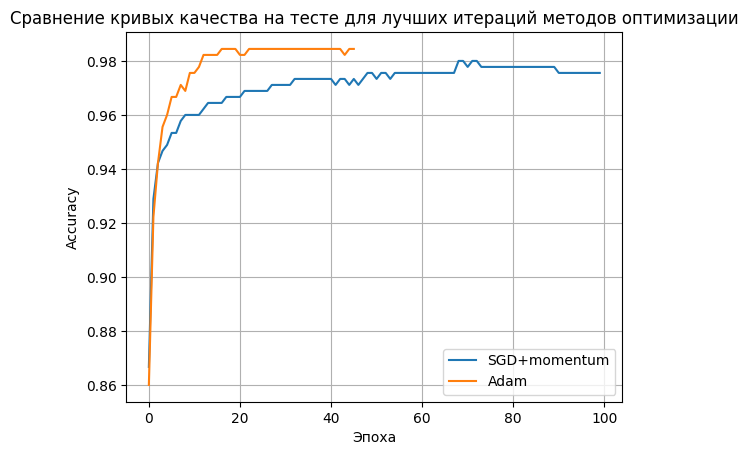

In [39]:
best = -1
row_momentum = None
for inds in momentum_test:
    row_momentum, best = (
        inds, inds[-1]) if inds[-1] > best else (row_momentum, best)

best = -1
row_adam = None
for inds in adam_test:
    row_adam, best = (inds, inds[-1]) if inds[-1] > best else (row_adam, best)

plt.title(
    'Сравнение кривых качества на тесте для лучших итераций методов оптимизации')
plt.plot(np.arange(len(row_momentum)), row_momentum, label='SGD+momentum')
plt.plot(np.arange(len(row_adam)), row_adam, label='Adam')
plt.legend(loc='lower right')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.grid()

Перебрав различные способы настройки методов оптимизации и выбрав из них лучшие по критерию конечного результата му получили графики, представимые сверху. Сразу можно отметить две особенности:

- Алгоритм Adam является более устойчивым и предсказуемым алгоримтом, как в плане большого качества итоговой модели при различных вариациях настроек оптимизатора, так и в плане отдельно взятого обучения модели, делая его плавным и без асцилирования метрик качества от итерации к итерации
- SGD+Momentum противоположен в этом методу Adam. Градиентный спуск менее надежен конкурента, из-за постоянно асцилирования ему требуется гараздо большее число итераций, максимальное качество, что он способен принести меньше таквого для Adam, так и еще максимальное качество SGD явялется продуктом сложного подбора параметров оптимизатора, без чего в большинстве случаев итоговое качество остается на уровне 0.92-0.96

Связано это c подходом к высчитыванию градиентного шага: Adam выбирает направление движения неспешно и сильно оглядывается на предыдудущие шаги, для него играет роль (достаточно долго по мере прохода по эпохам) начальное направление движения, аккумулированный результат предыдущих итераций. SGD же даже с momentum сильнее подвержен асциляции при проходах очередного батча, метаясь от направления к направлению. В теории это может помочь ему лучше проскакивать локальные ямы, однако не в данной задаче.

Можно сказать, что использование легковесного и простого метода оптимизации имеет место быть, когда рамки доступной памяти слишком велики. Однако все же предпочтительнее использовать именно Adam из-за неприхотливости в настройке и большей надежности в критерии конечного качества и времени обучения


### `Dropout (1 балл)`

Реализуйте слой Dropout. Сравните обучение сети из большого числа слоёв при использовании Dropout и без его использования (предварительно подберите адекватный параметр $p$). Сделайте выводы.


In [26]:
class Dropout:
    def __init__(self, input_units, output_units, probability=0.5):
        self.weights = np.random.randn(input_units, output_units) * 0.01
        self.biases = np.zeros(output_units)
        self.probability = 1 - probability
        self.apply_mask = True
        self.params = [self.weights, self.biases]

    def forward(self, input):
        self.mask = np.random.binomial(
            1, self.probability, size=(self.weights.shape))
        self.input = input
        weighted = (input @ (self.weights * self.mask)) / \
            self.probability if self.apply_mask else input @ self.weights

        return weighted + self.biases

    def backward(self, grad_output):
        layer_grad_weights = (self.input.T @ grad_output) * self.mask
        layer_grad_bias = np.sum(grad_output, axis=0)
        back_grad_output = grad_output @ (self.weights *
                                          self.mask / self.probability).T

        return back_grad_output, np.r_[layer_grad_weights.ravel(), layer_grad_bias.ravel()]

    def inference(self):
        self.apply_mask = False

    def __repr__(self):
        return f'Dropout({self.weights.shape[0]}, {self.weights.shape[1]}, {1 - self.probability})'

In [27]:
def inference(network):
    for layer in network:
        if isinstance(layer, Dropout):
            layer.inference()
    return network

In [28]:
def initialize_network(network, initialization):
    for layer in network:
        if isinstance(layer, Dense) or isinstance(layer, Dropout):
            input_units, output_units = layer.weights.shape
            if initialization == 'Kaiming':
                layer.weights = np.random.normal(
                    loc=0, scale=2 / output_units, size=(input_units, output_units))

            elif initialization == 'Xavier':
                layer.weights = np.random.normal(
                    loc=0, scale=1 / output_units, size=(input_units, output_units))
            else:
                # Initialize weights with small random numbers from normal distribution.
                # In this case `initialization` represents a standard deviation
                # for normal distribution.
                layer.weights = np.random.randn(
                    input_units, output_units) * initialization
            layer.biases = np.zeros_like(layer.biases)

            layer.params = [layer.weights, layer.biases]

In [42]:
network_dropout = [
    Dense(64, 32),
    ReLU(),
    Dropout(32, 10, 0.3),
    LogSoftmax()
]

network = [
    Dense(64, 32),
    ReLU(),
    Dense(32, 10),
    LogSoftmax()
]

dropout_sgd = Callback(network_dropout, X_train, y_train,
                       X_test, y_test, print=False)
dense_sgd = Callback(network, X_train, y_train,
                     X_test, y_test, print=False)

initialize_network(network, 'Kaiming')
weights = get_weights(network)
set_weights(weights, network_dropout)

res = minimize(
    compute_loss_grad, weights,
    args=[network, X_train, y_train],
    method=SGD,
    callback=dense_sgd.call,
    options={
        'momentum': 0.9,
        'n_iter': 500,
        'lr': 0.01,
        'batch_size': 128,
        'random_state': 42,
        'min_margin': 0.0001
    },
    jac=True)

res = minimize(
    compute_loss_grad, weights,
    args=[network_dropout, X_train, y_train],
    method=SGD,
    callback=dropout_sgd.call,
    options={
        'momentum': 0.9,
        'n_iter': 500,
        'lr': 0.01,
        'batch_size': 128,
        'random_state': 42,
        'min_margin': 0.0001
    },
    jac=True)


preds_test = predict(network, X_test)
test_accuracy = accuracy_score(y_test, preds_test)
print(f'Dense: {dense_sgd.test_acc[-1]:.5f}, \t inference: {test_accuracy:.5f}')

network_dropout = inference(network_dropout)

preds_test = predict(network_dropout, X_test)
test_accuracy = accuracy_score(y_test, preds_test)
print(f'Dropout with droped: {
      dropout_sgd.test_acc[-1]:.5f}, \t inference: {test_accuracy:.5f}')

Dense: 0.96889, 	 inference: 0.96889
Dropout with droped: 0.93333, 	 inference: 0.96444


В проведенных мной экспериантах Dropout смог достигнуть хорошей эффектвности, однако его применение к ряду азитектур способно лишь ухудшить конечное качество. Не все жксперименты вошли в ноутбук, так как являются повоторением этого кода для разных архитектур, а потому оставлен лишь самый последний пример на самой большой моделе по числу слоев. Таблица с показательными замерами (лишь частью из всех, что были мной проделаны) представлены ниже (в нее вошли лишь лучшие результаты для Dropout от каждой из размерностей архитектур, а большое число плохих моделей сюда просто не вошли):

> 2 слоев $\Rightarrow$ Dropout на 2 (p=0.3) 0.96444, Dense 0.96889 $\\$
> 3 слоев $\Rightarrow$ Dropout на 2 (p=0.3) 0.94000, Dense 0.97333 $\\$
> 4 слоев $\Rightarrow$ Dropout на 3 (p=0.4) 0.97111, Dense 0.96222 $\\$
> 5 слоев $\Rightarrow$ Dropout на 3 (p=0.4) 0.95111, Dense 0.94889 $\\$
> 6 слоев $\Rightarrow$ Dropout на 4 (p=0.4) 0.97778, Dense 0.93556 $\\$
> 7 слоев $\Rightarrow$ Dropout на 4 (p=0.4) 0.94889, Dense 0.88444

Для всех проведенных тестов свойсвтенна единая черта: нейросеть с Dropout способна получить результат больший, чем показываемый полносвязной сетью, однако результат слишьно зависит от архитектуры (числа слоев, размерности слоев). Так для сетей с числом слоев в районе 3 (2 - 4 слоев) полносвязная модель почти всегда лучше сети с Dropout, где бы этот слой в сети не находился. Получить результаты лучше способна сеть максимум с одним Dropout слоем и с вероятностью зануления какого-либо контакта в районе 0 (в эеспериментах использовался коэффициент 0.1) и то меньше, чем в половине случаев. Вместе с тем ситуация в корни улучшается при росте числа слоев. Ближе к 6-7 слоям разница между полносвязной и сетью с Dropout начинает нарастать: связяно это с тем, что полносвязная модель начинает терять в качестве на отложенных данных в виду недообучения, в то время как сети с Dropout это способны решать. Поэтому качество на тесте для них с ростом сети не так сильно изменяется.

При этом эксперименты показали, что лучшие результаты удалось добиться только с сетями с одним слоем Dropout и коэффициентом в районе 0.5 (использовался всду 0.4). Слой Dropout же показывает себя лучше всего будучи поставленным в примерную середину сети ближе к выходу.


### `BatchNormalization (1 балл)`

Реализуйте слой `BatchNormalization`. Сравните обучение сети из большого числа слоёв при использовании `BatchNormalization` и без его использования. Сделайте выводы.


In [29]:
class BatchNormalization:

    def __init__(self, input_units, mu_theta=0.8, sigma_theta=0.9):
        self.change_stats = True
        self.mu_theta = mu_theta
        self.sigma_theta = sigma_theta

        self.mu = np.zeros((input_units,))
        self.sigma = np.zeros((input_units,))
        self.gamma = np.ones((input_units))
        self.delta = np.zeros((input_units))
        self.params = [self.gamma, self.delta]

    def forward(self, input):
        self.input = input

        if self.change_stats:
            mu = np.mean(input, axis=0)
            sigma = np.std(input, axis=0)
            self.mu = self.mu_theta * self.mu + (1 - self.mu_theta) * mu
            self.sigma = self.sigma_theta * self.sigma + \
                (1 - self.sigma_theta) * sigma
        else:
            mu = self.mu
            sigma = self.sigma

        self.curr_mu = mu
        self.curr_sigma = sigma
        self.x_mu = input - mu
        self.sigma_sqrt = np.sqrt(sigma + 1e-8)
        self.norm = self.x_mu / self.sigma_sqrt

        return self.gamma * self.norm + self.delta

    def backward(self, grad_output):
        gamma_grad = np.sum(grad_output * self.norm, axis=0)
        delta_grad = np.sum(grad_output, axis=0)

        norm_grad = grad_output * self.gamma
        sigma_grad = np.sum(norm_grad * self.x_mu, axis=0) * - \
            0.5 * (self.sigma_sqrt ** -3)
        mu_grad = - np.sum(norm_grad / self.sigma_sqrt, axis=0) - sigma_grad * \
            (2 / self.input.shape[0]) * np.sum(self.x_mu, axis=0)

        x_grad = norm_grad / self.sigma_sqrt + mu_grad / \
            self.input.shape[0] + sigma_grad * \
            (2 / self.input.shape[0]) * self.x_mu

        return x_grad, np.r_[gamma_grad.ravel(), delta_grad.ravel()]

    def inference(self):
        self.change_stats = False

    def __repr__(self):
        return f'BatchNormalization({self.mu_theta=}, {self.sigma_theta=})'

In [30]:
def inference(network: list):
    for layer in network:
        if isinstance(layer, Dropout):
            layer.inference()
        if isinstance(layer, BatchNormalization):
            layer.inference()
    return network

In [50]:
def make_network(input_size, hidden_layers_size, output_size, n_layers=3, activation_class=ReLU, BN: bool = False):
    network = []

    for layer_idx in range(n_layers):
        # Compute sizes of current linear layer
        layer_in = input_size if layer_idx == 0 else hidden_layers_size
        layer_out = output_size if layer_idx == n_layers - 1 else hidden_layers_size

        # Add linear layer to the network
        network.append(Dense(layer_in, layer_out))

        # Add activation after each layer except the last one
        if layer_idx != n_layers - 1:
            network.append(activation_class())
            if BN:
                network.append(BatchNormalization(hidden_layers_size))

    # Add LogSoftmax layer to the network
    network.append(LogSoftmax())

    return network

In [51]:
make_network(64, 32, 10, 5, ReLU, True)

[Dense(64, 32),
 Relu(),
 BatchNormalization(self.mu_theta=0.8, self.sigma_theta=0.9),
 Dense(32, 32),
 Relu(),
 BatchNormalization(self.mu_theta=0.8, self.sigma_theta=0.9),
 Dense(32, 32),
 Relu(),
 BatchNormalization(self.mu_theta=0.8, self.sigma_theta=0.9),
 Dense(32, 32),
 Relu(),
 BatchNormalization(self.mu_theta=0.8, self.sigma_theta=0.9),
 Dense(32, 10),
 LogSoftmax()]

In [62]:
from scipy.optimize import minimize

with_bn = []
without_bn = []

for bn in [True, False]:
    for layers in range(5, 26, 5):
        network = make_network(64, 32, 10, layers, ReLU, bn)

        cb_adam = Callback(network, X_train, y_train,
                           X_test, y_test, print=False)
        initialize_network(network, 'Kaiming')
        weights = get_weights(network)
        res = minimize(
            compute_loss_grad, weights,
            args=[network, X_train, y_train],
            method=Adam,
            callback=cb_adam.call,
            options={
                'n_iter': 50,
                'batch_size': 0.1,
                'random_state': 42,
                'lr': 0.01
            },
            jac=True)

        network = inference(network)

        preds_test = predict(network, X_test)
        test_accuracy = accuracy_score(y_test, preds_test)

        if bn:
            with_bn.append((layers, cb_adam.test_acc, test_accuracy))
        else:
            without_bn.append((layers, cb_adam.test_acc, test_accuracy))

/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_67128/1838013661.py:26: RuntimeWarning: overflow encountered in exp
  X = np.exp(self.input).astype(np.float64)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_67128/1838013661.py:30: RuntimeWarning: invalid value encountered in divide
  grad = grad_output - sum_init * X / sum_exp


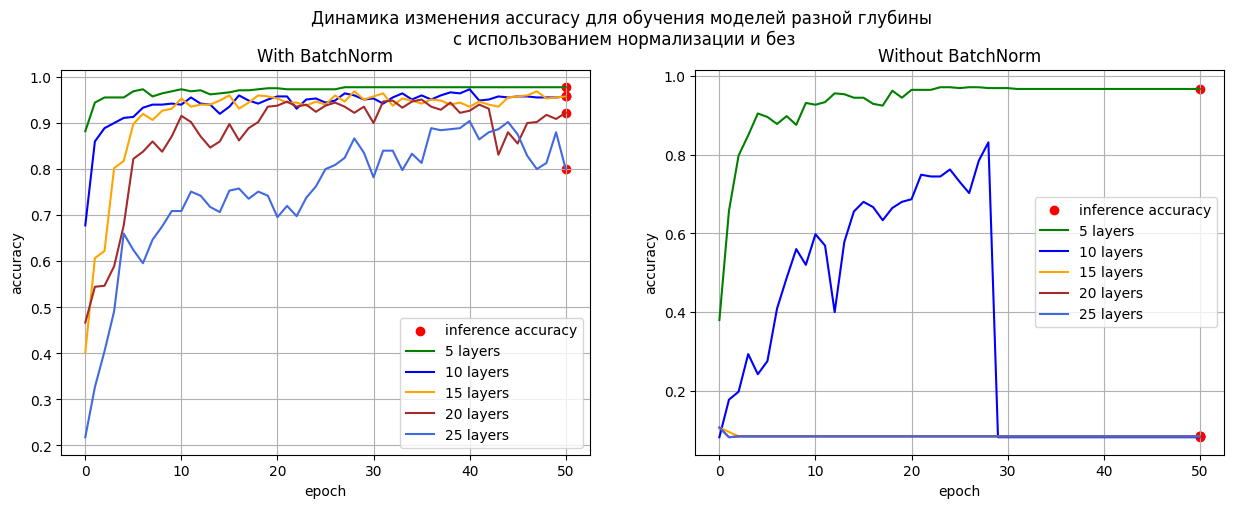

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
title = fig.suptitle(
    'Динамика изменения accuracy для обучения моделей разной глубины \nс использованием нормализации и без')

title.set_position((0.5, 1.001))

axes[0].set_title('With BatchNorm')
axes[0].grid()
axes[1].set_title('Without BatchNorm')
axes[1].grid()
axes[0].set_ylabel('accuracy')
axes[1].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[1].set_xlabel('epoch')

layer_map = {
    5: 'green',
    10: 'blue',
    15: 'orange',
    20: 'brown',
    25: 'royalblue'
}

for i, (layer, arr, final) in enumerate(with_bn):
    arr.append(final)
    axes[0].scatter(50, final, c='red', label='_' if i !=
                    0 else '' + 'inference accuracy')
    axes[0].plot(np.arange(51), arr[:51],
                 c=layer_map[layer], label=f'{layer} layers')

axes[0].legend()

for i, (layer, arr, final) in enumerate(without_bn):
    arr.append(final)
    axes[1].scatter(50, final, c='red', label='_' if i !=
                    0 else '' + 'inference accuracy')
    axes[1].plot(np.arange(51), arr[:51],
                 c=layer_map[layer], label=f'{layer} layers')

axes[1].legend()

###Заметим, что в эксперименте отдельно вынесены значени###
